In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:

def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    # Download and load the training data
    train_dataset = datasets.MNIST(root='./data', 
                             train=True, 
                             download=True, 
                             transform=transform
                             )
    return train_dataset

def generate_random_image(train_dataset):
    images = []
    labels = []
    for _ in range(4):
        idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[idx]
        images.append(img.squeeze().numpy())
        labels.append(label)

# Concatenate images into a 2x2 grid
    top_row = np.concatenate([images[0], images[1]], axis=1)
    bottom_row = np.concatenate([images[2], images[3]], axis=1)
    final_image = np.concatenate([top_row, bottom_row], axis=0)
    return final_image, labels

def split_image_to_patches(image):
    blocks = []  # Initialize empty list to store blocks

    for i in range(4):
        for j in range(4):
            # Extract 14x14 block
            block = image[i*14:(i+1)*14, j*14:(j+1)*14]
            blocks.append(block)  # Add block to our list
    return blocks

def create_dataset(num_images, train_dataset):
    dataset = []
    
    for _ in range(num_images):
        image, labels = generate_random_image(train_dataset)
        dataset.append((image, labels))
    
    return dataset



TypeError: create_dataset() missing 1 required positional argument: 'train_dataset'

In [69]:
train_dataset = load_dataset()
dataset = create_dataset(10000, train_dataset)
print(dataset[0]) #numpy array followed by array of the 4 labels

(array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], shape=(56, 56), dtype=float32), [8, 7, 3, 6])


In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_label_pairs):
        self.image_label_pairs = image_label_pairs
    
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        image, label = self.image_label_pairs[idx]

        patches_array = self.split_image_to_patches(image)
        patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array] #array of 16 with each tensor[196]
        image_tensor = torch.stack(patches_tensor) # tensor [16,196]
        #turn label array of integers into tensor:
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        
        return {
            'image': image_tensor,
            'label': label_tensor,
        }
    
    def split_image_to_patches(self, image):
        blocks = []  # Initialize empty list to store blocks

        for i in range(4):
            for j in range(4):
                # Extract 14x14 block
                block = image[i*14:(i+1)*14, j*14:(j+1)*14]
                blocks.append(block)  # Add block to our list
        return blocks


In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [103]:
class Embedding_Layer(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Embedding_Layer, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        #input dimension is the dimension of each patch
        #embedding_dim is the dimensionality that each patch is embedded onto
    def forward(self, x):
        return self.embedding(x)

class Attention_Layer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Attention_Layer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
    
    def forward(self, query_input, key_input, value_input, mask=None):
        dim_k = self.d_model // self.num_heads
        query = self.W_q(query_input)
        key = self.W_k(key_input)
        value = self.W_v(value_input)
        
        query_key = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dim_k)
        prob = query_key.softmax(dim=-1)
        weighted_attention = torch.matmul(prob, value)
        return weighted_attention, prob
    

class PositionalEncoding(nn.Module):
    # Just add a randomised matrix to 
    def __init__(self, first_dim, embedding_dimension):
        super(PositionalEncoding, self).__init__()
        self.first_dim = first_dim
        self.embedding_dimension = embedding_dimension
        # self.positional_encoding = torch.nn.Parameter(torch.rand(first_dim, embedding_dimension))

    def forward(self, x):
        return x + torch.nn.Parameter(torch.rand(self.first_dim, self.embedding_dimension))
    

class FeedForwardLayer(nn.Module):
    def __init__(self, embedding_dim, hidden_layer_dim):
        super(FeedForwardLayer, self).__init__()
        self.ff1 = torch.nn.Linear(embedding_dim, hidden_layer_dim)
        self.ff2 = torch.nn.Linear(hidden_layer_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        return self.ff2(self.relu(self.ff1(x)))
    

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_loops, feed_forward, num_heads, positional_encoding):
        super(Encoder, self).__init__()
        self.embedding_layer = Embedding_Layer(input_dim, embedding_dim)
        self.positional_encoding = positional_encoding
        self.attn_layer = Attention_Layer(embedding_dim, num_heads)
        self.FF_layer = feed_forward
        self.embedding_dim = embedding_dim
        self.input_dim = input_dim
        self.n_loops = n_loops


        #remove below when doing full model
        self.intermediate = torch.nn.Linear(64*16, 40)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.final = torch.nn.Linear(40, 40)
    
    def get_qkv(self, q_input, k_input, v_input, embedding_dim):
        query = torch.nn.Linear(q_input.size(-1), embedding_dim)
        key = torch.nn.Linear(k_input.size(-1), embedding_dim)
        value = torch.nn.Linear(v_input.size(-1), embedding_dim)
        return query, key, value
    
    def LayerNorm(self, x, eps=1e-6):
        features = x.size(-1)
        a_2 = torch.nn.Parameter(torch.ones(features)) #shape (64,)
        b_2 = torch.nn.Parameter(torch.zeros(features)) #shape (64,)

        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return a_2 * (x - mean) / (std + eps) + b_2

    
    def forward(self, x):
        embedding = self.embedding_layer(x)

        embedding = self.positional_encoding(embedding)

        # for i in range(self.n_loops): #To do, to add loops, we must clone Encoder layers which consist of ff + attn
        # query, key, value = self.get_qkv(x, x, x, self.embedding_dim)
        attn, prob = self.attn_layer.forward(embedding, embedding, embedding, None)
        x = attn + self.LayerNorm(attn)
        x = self.FF_layer(x)
        x = x + self.LayerNorm(x)

        return x
    
    def predict_single_integer(self, x):
        if len(x.shape) == 2:  # Single instance case [16, 64]
            x = x.unsqueeze(0)  # Add batch dimension [1, 16, 64]
        
        # Now x is [batch, 16, 64] in both cases
        x = x.reshape(x.size(0), -1)  # Flatten to [batch, 1024]
        flatten = self.flatten(x)
        x = self.intermediate(flatten)
        x = self.relu(x)
        return self.final(x)
    
    def predict_numbers(self, x):
        if len(x.shape) == 2:  # Single instance case [16, 64]
            x = x.unsqueeze(0)  # Add batch dimension [1, 16, 64]
        
        # Now x is [batch, 16, 64] in both cases
        x = x.reshape(x.size(0), -1)  # Flatten to [batch, 1024]
        flatten = self.flatten(x)
        x = self.intermediate(flatten)
        x = self.relu(x)
        x = self.final(x)
        # Reshape to [batch, 4, 10] for 4 digit predictions
        return x.view(x.size(0), 4, 10)




In [98]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

         # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

                # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

        


In [104]:
device = torch.device("cpu")
embedding_dim = 64
hidden_layer_dimension = 32
input_dimension = 196
epochs = 50
num_patches = 16
fflayer = FeedForwardLayer(embedding_dim, hidden_layer_dimension)
positional_encoding = PositionalEncoding(num_patches, embedding_dim)
model = Encoder(input_dimension, embedding_dim, 1, fflayer, num_heads=1, positional_encoding=positional_encoding)
criterion = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), learning_rate)


dataset_ready = ImageDataset(dataset)
batch_size = 20
dataloader = torch.utils.data.DataLoader(
    dataset_ready,
    batch_size=batch_size,
    shuffle=True,
)



def train():
    model.train()
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm.tqdm(
            dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
        )

        for batch_idx, batch in enumerate(progress_bar):
            
            batch_loss = 0
            image, label = batch['image'].to(device), batch['label'].to(device)

            first_labels = label[:, 0]
            optimizer.zero_grad()

            output = model.forward(image)
            # single_number = model.predict_single_integer(output)
            predictions = model.predict_numbers(output)  # Shape: [batch, 4, 10]

             # Calculate loss for all 4 digits
            batch_loss = sum(criterion(predictions[:, i], label[:, i]) for i in range(4))


            if batch_idx == 0:  # Print only first batch of each epoch
                pred_digits = torch.argmax(predictions[0], dim=1)
                print(f"Predictions: {pred_digits}")
                print(f"Actual labels: {label[0]}")

            progress_bar.set_postfix({"batch_loss": batch_loss.item() /  batch_size})

            epoch_loss += batch_loss.item()
            total_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        
        epoch_loss = epoch_loss / len(dataloader.dataset)
        # total_loss += epoch_loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        print(f"Total {epoch + 1}/{epochs}, Loss: {total_loss / (epoch + 1):.4f}")

        
train()



Epoch 1/50:   3%|▎         | 17/500 [00:00<00:02, 164.68it/s, batch_loss=0.459]

Predictions: tensor([4, 3, 5, 0])
Actual labels: tensor([0, 4, 9, 1])


Epoch 1/50: 100%|██████████| 500/500 [00:03<00:00, 161.19it/s, batch_loss=0.449]


Epoch 1/50, Loss: 0.4558
Total 1/50, Loss: 4558.3261


Epoch 2/50:   3%|▎         | 17/500 [00:00<00:02, 164.67it/s, batch_loss=0.453]

Predictions: tensor([1, 3, 6, 1])
Actual labels: tensor([1, 5, 7, 2])


Epoch 2/50: 100%|██████████| 500/500 [00:03<00:00, 153.23it/s, batch_loss=0.434]


Epoch 2/50, Loss: 0.4426
Total 2/50, Loss: 4492.3650


Epoch 3/50:   4%|▎         | 18/500 [00:00<00:02, 171.50it/s, batch_loss=0.433]

Predictions: tensor([1, 1, 1, 1])
Actual labels: tensor([5, 8, 9, 2])


Epoch 3/50: 100%|██████████| 500/500 [00:02<00:00, 168.47it/s, batch_loss=0.404]


Epoch 3/50, Loss: 0.4227
Total 3/50, Loss: 4404.0280


Epoch 4/50:   3%|▎         | 13/500 [00:00<00:04, 101.20it/s, batch_loss=0.413]

Predictions: tensor([2, 2, 2, 2])
Actual labels: tensor([1, 0, 2, 2])


Epoch 4/50: 100%|██████████| 500/500 [00:03<00:00, 164.15it/s, batch_loss=0.356]


Epoch 4/50, Loss: 0.3877
Total 4/50, Loss: 4272.3683


Epoch 5/50:   4%|▎         | 18/500 [00:00<00:02, 179.17it/s, batch_loss=0.367]

Predictions: tensor([4, 6, 6, 1])
Actual labels: tensor([6, 6, 7, 1])


Epoch 5/50: 100%|██████████| 500/500 [00:02<00:00, 174.63it/s, batch_loss=0.273]


Epoch 5/50, Loss: 0.3228
Total 5/50, Loss: 4063.4038


Epoch 6/50:   4%|▎         | 18/500 [00:00<00:02, 165.25it/s, batch_loss=0.279]

Predictions: tensor([2, 6, 1, 1])
Actual labels: tensor([5, 6, 7, 2])


Epoch 6/50: 100%|██████████| 500/500 [00:03<00:00, 164.80it/s, batch_loss=0.253]


Epoch 6/50, Loss: 0.2631
Total 6/50, Loss: 3824.7138


Epoch 7/50:   4%|▎         | 18/500 [00:00<00:02, 177.93it/s, batch_loss=0.215]

Predictions: tensor([1, 4, 2, 6])
Actual labels: tensor([1, 4, 2, 8])


Epoch 7/50: 100%|██████████| 500/500 [00:02<00:00, 170.07it/s, batch_loss=0.191]


Epoch 7/50, Loss: 0.2252
Total 7/50, Loss: 3600.0490


Epoch 8/50:   4%|▍         | 19/500 [00:00<00:02, 182.70it/s, batch_loss=0.184]

Predictions: tensor([5, 2, 9, 8])
Actual labels: tensor([6, 2, 9, 8])


Epoch 8/50: 100%|██████████| 500/500 [00:03<00:00, 164.71it/s, batch_loss=0.188]


Epoch 8/50, Loss: 0.1970
Total 8/50, Loss: 3396.2817


Epoch 9/50:   4%|▎         | 18/500 [00:00<00:02, 174.21it/s, batch_loss=0.157]

Predictions: tensor([9, 9, 0, 7])
Actual labels: tensor([6, 7, 0, 7])


Epoch 9/50: 100%|██████████| 500/500 [00:02<00:00, 167.98it/s, batch_loss=0.17] 


Epoch 9/50, Loss: 0.1740
Total 9/50, Loss: 3212.2420


Epoch 10/50:   4%|▍         | 19/500 [00:00<00:02, 182.47it/s, batch_loss=0.14] 

Predictions: tensor([3, 5, 3, 0])
Actual labels: tensor([3, 5, 3, 0])


Epoch 10/50: 100%|██████████| 500/500 [00:02<00:00, 172.63it/s, batch_loss=0.144] 


Epoch 10/50, Loss: 0.1574
Total 10/50, Loss: 3048.4286


Epoch 11/50:   4%|▎         | 18/500 [00:00<00:02, 176.36it/s, batch_loss=0.127]

Predictions: tensor([7, 2, 2, 4])
Actual labels: tensor([7, 2, 2, 4])


Epoch 11/50: 100%|██████████| 500/500 [00:02<00:00, 169.12it/s, batch_loss=0.154] 


Epoch 11/50, Loss: 0.1446
Total 11/50, Loss: 2902.7179


Epoch 12/50:   4%|▎         | 18/500 [00:00<00:02, 175.70it/s, batch_loss=0.108] 

Predictions: tensor([0, 5, 6, 6])
Actual labels: tensor([0, 5, 6, 4])


Epoch 12/50: 100%|██████████| 500/500 [00:02<00:00, 177.65it/s, batch_loss=0.123] 


Epoch 12/50, Loss: 0.1346
Total 12/50, Loss: 2773.0315


Epoch 13/50:   4%|▎         | 18/500 [00:00<00:02, 173.28it/s, batch_loss=0.108] 

Predictions: tensor([7, 1, 9, 1])
Actual labels: tensor([7, 1, 9, 1])


Epoch 13/50: 100%|██████████| 500/500 [00:03<00:00, 166.44it/s, batch_loss=0.101] 


Epoch 13/50, Loss: 0.1269
Total 13/50, Loss: 2657.3162


Epoch 14/50:   3%|▎         | 15/500 [00:00<00:03, 148.82it/s, batch_loss=0.165] 

Predictions: tensor([5, 0, 2, 6])
Actual labels: tensor([5, 0, 2, 6])


Epoch 14/50: 100%|██████████| 500/500 [00:02<00:00, 169.33it/s, batch_loss=0.138] 


Epoch 14/50, Loss: 0.1203
Total 14/50, Loss: 2553.4527


Epoch 15/50:   4%|▎         | 18/500 [00:00<00:02, 178.12it/s, batch_loss=0.105] 

Predictions: tensor([8, 8, 7, 5])
Actual labels: tensor([8, 8, 7, 3])


Epoch 15/50: 100%|██████████| 500/500 [00:02<00:00, 171.94it/s, batch_loss=0.105] 


Epoch 15/50, Loss: 0.1137
Total 15/50, Loss: 2458.9951


Epoch 16/50:   4%|▎         | 18/500 [00:00<00:02, 172.02it/s, batch_loss=0.0949]

Predictions: tensor([7, 3, 8, 1])
Actual labels: tensor([7, 3, 8, 1])


Epoch 16/50: 100%|██████████| 500/500 [00:03<00:00, 154.11it/s, batch_loss=0.087] 


Epoch 16/50, Loss: 0.1085
Total 16/50, Loss: 2373.1270


Epoch 17/50:   4%|▎         | 18/500 [00:00<00:02, 177.95it/s, batch_loss=0.127] 

Predictions: tensor([3, 6, 2, 6])
Actual labels: tensor([3, 6, 2, 6])


Epoch 17/50: 100%|██████████| 500/500 [00:03<00:00, 165.11it/s, batch_loss=0.13]  


Epoch 17/50, Loss: 0.1040
Total 17/50, Loss: 2294.7190


Epoch 18/50:   2%|▏         | 10/500 [00:00<00:05, 94.06it/s, batch_loss=0.13] 

Predictions: tensor([5, 2, 1, 7])
Actual labels: tensor([5, 2, 1, 7])


Epoch 18/50: 100%|██████████| 500/500 [00:03<00:00, 137.23it/s, batch_loss=0.111] 


Epoch 18/50, Loss: 0.0997
Total 18/50, Loss: 2222.6229


Epoch 19/50:   3%|▎         | 17/500 [00:00<00:03, 160.71it/s, batch_loss=0.0591]

Predictions: tensor([9, 9, 0, 1])
Actual labels: tensor([9, 9, 0, 1])


Epoch 19/50: 100%|██████████| 500/500 [00:02<00:00, 178.09it/s, batch_loss=0.119] 


Epoch 19/50, Loss: 0.0959
Total 19/50, Loss: 2156.1107


Epoch 20/50:   4%|▍         | 19/500 [00:00<00:02, 181.70it/s, batch_loss=0.0747]

Predictions: tensor([9, 3, 3, 8])
Actual labels: tensor([9, 3, 3, 8])


Epoch 20/50: 100%|██████████| 500/500 [00:02<00:00, 167.08it/s, batch_loss=0.0928]


Epoch 20/50, Loss: 0.0924
Total 20/50, Loss: 2094.5223


Epoch 21/50:   4%|▍         | 19/500 [00:00<00:02, 181.98it/s, batch_loss=0.0811]

Predictions: tensor([0, 7, 7, 1])
Actual labels: tensor([0, 7, 3, 1])


Epoch 21/50: 100%|██████████| 500/500 [00:02<00:00, 177.83it/s, batch_loss=0.0764]


Epoch 21/50, Loss: 0.0899
Total 21/50, Loss: 2037.5751


Epoch 22/50:   3%|▎         | 16/500 [00:00<00:03, 151.51it/s, batch_loss=0.141] 

Predictions: tensor([0, 9, 1, 9])
Actual labels: tensor([0, 5, 1, 9])


Epoch 22/50: 100%|██████████| 500/500 [00:03<00:00, 165.44it/s, batch_loss=0.105] 


Epoch 22/50, Loss: 0.0861
Total 22/50, Loss: 1984.1159


Epoch 23/50:   4%|▎         | 18/500 [00:00<00:02, 179.48it/s, batch_loss=0.128] 

Predictions: tensor([2, 7, 6, 2])
Actual labels: tensor([2, 7, 6, 2])


Epoch 23/50: 100%|██████████| 500/500 [00:02<00:00, 176.62it/s, batch_loss=0.0878]


Epoch 23/50, Loss: 0.0841
Total 23/50, Loss: 1934.4091


Epoch 24/50:   4%|▎         | 18/500 [00:00<00:02, 177.75it/s, batch_loss=0.0846]

Predictions: tensor([5, 5, 6, 1])
Actual labels: tensor([5, 5, 6, 1])


Epoch 24/50: 100%|██████████| 500/500 [00:03<00:00, 165.96it/s, batch_loss=0.0562]


Epoch 24/50, Loss: 0.0818
Total 24/50, Loss: 1887.8992


Epoch 25/50:   4%|▎         | 18/500 [00:00<00:02, 173.66it/s, batch_loss=0.0963]

Predictions: tensor([2, 3, 4, 8])
Actual labels: tensor([2, 3, 4, 8])


Epoch 25/50: 100%|██████████| 500/500 [00:02<00:00, 171.25it/s, batch_loss=0.0599]


Epoch 25/50, Loss: 0.0795
Total 25/50, Loss: 1844.1843


Epoch 26/50:   4%|▍         | 19/500 [00:00<00:02, 182.72it/s, batch_loss=0.0648]

Predictions: tensor([3, 1, 5, 5])
Actual labels: tensor([3, 1, 5, 5])


Epoch 26/50: 100%|██████████| 500/500 [00:03<00:00, 148.23it/s, batch_loss=0.0506]


Epoch 26/50, Loss: 0.0771
Total 26/50, Loss: 1802.9091


Epoch 27/50:   3%|▎         | 17/500 [00:00<00:02, 165.09it/s, batch_loss=0.0861]

Predictions: tensor([5, 6, 4, 4])
Actual labels: tensor([5, 6, 4, 4])


Epoch 27/50: 100%|██████████| 500/500 [00:03<00:00, 157.69it/s, batch_loss=0.0713]


Epoch 27/50, Loss: 0.0757
Total 27/50, Loss: 1764.1700


Epoch 28/50:   3%|▎         | 17/500 [00:00<00:02, 169.63it/s, batch_loss=0.0926]

Predictions: tensor([4, 0, 5, 0])
Actual labels: tensor([7, 0, 5, 0])


Epoch 28/50: 100%|██████████| 500/500 [00:02<00:00, 172.99it/s, batch_loss=0.0793]


Epoch 28/50, Loss: 0.0734
Total 28/50, Loss: 1727.3692


Epoch 29/50:   4%|▎         | 18/500 [00:00<00:02, 173.53it/s, batch_loss=0.0506]

Predictions: tensor([0, 7, 7, 0])
Actual labels: tensor([0, 7, 7, 0])


Epoch 29/50: 100%|██████████| 500/500 [00:03<00:00, 162.08it/s, batch_loss=0.0827]


Epoch 29/50, Loss: 0.0718
Total 29/50, Loss: 1692.5704


Epoch 30/50:   4%|▎         | 18/500 [00:00<00:02, 179.92it/s, batch_loss=0.108] 

Predictions: tensor([0, 7, 8, 2])
Actual labels: tensor([0, 7, 8, 2])


Epoch 30/50: 100%|██████████| 500/500 [00:03<00:00, 158.33it/s, batch_loss=0.0519]


Epoch 30/50, Loss: 0.0703
Total 30/50, Loss: 1659.5898


Epoch 31/50:   3%|▎         | 17/500 [00:00<00:02, 162.07it/s, batch_loss=0.0386]

Predictions: tensor([3, 2, 5, 1])
Actual labels: tensor([3, 2, 5, 1])


Epoch 31/50: 100%|██████████| 500/500 [00:03<00:00, 163.95it/s, batch_loss=0.0694]


Epoch 31/50, Loss: 0.0686
Total 31/50, Loss: 1628.1846


Epoch 32/50:   3%|▎         | 17/500 [00:00<00:02, 162.78it/s, batch_loss=0.0889]

Predictions: tensor([9, 7, 4, 6])
Actual labels: tensor([9, 7, 4, 6])


Epoch 32/50: 100%|██████████| 500/500 [00:02<00:00, 170.09it/s, batch_loss=0.0727]


Epoch 32/50, Loss: 0.0665
Total 32/50, Loss: 1598.0836


Epoch 33/50:   3%|▎         | 16/500 [00:00<00:03, 158.15it/s, batch_loss=0.0339]

Predictions: tensor([8, 1, 1, 6])
Actual labels: tensor([8, 1, 1, 6])


Epoch 33/50: 100%|██████████| 500/500 [00:02<00:00, 169.03it/s, batch_loss=0.0522]


Epoch 33/50, Loss: 0.0654
Total 33/50, Loss: 1569.4683


Epoch 34/50:   4%|▎         | 18/500 [00:00<00:02, 178.14it/s, batch_loss=0.0693]

Predictions: tensor([0, 8, 6, 3])
Actual labels: tensor([0, 8, 6, 3])


Epoch 34/50: 100%|██████████| 500/500 [00:02<00:00, 177.60it/s, batch_loss=0.0416]


Epoch 34/50, Loss: 0.0629
Total 34/50, Loss: 1541.8012


Epoch 35/50:   3%|▎         | 17/500 [00:00<00:02, 165.63it/s, batch_loss=0.0663]

Predictions: tensor([1, 7, 2, 6])
Actual labels: tensor([1, 2, 3, 6])


Epoch 35/50: 100%|██████████| 500/500 [00:02<00:00, 172.00it/s, batch_loss=0.0471]


Epoch 35/50, Loss: 0.0619
Total 35/50, Loss: 1515.4312


Epoch 36/50:   4%|▎         | 18/500 [00:00<00:02, 177.64it/s, batch_loss=0.0953]

Predictions: tensor([4, 1, 7, 7])
Actual labels: tensor([4, 1, 7, 7])


Epoch 36/50: 100%|██████████| 500/500 [00:02<00:00, 169.72it/s, batch_loss=0.0588]


Epoch 36/50, Loss: 0.0606
Total 36/50, Loss: 1490.1806


Epoch 37/50:   3%|▎         | 16/500 [00:00<00:03, 152.71it/s, batch_loss=0.0243]

Predictions: tensor([8, 3, 5, 4])
Actual labels: tensor([8, 3, 5, 4])


Epoch 37/50: 100%|██████████| 500/500 [00:03<00:00, 164.83it/s, batch_loss=0.0384]


Epoch 37/50, Loss: 0.0592
Total 37/50, Loss: 1465.8932


Epoch 38/50:   4%|▎         | 18/500 [00:00<00:02, 175.16it/s, batch_loss=0.0883]

Predictions: tensor([6, 8, 4, 9])
Actual labels: tensor([5, 8, 4, 9])


Epoch 38/50: 100%|██████████| 500/500 [00:03<00:00, 162.91it/s, batch_loss=0.0523]


Epoch 38/50, Loss: 0.0578
Total 38/50, Loss: 1442.5155


Epoch 39/50:   4%|▎         | 18/500 [00:00<00:02, 174.86it/s, batch_loss=0.0467]

Predictions: tensor([2, 5, 9, 6])
Actual labels: tensor([2, 5, 9, 6])


Epoch 39/50: 100%|██████████| 500/500 [00:02<00:00, 171.65it/s, batch_loss=0.047] 


Epoch 39/50, Loss: 0.0562
Total 39/50, Loss: 1419.9454


Epoch 40/50:   4%|▎         | 18/500 [00:00<00:02, 176.60it/s, batch_loss=0.0227]

Predictions: tensor([2, 2, 6, 1])
Actual labels: tensor([0, 2, 5, 1])


Epoch 40/50: 100%|██████████| 500/500 [00:02<00:00, 178.71it/s, batch_loss=0.0508]


Epoch 40/50, Loss: 0.0557
Total 40/50, Loss: 1398.3595


Epoch 41/50:   1%|          | 4/500 [00:00<00:13, 36.56it/s, batch_loss=0.0255]

Predictions: tensor([1, 3, 0, 6])
Actual labels: tensor([1, 3, 0, 6])


Epoch 41/50: 100%|██████████| 500/500 [00:02<00:00, 175.16it/s, batch_loss=0.0426]


Epoch 41/50, Loss: 0.0542
Total 41/50, Loss: 1377.4792


Epoch 42/50:   4%|▎         | 18/500 [00:00<00:02, 178.15it/s, batch_loss=0.0355]

Predictions: tensor([8, 9, 3, 6])
Actual labels: tensor([3, 5, 3, 6])


Epoch 42/50: 100%|██████████| 500/500 [00:03<00:00, 156.95it/s, batch_loss=0.0554]


Epoch 42/50, Loss: 0.0531
Total 42/50, Loss: 1357.3319


Epoch 43/50:   4%|▎         | 18/500 [00:00<00:02, 172.13it/s, batch_loss=0.0599]

Predictions: tensor([8, 7, 0, 4])
Actual labels: tensor([8, 7, 0, 4])


Epoch 43/50: 100%|██████████| 500/500 [00:02<00:00, 172.79it/s, batch_loss=0.0642]


Epoch 43/50, Loss: 0.0521
Total 43/50, Loss: 1337.8775


Epoch 44/50:   4%|▎         | 18/500 [00:00<00:02, 179.99it/s, batch_loss=0.0347]

Predictions: tensor([2, 9, 9, 7])
Actual labels: tensor([2, 9, 9, 9])


Epoch 44/50: 100%|██████████| 500/500 [00:03<00:00, 161.94it/s, batch_loss=0.0532]


Epoch 44/50, Loss: 0.0510
Total 44/50, Loss: 1319.0647


Epoch 45/50:   4%|▎         | 18/500 [00:00<00:02, 177.44it/s, batch_loss=0.0394]

Predictions: tensor([4, 1, 8, 1])
Actual labels: tensor([4, 1, 8, 1])


Epoch 45/50: 100%|██████████| 500/500 [00:02<00:00, 171.50it/s, batch_loss=0.0646]


Epoch 45/50, Loss: 0.0501
Total 45/50, Loss: 1300.8764


Epoch 46/50:   2%|▏         | 12/500 [00:00<00:06, 73.67it/s, batch_loss=0.0248]

Predictions: tensor([4, 0, 7, 1])
Actual labels: tensor([4, 0, 7, 1])


Epoch 46/50: 100%|██████████| 500/500 [00:03<00:00, 166.51it/s, batch_loss=0.0191]


Epoch 46/50, Loss: 0.0491
Total 46/50, Loss: 1283.2807


Epoch 47/50:   3%|▎         | 15/500 [00:00<00:03, 146.16it/s, batch_loss=0.0286]

Predictions: tensor([2, 6, 6, 1])
Actual labels: tensor([2, 6, 6, 1])


Epoch 47/50: 100%|██████████| 500/500 [00:03<00:00, 162.42it/s, batch_loss=0.0622]


Epoch 47/50, Loss: 0.0479
Total 47/50, Loss: 1266.1590


Epoch 48/50:   3%|▎         | 17/500 [00:00<00:02, 163.00it/s, batch_loss=0.0315]

Predictions: tensor([1, 4, 2, 6])
Actual labels: tensor([1, 4, 2, 4])


Epoch 48/50: 100%|██████████| 500/500 [00:02<00:00, 171.29it/s, batch_loss=0.0448]


Epoch 48/50, Loss: 0.0472
Total 48/50, Loss: 1249.6235


Epoch 49/50:   4%|▎         | 18/500 [00:00<00:02, 173.36it/s, batch_loss=0.0474]

Predictions: tensor([2, 3, 3, 1])
Actual labels: tensor([2, 3, 3, 1])


Epoch 49/50: 100%|██████████| 500/500 [00:02<00:00, 170.09it/s, batch_loss=0.045] 


Epoch 49/50, Loss: 0.0464
Total 49/50, Loss: 1233.5841


Epoch 50/50:   4%|▎         | 18/500 [00:00<00:02, 173.47it/s, batch_loss=0.0623]

Predictions: tensor([5, 2, 4, 5])
Actual labels: tensor([5, 2, 4, 5])


Epoch 50/50: 100%|██████████| 500/500 [00:02<00:00, 166.79it/s, batch_loss=0.042] 

Epoch 50/50, Loss: 0.0460
Total 50/50, Loss: 1218.1083


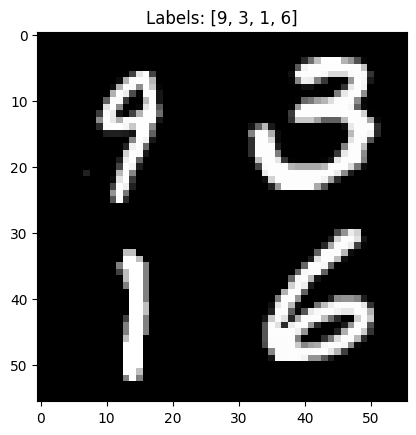

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([9]) prediction should equal 9


In [86]:
def do_test(model):
    image, label = generate_random_image(train_dataset)
    plt.imshow(image, cmap='gray')
    plt.title(f"Labels: {label}")
    plt.show()

    patches_array = split_image_to_patches(image)
    patches_tensor = [torch.tensor(patch.flatten(), dtype=torch.float32) for patch in patches_array]
    image_tensor = torch.stack(patches_tensor) # tensor [16,196]
    # print(image_tensor.shape, 'imagetensor.shape')

    model.eval()
    output = model.forward(image_tensor)
    single_number = model.predict_single_integer(output)
    prediction = torch.argmax(single_number, dim=1)
    print(prediction, 'prediction', "should equal", label[0])
do_test(model)

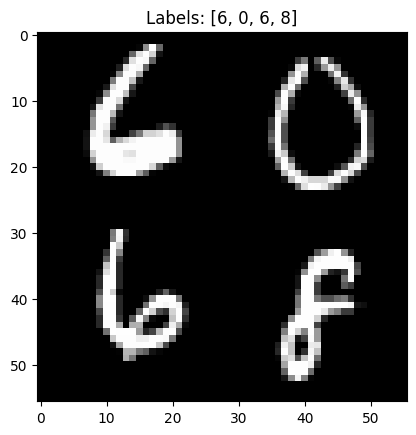

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([6]) prediction should equal 6


In [87]:
do_test(model)

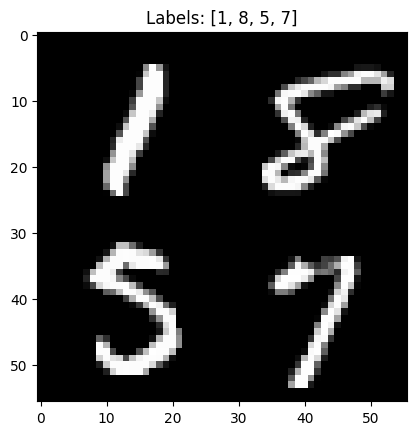

torch.Size([1, 1024]) x.shape
torch.Size([1, 1024]) flatten.shape
tensor([1]) prediction should equal 1


In [88]:
do_test(model)

In [95]:
#With positional encoding

device = torch.device("cpu")
embedding_dim = 64
num_patches = 16
hidden_layer_dimension = 32
input_dimension = 196
epochs = 50
fflayer = FeedForwardLayer(embedding_dim, hidden_layer_dimension)
positional_encoding = PositionalEncoding(num_patches, embedding_dim)

model = Encoder(input_dimension, embedding_dim, 1, fflayer, num_heads=1, positional_encoding=positional_encoding)


criterion = torch.nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), learning_rate)


dataset_ready = ImageDataset(dataset)
batch_size = 20
dataloader = torch.utils.data.DataLoader(
    dataset_ready,
    batch_size=batch_size,
    shuffle=True,
)



def train():
    model.train()
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm.tqdm(
            dataloader, desc=f"Epoch {epoch + 1}/{epochs}"
        )

        for batch_idx, batch in enumerate(progress_bar):
            
            batch_loss = 0
            image, label = batch['image'].to(device), batch['label'].to(device)

            first_labels = label[:, 0]
            optimizer.zero_grad()

            output = model.forward(image)
            single_number = model.predict_single_integer(output)

            predictions = torch.argmax(single_number, dim=1)
            if batch_idx == 0:  # Print only first batch of each epoch
                print(f"Predictions: {predictions[0:5]}")
                print(f"Actual labels: {first_labels[0:5]}")
            batch_loss = criterion(single_number, first_labels)

            progress_bar.set_postfix({"batch_loss": batch_loss.item() /  batch_size})

            epoch_loss += batch_loss.item()
            total_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()
        
        epoch_loss = epoch_loss / len(dataloader.dataset)
        # total_loss += epoch_loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        print(f"Total {epoch + 1}/{epochs}, Loss: {total_loss / (epoch + 1):.4f}")

        
train()



Epoch 1/50:   3%|▎         | 16/500 [00:00<00:03, 158.26it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([6, 6, 6, 6, 6])
Actual labels: tensor([2, 8, 4, 7, 4])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 1/50:  12%|█▏        | 58/500 [00:00<00:02, 191.63it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  20%|█▉        | 99/500 [00:00<00:02, 195.34it/s, batch_loss=0.112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  28%|██▊       | 140/500 [00:00<00:01, 195.58it/s, batch_loss=0.118]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  36%|███▌      | 181/500 [00:01<00:01, 194.70it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  44%|████▍     | 221/500 [00:01<00:01, 180.53it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  52%|█████▏    | 262/500 [00:01<00:01, 187.57it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  56%|█████▌    | 281/500 [00:01<00:01, 150.24it/s, batch_loss=0.112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 1/50:  65%|██████▍   | 323/500 [00:01<00:01, 175.27it/s, batch_loss=0.111]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  73%|███████▎  | 363/500 [00:02<00:00, 183.93it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  81%|████████  | 405/500 [00:02<00:00, 195.81it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  89%|████████▉ | 447/500 [00:02<00:00, 195.77it/s, batch_loss=0.114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50:  97%|█████████▋| 487/500 [00:02<00:00, 193.17it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 1/50: 100%|██████████| 500/500 [00:02<00:00, 186.65it/s, batch_loss=0.117]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 1/50, Loss: 0.1139
Total 1/50, Loss: 1138.6587


Epoch 2/50:   4%|▍         | 20/500 [00:00<00:02, 196.16it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 6, 6, 6, 6])
Actual labels: tensor([2, 5, 6, 8, 0])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:   4%|▍         | 20/500 [00:00<00:02, 196.16it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  12%|█▏        | 60/500 [00:00<00:02, 190.73it/s, batch_loss=0.108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  12%|█▏        | 60/500 [00:00<00:02, 190.73it/s, batch_loss=0.111]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  20%|██        | 102/500 [00:00<00:02, 198.10it/s, batch_loss=0.114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  20%|██        | 102/500 [00:00<00:02, 198.10it/s, batch_loss=0.114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  29%|██▉       | 145/500 [00:00<00:01, 204.70it/s, batch_loss=0.116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  29%|██▉       | 145/500 [00:00<00:01, 204.70it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  37%|███▋      | 187/500 [00:00<00:01, 198.17it/s, batch_loss=0.119]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  37%|███▋      | 187/500 [00:01<00:01, 198.17it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  46%|████▌     | 229/500 [00:01<00:01, 198.33it/s, batch_loss=0.108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  46%|████▌     | 229/500 [00:01<00:01, 198.33it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  54%|█████▍    | 272/500 [00:01<00:01, 202.85it/s, batch_loss=0.107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 2/50:  54%|█████▍    | 272/500 [00:01<00:01, 202.85it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  59%|█████▊    | 293/500 [00:01<00:01, 158.48it/s, batch_loss=0.116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  63%|██████▎   | 314/500 [00:01<00:01, 170.66it/s, batch_loss=0.108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  67%|██████▋   | 335/500 [00:01<00:00, 179.99it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  71%|███████   | 355/500 [00:01<00:00, 185.35it/s, batch_loss=0.114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  75%|███████▌  | 375/500 [00:01<00:00, 185.16it/s, batch_loss=0.103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  79%|███████▉  | 395/500 [00:02<00:00, 188.65it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  83%|████████▎ | 415/500 [00:02<00:00, 188.64it/s, batch_loss=0.105]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  87%|████████▋ | 435/500 [00:02<00:00, 184.77it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  91%|█████████ | 454/500 [00:02<00:00, 184.73it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  95%|█████████▍| 474/500 [00:02<00:00, 186.86it/s, batch_loss=0.102]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50:  95%|█████████▍| 474/500 [00:02<00:00, 186.86it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 2/50: 100%|██████████| 500/500 [00:02<00:00, 189.35it/s, batch_loss=0.109]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 2/50, Loss: 0.1114
Total 2/50, Loss: 1126.5228


Epoch 3/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([4, 1, 7, 9, 0])
Actual labels: tensor([5, 1, 7, 4, 0])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:   4%|▍         | 21/500 [00:00<00:02, 205.89it/s, batch_loss=0.112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:   4%|▍         | 21/500 [00:00<00:02, 205.89it/s, batch_loss=0.106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:   8%|▊         | 42/500 [00:00<00:02, 199.47it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  12%|█▏        | 62/500 [00:00<00:02, 190.31it/s, batch_loss=0.107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  12%|█▏        | 62/500 [00:00<00:02, 190.31it/s, batch_loss=0.113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  16%|█▋        | 82/500 [00:00<00:02, 185.85it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  20%|██        | 102/500 [00:00<00:02, 187.84it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  20%|██        | 102/500 [00:00<00:02, 187.84it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  24%|██▍       | 121/500 [00:00<00:02, 187.64it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  28%|██▊       | 141/500 [00:00<00:01, 189.50it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  28%|██▊       | 141/500 [00:00<00:01, 189.50it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  28%|██▊       | 141/500 [00:00<00:01, 189.50it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  32%|███▏      | 160/500 [00:00<00:02, 140.59it/s, batch_loss=0.108] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  32%|███▏      | 160/500 [00:01<00:02, 140.59it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  36%|███▌      | 179/500 [00:01<00:02, 151.40it/s, batch_loss=0.108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  40%|███▉      | 198/500 [00:01<00:01, 161.37it/s, batch_loss=0.116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  40%|███▉      | 198/500 [00:01<00:01, 161.37it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  44%|████▍     | 219/500 [00:01<00:01, 172.66it/s, batch_loss=0.121]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  48%|████▊     | 238/500 [00:01<00:01, 174.71it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  48%|████▊     | 238/500 [00:01<00:01, 174.71it/s, batch_loss=0.0979]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  51%|█████▏    | 257/500 [00:01<00:01, 177.33it/s, batch_loss=0.113] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  51%|█████▏    | 257/500 [00:01<00:01, 177.33it/s, batch_loss=0.112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  55%|█████▌    | 276/500 [00:01<00:01, 165.42it/s, batch_loss=0.107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  59%|█████▉    | 294/500 [00:01<00:01, 169.18it/s, batch_loss=0.113] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  59%|█████▉    | 294/500 [00:01<00:01, 169.18it/s, batch_loss=0.111]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  63%|██████▎   | 313/500 [00:01<00:01, 174.42it/s, batch_loss=0.107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  67%|██████▋   | 333/500 [00:01<00:00, 181.56it/s, batch_loss=0.112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  67%|██████▋   | 333/500 [00:02<00:00, 181.56it/s, batch_loss=0.103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  71%|███████   | 354/500 [00:02<00:00, 189.40it/s, batch_loss=0.117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  75%|███████▍  | 374/500 [00:02<00:00, 185.78it/s, batch_loss=0.114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  75%|███████▍  | 374/500 [00:02<00:00, 185.78it/s, batch_loss=0.108] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  79%|███████▊  | 393/500 [00:02<00:00, 185.69it/s, batch_loss=0.115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  79%|███████▊  | 393/500 [00:02<00:00, 185.69it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  79%|███████▊  | 393/500 [00:02<00:00, 185.69it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  82%|████████▏ | 412/500 [00:02<00:00, 140.21it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  86%|████████▌ | 431/500 [00:02<00:00, 151.96it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  86%|████████▌ | 431/500 [00:02<00:00, 151.96it/s, batch_loss=0.106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  90%|████████▉ | 449/500 [00:02<00:00, 157.73it/s, batch_loss=0.103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  94%|█████████▍| 469/500 [00:02<00:00, 166.93it/s, batch_loss=0.106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  94%|█████████▍| 469/500 [00:02<00:00, 166.93it/s, batch_loss=0.103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50:  94%|█████████▍| 469/500 [00:02<00:00, 166.93it/s, batch_loss=0.0978]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 3/50: 100%|██████████| 500/500 [00:02<00:00, 171.06it/s, batch_loss=0.113] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 3/50, Loss: 0.1092
Total 3/50, Loss: 1114.9849


Epoch 4/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([6, 6, 7, 0, 4])
Actual labels: tensor([6, 2, 9, 0, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:   3%|▎         | 15/500 [00:00<00:03, 139.71it/s, batch_loss=0.101]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:   3%|▎         | 15/500 [00:00<00:03, 139.71it/s, batch_loss=0.106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:   6%|▋         | 32/500 [00:00<00:03, 151.53it/s, batch_loss=0.099]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:   6%|▋         | 32/500 [00:00<00:03, 151.53it/s, batch_loss=0.101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  10%|█         | 51/500 [00:00<00:02, 165.54it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  10%|█         | 51/500 [00:00<00:02, 165.54it/s, batch_loss=0.11]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  14%|█▎        | 68/500 [00:00<00:02, 159.62it/s, batch_loss=0.106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  14%|█▎        | 68/500 [00:00<00:02, 159.62it/s, batch_loss=0.105]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  17%|█▋        | 86/500 [00:00<00:02, 165.61it/s, batch_loss=0.105]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  17%|█▋        | 86/500 [00:00<00:02, 165.61it/s, batch_loss=0.103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  21%|██        | 106/500 [00:00<00:02, 173.95it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  21%|██        | 106/500 [00:00<00:02, 173.95it/s, batch_loss=0.104] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  21%|██        | 106/500 [00:00<00:02, 173.95it/s, batch_loss=0.0954]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  25%|██▍       | 124/500 [00:00<00:02, 164.81it/s, batch_loss=0.112] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  25%|██▍       | 124/500 [00:00<00:02, 164.81it/s, batch_loss=0.102]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  28%|██▊       | 141/500 [00:00<00:02, 150.23it/s, batch_loss=0.11] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  28%|██▊       | 141/500 [00:01<00:02, 150.23it/s, batch_loss=0.106] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  28%|██▊       | 141/500 [00:01<00:02, 150.23it/s, batch_loss=0.109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  31%|███▏      | 157/500 [00:01<00:02, 124.33it/s, batch_loss=0.105] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  35%|███▍      | 173/500 [00:01<00:02, 131.83it/s, batch_loss=0.102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  35%|███▍      | 173/500 [00:01<00:02, 131.83it/s, batch_loss=0.104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  38%|███▊      | 190/500 [00:01<00:02, 139.88it/s, batch_loss=0.099] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  42%|████▏     | 211/500 [00:01<00:01, 157.63it/s, batch_loss=0.102]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  42%|████▏     | 211/500 [00:01<00:01, 157.63it/s, batch_loss=0.106] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  46%|████▌     | 231/500 [00:01<00:01, 167.11it/s, batch_loss=0.104] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  50%|█████     | 252/500 [00:01<00:01, 176.52it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  50%|█████     | 252/500 [00:01<00:01, 176.52it/s, batch_loss=0.102]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  54%|█████▍    | 271/500 [00:01<00:01, 171.00it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  58%|█████▊    | 289/500 [00:01<00:01, 172.13it/s, batch_loss=0.107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  58%|█████▊    | 289/500 [00:01<00:01, 172.13it/s, batch_loss=0.102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  62%|██████▏   | 309/500 [00:01<00:01, 178.55it/s, batch_loss=0.0983]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  62%|██████▏   | 309/500 [00:01<00:01, 178.55it/s, batch_loss=0.107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  66%|██████▌   | 328/500 [00:02<00:01, 138.83it/s, batch_loss=0.108] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  69%|██████▉   | 344/500 [00:02<00:01, 142.66it/s, batch_loss=0.105] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  73%|███████▎  | 363/500 [00:02<00:00, 153.46it/s, batch_loss=0.111] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  76%|███████▌  | 380/500 [00:02<00:00, 157.80it/s, batch_loss=0.101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  80%|███████▉  | 399/500 [00:02<00:00, 164.67it/s, batch_loss=0.0996]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  84%|████████▎ | 418/500 [00:02<00:00, 171.40it/s, batch_loss=0.0987]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  87%|████████▋ | 437/500 [00:02<00:00, 174.48it/s, batch_loss=0.1]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  91%|█████████ | 456/500 [00:02<00:00, 177.46it/s, batch_loss=0.101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50:  95%|█████████▌| 477/500 [00:02<00:00, 184.67it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 4/50: 100%|██████████| 500/500 [00:03<00:00, 162.82it/s, batch_loss=0.102] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 4/50, Loss: 0.1043
Total 4/50, Loss: 1096.9525


Epoch 5/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0966]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([0, 9, 7, 6, 3])
Actual labels: tensor([0, 1, 6, 0, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:   4%|▎         | 18/500 [00:00<00:02, 174.68it/s, batch_loss=0.102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:   4%|▎         | 18/500 [00:00<00:02, 174.68it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:   8%|▊         | 39/500 [00:00<00:02, 192.71it/s, batch_loss=0.0951]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  12%|█▏        | 59/500 [00:00<00:02, 192.56it/s, batch_loss=0.0916]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  12%|█▏        | 59/500 [00:00<00:02, 192.56it/s, batch_loss=0.0956]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  12%|█▏        | 59/500 [00:00<00:02, 192.56it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  16%|█▌        | 79/500 [00:00<00:02, 158.09it/s, batch_loss=0.101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  20%|█▉        | 99/500 [00:00<00:02, 170.49it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  20%|█▉        | 99/500 [00:00<00:02, 170.49it/s, batch_loss=0.0969]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  23%|██▎       | 117/500 [00:00<00:02, 171.34it/s, batch_loss=0.0934]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  27%|██▋       | 136/500 [00:00<00:02, 175.14it/s, batch_loss=0.1]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  27%|██▋       | 136/500 [00:00<00:02, 175.14it/s, batch_loss=0.0948]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  31%|███       | 154/500 [00:00<00:02, 170.09it/s, batch_loss=0.0944]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  34%|███▍      | 172/500 [00:01<00:01, 165.13it/s, batch_loss=0.0902]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  34%|███▍      | 172/500 [00:01<00:01, 165.13it/s, batch_loss=0.0944]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  38%|███▊      | 191/500 [00:01<00:01, 170.39it/s, batch_loss=0.0863]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  42%|████▏     | 211/500 [00:01<00:01, 176.67it/s, batch_loss=0.0966]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  42%|████▏     | 211/500 [00:01<00:01, 176.67it/s, batch_loss=0.103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  46%|████▌     | 231/500 [00:01<00:01, 181.88it/s, batch_loss=0.0918]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  50%|█████     | 252/500 [00:01<00:01, 187.60it/s, batch_loss=0.0891]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  50%|█████     | 252/500 [00:01<00:01, 187.60it/s, batch_loss=0.0921]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  55%|█████▍    | 273/500 [00:01<00:01, 191.37it/s, batch_loss=0.102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  59%|█████▊    | 293/500 [00:01<00:01, 193.09it/s, batch_loss=0.0888]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  59%|█████▊    | 293/500 [00:01<00:01, 193.09it/s, batch_loss=0.0903]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  63%|██████▎   | 314/500 [00:01<00:00, 195.53it/s, batch_loss=0.0945]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  67%|██████▋   | 335/500 [00:01<00:00, 198.12it/s, batch_loss=0.102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  67%|██████▋   | 335/500 [00:01<00:00, 198.12it/s, batch_loss=0.101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  67%|██████▋   | 335/500 [00:01<00:00, 198.12it/s, batch_loss=0.091] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  71%|███████   | 355/500 [00:02<00:00, 151.91it/s, batch_loss=0.0809]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  71%|███████   | 355/500 [00:02<00:00, 151.91it/s, batch_loss=0.0893]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  75%|███████▌  | 376/500 [00:02<00:00, 164.98it/s, batch_loss=0.0908]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  79%|███████▉  | 396/500 [00:02<00:00, 172.97it/s, batch_loss=0.085] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  79%|███████▉  | 396/500 [00:02<00:00, 172.97it/s, batch_loss=0.0903]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  83%|████████▎ | 417/500 [00:02<00:00, 181.83it/s, batch_loss=0.0855]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  87%|████████▋ | 437/500 [00:02<00:00, 186.04it/s, batch_loss=0.0965]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  87%|████████▋ | 437/500 [00:02<00:00, 186.04it/s, batch_loss=0.0843]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  87%|████████▋ | 437/500 [00:02<00:00, 186.04it/s, batch_loss=0.0899]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  91%|█████████▏| 457/500 [00:02<00:00, 156.94it/s, batch_loss=0.0895]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  91%|█████████▏| 457/500 [00:02<00:00, 156.94it/s, batch_loss=0.0873]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50:  96%|█████████▌| 478/500 [00:02<00:00, 168.52it/s, batch_loss=0.0749]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 5/50: 100%|██████████| 500/500 [00:02<00:00, 176.25it/s, batch_loss=0.0853]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 5/50, Loss: 0.0946
Total 5/50, Loss: 1066.7053


Epoch 6/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0816]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([0, 3, 7, 4, 9])
Actual labels: tensor([6, 3, 5, 7, 8])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0897]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:   4%|▍         | 20/500 [00:00<00:02, 193.10it/s, batch_loss=0.0916]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:   4%|▍         | 20/500 [00:00<00:02, 193.10it/s, batch_loss=0.092] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:   8%|▊         | 40/500 [00:00<00:02, 194.88it/s, batch_loss=0.0888]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:   8%|▊         | 40/500 [00:00<00:02, 194.88it/s, batch_loss=0.107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  12%|█▏        | 60/500 [00:00<00:02, 172.36it/s, batch_loss=0.0914]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  12%|█▏        | 60/500 [00:00<00:02, 172.36it/s, batch_loss=0.0781]

torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  12%|█▏        | 60/500 [00:00<00:02, 172.36it/s, batch_loss=0.0867]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  20%|█▉        | 99/500 [00:00<00:02, 162.67it/s, batch_loss=0.0881]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 6/50:  20%|█▉        | 99/500 [00:00<00:02, 162.67it/s, batch_loss=0.0932]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  20%|█▉        | 99/500 [00:00<00:02, 162.67it/s, batch_loss=0.093] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  23%|██▎       | 116/500 [00:00<00:03, 127.79it/s, batch_loss=0.087] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  23%|██▎       | 116/500 [00:00<00:03, 127.79it/s, batch_loss=0.0956]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  27%|██▋       | 134/500 [00:00<00:02, 139.68it/s, batch_loss=0.0827]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  31%|███       | 155/500 [00:01<00:02, 155.78it/s, batch_loss=0.0917]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  31%|███       | 155/500 [00:01<00:02, 155.78it/s, batch_loss=0.0889]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  35%|███▍      | 174/500 [00:01<00:01, 164.71it/s, batch_loss=0.0838]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  39%|███▉      | 195/500 [00:01<00:01, 175.63it/s, batch_loss=0.0815]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  39%|███▉      | 195/500 [00:01<00:01, 175.63it/s, batch_loss=0.0931]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  43%|████▎     | 215/500 [00:01<00:01, 181.32it/s, batch_loss=0.0852]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  47%|████▋     | 235/500 [00:01<00:01, 185.54it/s, batch_loss=0.0978]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  47%|████▋     | 235/500 [00:01<00:01, 185.54it/s, batch_loss=0.0788]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  51%|█████     | 255/500 [00:01<00:01, 188.08it/s, batch_loss=0.0717]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  55%|█████▌    | 275/500 [00:01<00:01, 191.52it/s, batch_loss=0.0817]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  55%|█████▌    | 275/500 [00:01<00:01, 191.52it/s, batch_loss=0.107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  59%|█████▉    | 295/500 [00:01<00:01, 188.83it/s, batch_loss=0.0901]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  63%|██████▎   | 315/500 [00:01<00:00, 188.08it/s, batch_loss=0.093] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  63%|██████▎   | 315/500 [00:01<00:00, 188.08it/s, batch_loss=0.0808]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  67%|██████▋   | 335/500 [00:01<00:00, 190.24it/s, batch_loss=0.075] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  71%|███████   | 356/500 [00:02<00:00, 194.61it/s, batch_loss=0.0769]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  71%|███████   | 356/500 [00:02<00:00, 194.61it/s, batch_loss=0.0733]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  75%|███████▌  | 376/500 [00:02<00:00, 192.02it/s, batch_loss=0.075] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  75%|███████▌  | 376/500 [00:02<00:00, 192.02it/s, batch_loss=0.0799]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  79%|███████▉  | 396/500 [00:02<00:00, 189.40it/s, batch_loss=0.0741]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  83%|████████▎ | 416/500 [00:02<00:00, 191.71it/s, batch_loss=0.0988]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  83%|████████▎ | 416/500 [00:02<00:00, 191.71it/s, batch_loss=0.0822]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  87%|████████▋ | 436/500 [00:02<00:00, 149.82it/s, batch_loss=0.0787]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  91%|█████████▏| 457/500 [00:02<00:00, 162.92it/s, batch_loss=0.0806]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50:  96%|█████████▌| 478/500 [00:02<00:00, 172.63it/s, batch_loss=0.0735]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 6/50: 100%|██████████| 500/500 [00:02<00:00, 174.17it/s, batch_loss=0.0705]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 6/50, Loss: 0.0843
Total 6/50, Loss: 1029.4717


Epoch 7/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0685]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([6, 1, 7, 6, 6])
Actual labels: tensor([0, 1, 9, 6, 6])


Epoch 7/50:   4%|▍         | 20/500 [00:00<00:02, 195.67it/s, batch_loss=0.0676]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:   4%|▍         | 20/500 [00:00<00:02, 195.67it/s, batch_loss=0.0748]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:   8%|▊         | 41/500 [00:00<00:02, 199.07it/s, batch_loss=0.0718]

torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  12%|█▏        | 61/500 [00:00<00:02, 198.95it/s, batch_loss=0.0803]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  12%|█▏        | 61/500 [00:00<00:02, 198.95it/s, batch_loss=0.0813]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 193.98it/s, batch_loss=0.0672]

torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  16%|█▌        | 81/500 [00:00<00:02, 193.98it/s, batch_loss=0.0833]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  20%|██        | 101/500 [00:00<00:02, 184.07it/s, batch_loss=0.0794]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  20%|██        | 101/500 [00:00<00:02, 184.07it/s, batch_loss=0.0705]

torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  24%|██▍       | 121/500 [00:00<00:02, 188.92it/s, batch_loss=0.076] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  28%|██▊       | 142/500 [00:00<00:01, 192.74it/s, batch_loss=0.0766]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  28%|██▊       | 142/500 [00:00<00:01, 192.74it/s, batch_loss=0.0634]

torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  33%|███▎      | 163/500 [00:00<00:01, 197.42it/s, batch_loss=0.0717]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  37%|███▋      | 183/500 [00:01<00:01, 186.85it/s, batch_loss=0.068] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  37%|███▋      | 183/500 [00:01<00:01, 186.85it/s, batch_loss=0.0765]

torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  40%|████      | 202/500 [00:01<00:01, 187.05it/s, batch_loss=0.0664]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  44%|████▍     | 222/500 [00:01<00:01, 188.37it/s, batch_loss=0.0842]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  48%|████▊     | 242/500 [00:01<00:01, 190.52it/s, batch_loss=0.0761]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  52%|█████▏    | 262/500 [00:01<00:01, 189.23it/s, batch_loss=0.0734]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  52%|█████▏    | 262/500 [00:01<00:01, 189.23it/s, batch_loss=0.0737]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  60%|██████    | 301/500 [00:01<00:01, 153.23it/s, batch_loss=0.0731]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  60%|██████    | 301/500 [00:01<00:01, 153.23it/s, batch_loss=0.0938]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  68%|██████▊   | 339/500 [00:01<00:00, 166.57it/s, batch_loss=0.0723]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  68%|██████▊   | 339/500 [00:01<00:00, 166.57it/s, batch_loss=0.0752]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  75%|███████▌  | 377/500 [00:02<00:00, 175.78it/s, batch_loss=0.0837]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  75%|███████▌  | 377/500 [00:02<00:00, 175.78it/s, batch_loss=0.0634]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  83%|████████▎ | 416/500 [00:02<00:00, 183.19it/s, batch_loss=0.0607]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  83%|████████▎ | 416/500 [00:02<00:00, 183.19it/s, batch_loss=0.0703]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  87%|████████▋ | 435/500 [00:02<00:00, 174.00it/s, batch_loss=0.0868]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  91%|█████████▏| 457/500 [00:02<00:00, 184.44it/s, batch_loss=0.0719]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50:  95%|█████████▌| 477/500 [00:02<00:00, 187.51it/s, batch_loss=0.0764]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 7/50:  99%|█████████▉| 497/500 [00:02<00:00, 188.18it/s, batch_loss=0.0617]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 7/50: 100%|██████████| 500/500 [00:02<00:00, 180.48it/s, batch_loss=0.064] 


torch.Size([20, 16, 64]) x.shape
Epoch 7/50, Loss: 0.0751
Total 7/50, Loss: 989.6563


Epoch 8/50:   3%|▎         | 16/500 [00:00<00:03, 157.49it/s, batch_loss=0.0552]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([0, 6, 7, 7, 1])
Actual labels: tensor([0, 6, 7, 9, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:   3%|▎         | 16/500 [00:00<00:03, 157.49it/s, batch_loss=0.068] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:   3%|▎         | 16/500 [00:00<00:03, 157.49it/s, batch_loss=0.0838]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  11%|█         | 56/500 [00:00<00:02, 183.78it/s, batch_loss=0.0779]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  11%|█         | 56/500 [00:00<00:02, 183.78it/s, batch_loss=0.0566]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  11%|█         | 56/500 [00:00<00:02, 183.78it/s, batch_loss=0.0692]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  19%|█▉        | 96/500 [00:00<00:02, 190.45it/s, batch_loss=0.0625]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  19%|█▉        | 96/500 [00:00<00:02, 190.45it/s, batch_loss=0.0528]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  19%|█▉        | 96/500 [00:00<00:02, 190.45it/s, batch_loss=0.0662]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  28%|██▊       | 139/500 [00:00<00:01, 202.42it/s, batch_loss=0.0674]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 8/50:  36%|███▌      | 181/500 [00:01<00:01, 166.14it/s, batch_loss=0.0637]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  44%|████▍     | 221/500 [00:01<00:01, 180.01it/s, batch_loss=0.0746]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  52%|█████▏    | 262/500 [00:01<00:01, 188.10it/s, batch_loss=0.0685]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  60%|██████    | 302/500 [00:01<00:01, 191.35it/s, batch_loss=0.0672]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  64%|██████▍   | 322/500 [00:01<00:00, 191.99it/s, batch_loss=0.0619]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  72%|███████▏  | 362/500 [00:02<00:00, 192.55it/s, batch_loss=0.0533]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  81%|████████  | 403/500 [00:02<00:00, 188.76it/s, batch_loss=0.0734]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  89%|████████▊ | 443/500 [00:02<00:00, 191.23it/s, batch_loss=0.0583]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50:  96%|█████████▋| 482/500 [00:02<00:00, 185.03it/s, batch_loss=0.0619]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 8/50: 100%|██████████| 500/500 [00:02<00:00, 184.91it/s, batch_loss=0.0453]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 8/50, Loss: 0.0663
Total 8/50, Loss: 948.8272


Epoch 9/50:   3%|▎         | 17/500 [00:00<00:02, 163.07it/s, batch_loss=0.0607]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 3, 1, 5, 1])
Actual labels: tensor([9, 3, 1, 0, 8])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:   3%|▎         | 17/500 [00:00<00:02, 163.07it/s, batch_loss=0.0473]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  11%|█         | 56/500 [00:00<00:02, 184.05it/s, batch_loss=0.0575]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  11%|█         | 56/500 [00:00<00:02, 184.05it/s, batch_loss=0.0754]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  19%|█▉        | 96/500 [00:00<00:02, 183.82it/s, batch_loss=0.0919]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  19%|█▉        | 96/500 [00:00<00:02, 183.82it/s, batch_loss=0.0709]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  27%|██▋       | 136/500 [00:00<00:01, 191.23it/s, batch_loss=0.0647]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  27%|██▋       | 136/500 [00:00<00:01, 191.23it/s, batch_loss=0.0672]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  35%|███▌      | 177/500 [00:00<00:01, 192.86it/s, batch_loss=0.0629]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  35%|███▌      | 177/500 [00:01<00:01, 192.86it/s, batch_loss=0.0525]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  44%|████▎     | 218/500 [00:01<00:01, 196.25it/s, batch_loss=0.0518]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  44%|████▎     | 218/500 [00:01<00:01, 196.25it/s, batch_loss=0.0678]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  48%|████▊     | 238/500 [00:01<00:01, 147.99it/s, batch_loss=0.0606]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  48%|████▊     | 238/500 [00:01<00:01, 147.99it/s, batch_loss=0.0689]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  55%|█████▌    | 277/500 [00:01<00:01, 160.85it/s, batch_loss=0.0609]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  55%|█████▌    | 277/500 [00:01<00:01, 160.85it/s, batch_loss=0.0579]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  63%|██████▎   | 316/500 [00:01<00:01, 175.65it/s, batch_loss=0.0664]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  63%|██████▎   | 316/500 [00:01<00:01, 175.65it/s, batch_loss=0.0767]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  71%|███████▏  | 357/500 [00:01<00:00, 188.25it/s, batch_loss=0.057] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  71%|███████▏  | 357/500 [00:02<00:00, 188.25it/s, batch_loss=0.068] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  75%|███████▌  | 377/500 [00:02<00:00, 187.83it/s, batch_loss=0.0507]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  79%|███████▉  | 397/500 [00:02<00:00, 186.40it/s, batch_loss=0.0588]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  79%|███████▉  | 397/500 [00:02<00:00, 186.40it/s, batch_loss=0.0663]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  83%|████████▎ | 416/500 [00:02<00:00, 139.95it/s, batch_loss=0.0582]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  86%|████████▋ | 432/500 [00:02<00:00, 141.39it/s, batch_loss=0.0489]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  86%|████████▋ | 432/500 [00:02<00:00, 141.39it/s, batch_loss=0.0773]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50:  94%|█████████▍| 469/500 [00:02<00:00, 161.26it/s, batch_loss=0.0744]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 9/50:  98%|█████████▊| 489/500 [00:02<00:00, 170.82it/s, batch_loss=0.0496]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 9/50: 100%|██████████| 500/500 [00:02<00:00, 172.33it/s, batch_loss=0.0796]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 9/50, Loss: 0.0597
Total 9/50, Loss: 909.7097


Epoch 10/50:   4%|▍         | 21/500 [00:00<00:02, 199.96it/s, batch_loss=0.0551]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([2, 0, 6, 8, 2])
Actual labels: tensor([2, 0, 6, 8, 2])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:   4%|▍         | 21/500 [00:00<00:02, 199.96it/s, batch_loss=0.0794]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:   4%|▍         | 21/500 [00:00<00:02, 199.96it/s, batch_loss=0.063] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  13%|█▎        | 64/500 [00:00<00:02, 209.52it/s, batch_loss=0.0569]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  13%|█▎        | 64/500 [00:00<00:02, 209.52it/s, batch_loss=0.0507]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  13%|█▎        | 64/500 [00:00<00:02, 209.52it/s, batch_loss=0.0669]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  17%|█▋        | 85/500 [00:00<00:02, 197.15it/s, batch_loss=0.0594]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  21%|██        | 105/500 [00:00<00:02, 187.23it/s, batch_loss=0.0532]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  21%|██        | 105/500 [00:00<00:02, 187.23it/s, batch_loss=0.0808]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  25%|██▌       | 126/500 [00:00<00:01, 193.92it/s, batch_loss=0.072] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  30%|██▉       | 148/500 [00:00<00:01, 199.97it/s, batch_loss=0.0677]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  30%|██▉       | 148/500 [00:00<00:01, 199.97it/s, batch_loss=0.0569]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  34%|███▍      | 170/500 [00:00<00:01, 203.49it/s, batch_loss=0.0527]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  39%|███▊      | 193/500 [00:00<00:01, 208.79it/s, batch_loss=0.0858]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  39%|███▊      | 193/500 [00:01<00:01, 208.79it/s, batch_loss=0.0481]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  43%|████▎     | 215/500 [00:01<00:01, 210.21it/s, batch_loss=0.063] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  43%|████▎     | 215/500 [00:01<00:01, 210.21it/s, batch_loss=0.0577]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  48%|████▊     | 238/500 [00:01<00:01, 213.06it/s, batch_loss=0.0552]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  52%|█████▏    | 260/500 [00:01<00:01, 214.52it/s, batch_loss=0.0346]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  52%|█████▏    | 260/500 [00:01<00:01, 214.52it/s, batch_loss=0.0478]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  56%|█████▋    | 282/500 [00:01<00:01, 213.21it/s, batch_loss=0.0476]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  61%|██████    | 304/500 [00:01<00:00, 213.51it/s, batch_loss=0.0628]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  61%|██████    | 304/500 [00:01<00:00, 213.51it/s, batch_loss=0.0387]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  65%|██████▌   | 326/500 [00:01<00:00, 209.79it/s, batch_loss=0.0577]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  70%|██████▉   | 348/500 [00:01<00:00, 201.77it/s, batch_loss=0.0458]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  70%|██████▉   | 348/500 [00:01<00:00, 201.77it/s, batch_loss=0.0369]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  74%|███████▍  | 370/500 [00:01<00:00, 204.88it/s, batch_loss=0.0321]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  78%|███████▊  | 392/500 [00:01<00:00, 206.92it/s, batch_loss=0.0646]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  78%|███████▊  | 392/500 [00:01<00:00, 206.92it/s, batch_loss=0.0543]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  83%|████████▎ | 413/500 [00:02<00:00, 207.67it/s, batch_loss=0.0431]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  87%|████████▋ | 436/500 [00:02<00:00, 211.70it/s, batch_loss=0.0475]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  87%|████████▋ | 436/500 [00:02<00:00, 211.70it/s, batch_loss=0.0415]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  92%|█████████▏| 458/500 [00:02<00:00, 211.42it/s, batch_loss=0.0511]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.60it/s, batch_loss=0.0619]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.60it/s, batch_loss=0.0556]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 10/50: 100%|██████████| 500/500 [00:02<00:00, 207.70it/s, batch_loss=0.0829]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 10/50, Loss: 0.0536
Total 10/50, Loss: 872.3238


Epoch 11/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0558]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([1, 6, 0, 5, 9])
Actual labels: tensor([1, 6, 0, 5, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 209.91it/s, batch_loss=0.0595]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 209.91it/s, batch_loss=0.041] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:   4%|▍         | 21/500 [00:00<00:02, 209.91it/s, batch_loss=0.0484]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:   8%|▊         | 42/500 [00:00<00:02, 200.99it/s, batch_loss=0.0522]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  13%|█▎        | 65/500 [00:00<00:02, 210.50it/s, batch_loss=0.0686]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  13%|█▎        | 65/500 [00:00<00:02, 210.50it/s, batch_loss=0.0606]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  13%|█▎        | 65/500 [00:00<00:02, 210.50it/s, batch_loss=0.0559]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  13%|█▎        | 65/500 [00:00<00:02, 210.50it/s, batch_loss=0.0583]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  22%|██▏       | 109/500 [00:00<00:01, 203.79it/s, batch_loss=0.0499]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  22%|██▏       | 109/500 [00:00<00:01, 203.79it/s, batch_loss=0.0466]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  22%|██▏       | 109/500 [00:00<00:01, 203.79it/s, batch_loss=0.0394]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  22%|██▏       | 109/500 [00:00<00:01, 203.79it/s, batch_loss=0.0511]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  26%|██▋       | 132/500 [00:00<00:01, 209.12it/s, batch_loss=0.04]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  31%|███       | 154/500 [00:00<00:01, 210.46it/s, batch_loss=0.0331]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  31%|███       | 154/500 [00:00<00:01, 210.46it/s, batch_loss=0.053] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  31%|███       | 154/500 [00:00<00:01, 210.46it/s, batch_loss=0.0521]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  35%|███▌      | 176/500 [00:00<00:01, 202.49it/s, batch_loss=0.0625]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  40%|███▉      | 198/500 [00:00<00:01, 207.22it/s, batch_loss=0.0456]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  40%|███▉      | 198/500 [00:01<00:01, 207.22it/s, batch_loss=0.063] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  40%|███▉      | 198/500 [00:01<00:01, 207.22it/s, batch_loss=0.0478]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  44%|████▍     | 219/500 [00:01<00:01, 207.62it/s, batch_loss=0.031] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  44%|████▍     | 219/500 [00:01<00:01, 207.62it/s, batch_loss=0.0448]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  44%|████▍     | 219/500 [00:01<00:01, 207.62it/s, batch_loss=0.0595]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  44%|████▍     | 219/500 [00:01<00:01, 207.62it/s, batch_loss=0.0544]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  53%|█████▎    | 263/500 [00:01<00:01, 178.38it/s, batch_loss=0.0376]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  53%|█████▎    | 263/500 [00:01<00:01, 178.38it/s, batch_loss=0.0536]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  53%|█████▎    | 263/500 [00:01<00:01, 178.38it/s, batch_loss=0.0522]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  53%|█████▎    | 263/500 [00:01<00:01, 178.38it/s, batch_loss=0.0447]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  61%|██████    | 306/500 [00:01<00:01, 193.92it/s, batch_loss=0.0314]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  61%|██████    | 306/500 [00:01<00:01, 193.92it/s, batch_loss=0.041] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  61%|██████    | 306/500 [00:01<00:01, 193.92it/s, batch_loss=0.0627]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  61%|██████    | 306/500 [00:01<00:01, 193.92it/s, batch_loss=0.0618]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  70%|██████▉   | 349/500 [00:01<00:00, 203.22it/s, batch_loss=0.04]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  70%|██████▉   | 349/500 [00:01<00:00, 203.22it/s, batch_loss=0.0598]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  70%|██████▉   | 349/500 [00:01<00:00, 203.22it/s, batch_loss=0.0334]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  70%|██████▉   | 349/500 [00:01<00:00, 203.22it/s, batch_loss=0.0478]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  78%|███████▊  | 392/500 [00:01<00:00, 207.95it/s, batch_loss=0.0346]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  78%|███████▊  | 392/500 [00:02<00:00, 207.95it/s, batch_loss=0.0366]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  78%|███████▊  | 392/500 [00:02<00:00, 207.95it/s, batch_loss=0.0672]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  78%|███████▊  | 392/500 [00:02<00:00, 207.95it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  87%|████████▋ | 436/500 [00:02<00:00, 210.20it/s, batch_loss=0.052] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  87%|████████▋ | 436/500 [00:02<00:00, 210.20it/s, batch_loss=0.0386]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  87%|████████▋ | 436/500 [00:02<00:00, 210.20it/s, batch_loss=0.051] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  87%|████████▋ | 436/500 [00:02<00:00, 210.20it/s, batch_loss=0.0636]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.57it/s, batch_loss=0.0399]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.57it/s, batch_loss=0.0484]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.57it/s, batch_loss=0.0435]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50:  96%|█████████▌| 480/500 [00:02<00:00, 213.57it/s, batch_loss=0.0451]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 11/50: 100%|██████████| 500/500 [00:02<00:00, 197.96it/s, batch_loss=0.05]  


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 11/50, Loss: 0.0483
Total 11/50, Loss: 836.9281


Epoch 12/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0393]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 5, 2, 6, 9])
Actual labels: tensor([8, 5, 2, 6, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0494]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   4%|▍         | 20/500 [00:00<00:02, 191.96it/s, batch_loss=0.0564]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   4%|▍         | 20/500 [00:00<00:02, 191.96it/s, batch_loss=0.0264]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   4%|▍         | 20/500 [00:00<00:02, 191.96it/s, batch_loss=0.0562]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   8%|▊         | 42/500 [00:00<00:02, 205.05it/s, batch_loss=0.0467]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:   8%|▊         | 42/500 [00:00<00:02, 205.05it/s, batch_loss=0.0485]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  13%|█▎        | 65/500 [00:00<00:02, 212.27it/s, batch_loss=0.0614]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  13%|█▎        | 65/500 [00:00<00:02, 212.27it/s, batch_loss=0.0414]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  13%|█▎        | 65/500 [00:00<00:02, 212.27it/s, batch_loss=0.0565]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  17%|█▋        | 87/500 [00:00<00:01, 211.62it/s, batch_loss=0.0527]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  17%|█▋        | 87/500 [00:00<00:01, 211.62it/s, batch_loss=0.0499]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  17%|█▋        | 87/500 [00:00<00:01, 211.62it/s, batch_loss=0.0401]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  26%|██▌       | 130/500 [00:00<00:02, 171.29it/s, batch_loss=0.0565]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  26%|██▌       | 130/500 [00:00<00:02, 171.29it/s, batch_loss=0.0615]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  26%|██▌       | 130/500 [00:00<00:02, 171.29it/s, batch_loss=0.0489]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  35%|███▍      | 174/500 [00:00<00:01, 193.32it/s, batch_loss=0.0541]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  35%|███▍      | 174/500 [00:00<00:01, 193.32it/s, batch_loss=0.0426]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  35%|███▍      | 174/500 [00:01<00:01, 193.32it/s, batch_loss=0.0269]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  44%|████▎     | 218/500 [00:01<00:01, 202.17it/s, batch_loss=0.0395]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  44%|████▎     | 218/500 [00:01<00:01, 202.17it/s, batch_loss=0.0373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  44%|████▎     | 218/500 [00:01<00:01, 202.17it/s, batch_loss=0.0649]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  52%|█████▏    | 262/500 [00:01<00:01, 210.32it/s, batch_loss=0.0468]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  52%|█████▏    | 262/500 [00:01<00:01, 210.32it/s, batch_loss=0.0477]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  52%|█████▏    | 262/500 [00:01<00:01, 210.32it/s, batch_loss=0.0607]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  61%|██████    | 306/500 [00:01<00:00, 213.60it/s, batch_loss=0.0312]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  61%|██████    | 306/500 [00:01<00:00, 213.60it/s, batch_loss=0.0328]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  61%|██████    | 306/500 [00:01<00:00, 213.60it/s, batch_loss=0.0394]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  70%|███████   | 351/500 [00:01<00:00, 216.59it/s, batch_loss=0.0488]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  70%|███████   | 351/500 [00:01<00:00, 216.59it/s, batch_loss=0.0523]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  70%|███████   | 351/500 [00:01<00:00, 216.59it/s, batch_loss=0.0509]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  79%|███████▉  | 396/500 [00:01<00:00, 218.60it/s, batch_loss=0.0379]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  79%|███████▉  | 396/500 [00:02<00:00, 218.60it/s, batch_loss=0.042] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  79%|███████▉  | 396/500 [00:02<00:00, 218.60it/s, batch_loss=0.0261]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  88%|████████▊ | 441/500 [00:02<00:00, 218.64it/s, batch_loss=0.0252]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 12/50:  88%|████████▊ | 441/500 [00:02<00:00, 218.64it/s, batch_loss=0.0461]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  88%|████████▊ | 441/500 [00:02<00:00, 218.64it/s, batch_loss=0.0387]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  97%|█████████▋| 485/500 [00:02<00:00, 214.96it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  97%|█████████▋| 485/500 [00:02<00:00, 214.96it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50:  97%|█████████▋| 485/500 [00:02<00:00, 214.96it/s, batch_loss=0.0382]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 12/50: 100%|██████████| 500/500 [00:02<00:00, 205.41it/s, batch_loss=0.0382]


Epoch 12/50, Loss: 0.0444
Total 12/50, Loss: 804.1970


Epoch 13/50:   2%|▏         | 10/500 [00:00<00:06, 78.76it/s, batch_loss=0.0609]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 1, 2, 0, 6])
Actual labels: tensor([9, 8, 2, 0, 6])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:   2%|▏         | 10/500 [00:00<00:06, 78.76it/s, batch_loss=0.0477]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:   2%|▏         | 10/500 [00:00<00:06, 78.76it/s, batch_loss=0.0454]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:   2%|▏         | 10/500 [00:00<00:06, 78.76it/s, batch_loss=0.0583]

torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  10%|▉         | 49/500 [00:00<00:02, 165.13it/s, batch_loss=0.0419]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  10%|▉         | 49/500 [00:00<00:02, 165.13it/s, batch_loss=0.046] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  10%|▉         | 49/500 [00:00<00:02, 165.13it/s, batch_loss=0.052] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  10%|▉         | 49/500 [00:00<00:02, 165.13it/s, batch_loss=0.0585]

torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  19%|█▉        | 94/500 [00:00<00:02, 196.86it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  19%|█▉        | 94/500 [00:00<00:02, 196.86it/s, batch_loss=0.041] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  19%|█▉        | 94/500 [00:00<00:02, 196.86it/s, batch_loss=0.025] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  19%|█▉        | 94/500 [00:00<00:02, 196.86it/s, batch_loss=0.0271]

torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  27%|██▋       | 137/500 [00:00<00:01, 202.05it/s, batch_loss=0.036] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  27%|██▋       | 137/500 [00:00<00:01, 202.05it/s, batch_loss=0.0308]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  27%|██▋       | 137/500 [00:00<00:01, 202.05it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  36%|███▌      | 181/500 [00:00<00:01, 208.63it/s, batch_loss=0.0263]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  36%|███▌      | 181/500 [00:00<00:01, 208.63it/s, batch_loss=0.048] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  36%|███▌      | 181/500 [00:01<00:01, 208.63it/s, batch_loss=0.0276]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  45%|████▌     | 225/500 [00:01<00:01, 212.50it/s, batch_loss=0.0325]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  45%|████▌     | 225/500 [00:01<00:01, 212.50it/s, batch_loss=0.0527]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  45%|████▌     | 225/500 [00:01<00:01, 212.50it/s, batch_loss=0.0368]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  54%|█████▍    | 271/500 [00:01<00:01, 218.84it/s, batch_loss=0.025] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  54%|█████▍    | 271/500 [00:01<00:01, 218.84it/s, batch_loss=0.0249]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  54%|█████▍    | 271/500 [00:01<00:01, 218.84it/s, batch_loss=0.0512]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  63%|██████▎   | 316/500 [00:01<00:00, 220.26it/s, batch_loss=0.0502]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  63%|██████▎   | 316/500 [00:01<00:00, 220.26it/s, batch_loss=0.05]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  63%|██████▎   | 316/500 [00:01<00:00, 220.26it/s, batch_loss=0.0648]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  72%|███████▏  | 362/500 [00:01<00:00, 218.39it/s, batch_loss=0.0742]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  72%|███████▏  | 362/500 [00:01<00:00, 218.39it/s, batch_loss=0.0314]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  72%|███████▏  | 362/500 [00:01<00:00, 218.39it/s, batch_loss=0.0303]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  81%|████████  | 406/500 [00:01<00:00, 218.23it/s, batch_loss=0.0742]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  81%|████████  | 406/500 [00:02<00:00, 218.23it/s, batch_loss=0.0484]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  81%|████████  | 406/500 [00:02<00:00, 218.23it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  86%|████████▌ | 428/500 [00:02<00:00, 216.99it/s, batch_loss=0.0338]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  86%|████████▌ | 428/500 [00:02<00:00, 216.99it/s, batch_loss=0.0507]

torch.Size([20, 16, 64]) x.shape


Epoch 13/50:  94%|█████████▍| 472/500 [00:02<00:00, 173.03it/s, batch_loss=0.0348]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 13/50:  94%|█████████▍| 472/500 [00:02<00:00, 173.03it/s, batch_loss=0.0472]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 13/50: 100%|██████████| 500/500 [00:02<00:00, 196.70it/s, batch_loss=0.0464]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 13/50, Loss: 0.0409
Total 13/50, Loss: 773.7711


Epoch 14/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0427]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 9, 5, 0, 1])
Actual labels: tensor([9, 9, 5, 0, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0445]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:   9%|▊         | 43/500 [00:00<00:02, 212.46it/s, batch_loss=0.0462]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:   9%|▊         | 43/500 [00:00<00:02, 212.46it/s, batch_loss=0.0354]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:   9%|▊         | 43/500 [00:00<00:02, 212.46it/s, batch_loss=0.0627]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  13%|█▎        | 65/500 [00:00<00:02, 208.73it/s, batch_loss=0.0328]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  17%|█▋        | 86/500 [00:00<00:01, 209.13it/s, batch_loss=0.0399]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  17%|█▋        | 86/500 [00:00<00:01, 209.13it/s, batch_loss=0.0367]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  22%|██▏       | 109/500 [00:00<00:01, 211.54it/s, batch_loss=0.0355]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  26%|██▌       | 131/500 [00:00<00:01, 209.66it/s, batch_loss=0.0442]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  26%|██▌       | 131/500 [00:00<00:01, 209.66it/s, batch_loss=0.0582]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  31%|███       | 154/500 [00:00<00:01, 214.20it/s, batch_loss=0.0225]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  35%|███▌      | 177/500 [00:00<00:01, 216.96it/s, batch_loss=0.0342]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  35%|███▌      | 177/500 [00:00<00:01, 216.96it/s, batch_loss=0.0251]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  40%|███▉      | 199/500 [00:01<00:01, 215.04it/s, batch_loss=0.0258]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  44%|████▍     | 221/500 [00:01<00:01, 213.79it/s, batch_loss=0.029] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  44%|████▍     | 221/500 [00:01<00:01, 213.79it/s, batch_loss=0.0447]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  49%|████▉     | 244/500 [00:01<00:01, 216.33it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  53%|█████▎    | 266/500 [00:01<00:01, 214.36it/s, batch_loss=0.0216]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  53%|█████▎    | 266/500 [00:01<00:01, 214.36it/s, batch_loss=0.0438]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  58%|█████▊    | 289/500 [00:01<00:00, 217.06it/s, batch_loss=0.04]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  62%|██████▏   | 311/500 [00:01<00:00, 215.51it/s, batch_loss=0.0474]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  62%|██████▏   | 311/500 [00:01<00:00, 215.51it/s, batch_loss=0.0498]

torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  67%|██████▋   | 333/500 [00:01<00:00, 212.74it/s, batch_loss=0.044] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  71%|███████   | 355/500 [00:01<00:00, 213.92it/s, batch_loss=0.0281]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  71%|███████   | 355/500 [00:01<00:00, 213.92it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  75%|███████▌  | 377/500 [00:01<00:00, 214.59it/s, batch_loss=0.0481]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  80%|███████▉  | 399/500 [00:01<00:00, 212.52it/s, batch_loss=0.0231]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  80%|███████▉  | 399/500 [00:01<00:00, 212.52it/s, batch_loss=0.0382]

torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  84%|████████▍ | 421/500 [00:01<00:00, 213.22it/s, batch_loss=0.0336]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  84%|████████▍ | 421/500 [00:02<00:00, 213.22it/s, batch_loss=0.0444]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  84%|████████▍ | 421/500 [00:02<00:00, 213.22it/s, batch_loss=0.0536]

torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  89%|████████▊ | 443/500 [00:02<00:00, 167.65it/s, batch_loss=0.0283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  93%|█████████▎| 465/500 [00:02<00:00, 180.15it/s, batch_loss=0.0388]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 14/50:  93%|█████████▎| 465/500 [00:02<00:00, 180.15it/s, batch_loss=0.0477]

torch.Size([20, 16, 64]) x.shape


Epoch 14/50: 100%|██████████| 500/500 [00:02<00:00, 205.01it/s, batch_loss=0.0269]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 14/50, Loss: 0.0385
Total 14/50, Loss: 746.0119


Epoch 15/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0209]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 9, 8, 4, 5])
Actual labels: tensor([7, 9, 8, 4, 3])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0516]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0196]

torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   4%|▍         | 22/500 [00:00<00:02, 213.88it/s, batch_loss=0.0317]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   9%|▉         | 44/500 [00:00<00:02, 199.12it/s, batch_loss=0.0357]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   9%|▉         | 44/500 [00:00<00:02, 199.12it/s, batch_loss=0.043] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:   9%|▉         | 44/500 [00:00<00:02, 199.12it/s, batch_loss=0.0472]

torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  13%|█▎        | 66/500 [00:00<00:02, 207.53it/s, batch_loss=0.0238]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  18%|█▊        | 88/500 [00:00<00:01, 211.56it/s, batch_loss=0.0345]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  18%|█▊        | 88/500 [00:00<00:01, 211.56it/s, batch_loss=0.0411]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  18%|█▊        | 88/500 [00:00<00:01, 211.56it/s, batch_loss=0.0161]

torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  22%|██▏       | 110/500 [00:00<00:01, 210.33it/s, batch_loss=0.0279]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  27%|██▋       | 133/500 [00:00<00:01, 213.43it/s, batch_loss=0.0378]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  27%|██▋       | 133/500 [00:00<00:01, 213.43it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  27%|██▋       | 133/500 [00:00<00:01, 213.43it/s, batch_loss=0.0314]

torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  31%|███       | 155/500 [00:00<00:01, 214.14it/s, batch_loss=0.027] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  35%|███▌      | 177/500 [00:00<00:01, 215.39it/s, batch_loss=0.0376]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  35%|███▌      | 177/500 [00:00<00:01, 215.39it/s, batch_loss=0.03]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  35%|███▌      | 177/500 [00:00<00:01, 215.39it/s, batch_loss=0.0401]

torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  40%|███▉      | 199/500 [00:01<00:01, 216.71it/s, batch_loss=0.0215]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  44%|████▍     | 221/500 [00:01<00:01, 216.32it/s, batch_loss=0.0396]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  44%|████▍     | 221/500 [00:01<00:01, 216.32it/s, batch_loss=0.0394]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  49%|████▊     | 243/500 [00:01<00:01, 207.83it/s, batch_loss=0.0208]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  49%|████▊     | 243/500 [00:01<00:01, 207.83it/s, batch_loss=0.0294]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  53%|█████▎    | 265/500 [00:01<00:01, 210.50it/s, batch_loss=0.0363]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  57%|█████▋    | 287/500 [00:01<00:01, 211.89it/s, batch_loss=0.0396]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  57%|█████▋    | 287/500 [00:01<00:01, 211.89it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  62%|██████▏   | 309/500 [00:01<00:00, 213.94it/s, batch_loss=0.0455]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  66%|██████▌   | 331/500 [00:01<00:00, 210.52it/s, batch_loss=0.0377] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  66%|██████▌   | 331/500 [00:01<00:00, 210.52it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  71%|███████   | 353/500 [00:01<00:00, 209.69it/s, batch_loss=0.0493]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  75%|███████▍  | 374/500 [00:01<00:00, 207.78it/s, batch_loss=0.0358]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  75%|███████▍  | 374/500 [00:01<00:00, 207.78it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  75%|███████▍  | 374/500 [00:01<00:00, 207.78it/s, batch_loss=0.0418]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  79%|███████▉  | 396/500 [00:02<00:00, 173.04it/s, batch_loss=0.0306]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  79%|███████▉  | 396/500 [00:02<00:00, 173.04it/s, batch_loss=0.0353]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  83%|████████▎ | 415/500 [00:02<00:00, 173.41it/s, batch_loss=0.0195]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  87%|████████▋ | 436/500 [00:02<00:00, 181.68it/s, batch_loss=0.0365]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  87%|████████▋ | 436/500 [00:02<00:00, 181.68it/s, batch_loss=0.0324]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  92%|█████████▏| 458/500 [00:02<00:00, 190.21it/s, batch_loss=0.0366]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50:  96%|█████████▌| 481/500 [00:02<00:00, 199.80it/s, batch_loss=0.0306]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 15/50: 100%|██████████| 500/500 [00:02<00:00, 203.63it/s, batch_loss=0.0405]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 15/50, Loss: 0.0362
Total 15/50, Loss: 720.3980


Epoch 16/50:   4%|▍         | 22/500 [00:00<00:02, 214.67it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([1, 4, 5, 1, 6])
Actual labels: tensor([1, 4, 5, 1, 6])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:   4%|▍         | 22/500 [00:00<00:02, 214.67it/s, batch_loss=0.028] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:   4%|▍         | 22/500 [00:00<00:02, 214.67it/s, batch_loss=0.0258]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:   9%|▉         | 44/500 [00:00<00:02, 214.85it/s, batch_loss=0.0428]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  13%|█▎        | 66/500 [00:00<00:02, 212.91it/s, batch_loss=0.0463]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  13%|█▎        | 66/500 [00:00<00:02, 212.91it/s, batch_loss=0.0455]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  18%|█▊        | 89/500 [00:00<00:01, 216.80it/s, batch_loss=0.0277]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  22%|██▏       | 112/500 [00:00<00:01, 219.19it/s, batch_loss=0.0313]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  22%|██▏       | 112/500 [00:00<00:01, 219.19it/s, batch_loss=0.0472]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  27%|██▋       | 134/500 [00:00<00:01, 216.42it/s, batch_loss=0.0421]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  31%|███       | 156/500 [00:00<00:01, 214.80it/s, batch_loss=0.017] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  31%|███       | 156/500 [00:00<00:01, 214.80it/s, batch_loss=0.0443]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  36%|███▌      | 178/500 [00:00<00:01, 215.00it/s, batch_loss=0.0199]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  40%|████      | 201/500 [00:00<00:01, 216.61it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  40%|████      | 201/500 [00:01<00:01, 216.61it/s, batch_loss=0.0457]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  45%|████▍     | 223/500 [00:01<00:01, 215.06it/s, batch_loss=0.0295]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  49%|████▉     | 245/500 [00:01<00:01, 216.13it/s, batch_loss=0.0375]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  49%|████▉     | 245/500 [00:01<00:01, 216.13it/s, batch_loss=0.0553]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  53%|█████▎    | 267/500 [00:01<00:01, 213.77it/s, batch_loss=0.0317]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  58%|█████▊    | 289/500 [00:01<00:00, 215.13it/s, batch_loss=0.0403]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  58%|█████▊    | 289/500 [00:01<00:00, 215.13it/s, batch_loss=0.0351]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  58%|█████▊    | 289/500 [00:01<00:00, 215.13it/s, batch_loss=0.049] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  62%|██████▏   | 311/500 [00:01<00:01, 159.66it/s, batch_loss=0.0568]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  62%|██████▏   | 311/500 [00:01<00:01, 159.66it/s, batch_loss=0.0152]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  66%|██████▌   | 330/500 [00:01<00:01, 165.36it/s, batch_loss=0.0253]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  70%|███████   | 352/500 [00:01<00:00, 177.22it/s, batch_loss=0.0488]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  70%|███████   | 352/500 [00:01<00:00, 177.22it/s, batch_loss=0.0334]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  74%|███████▍  | 372/500 [00:01<00:00, 179.56it/s, batch_loss=0.0397]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  79%|███████▉  | 394/500 [00:02<00:00, 188.16it/s, batch_loss=0.028] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  79%|███████▉  | 394/500 [00:02<00:00, 188.16it/s, batch_loss=0.0505]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  83%|████████▎ | 415/500 [00:02<00:00, 194.03it/s, batch_loss=0.0361]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  87%|████████▋ | 436/500 [00:02<00:00, 197.30it/s, batch_loss=0.0353]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  87%|████████▋ | 436/500 [00:02<00:00, 197.30it/s, batch_loss=0.0359]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  91%|█████████▏| 457/500 [00:02<00:00, 198.07it/s, batch_loss=0.0358]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  96%|█████████▌| 479/500 [00:02<00:00, 201.71it/s, batch_loss=0.0341]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50:  96%|█████████▌| 479/500 [00:02<00:00, 201.71it/s, batch_loss=0.0462]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 16/50: 100%|██████████| 500/500 [00:02<00:00, 199.19it/s, batch_loss=0.0491]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 16/50, Loss: 0.0347
Total 16/50, Loss: 697.0851


Epoch 17/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0531]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 3, 9, 1, 2])
Actual labels: tensor([5, 3, 9, 1, 2])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:   4%|▍         | 20/500 [00:00<00:02, 192.01it/s, batch_loss=0.0172]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:   4%|▍         | 20/500 [00:00<00:02, 192.01it/s, batch_loss=0.0316]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:   4%|▍         | 20/500 [00:00<00:02, 192.01it/s, batch_loss=0.0214]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:   8%|▊         | 40/500 [00:00<00:02, 187.12it/s, batch_loss=0.0169]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:   8%|▊         | 40/500 [00:00<00:02, 187.12it/s, batch_loss=0.03]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  12%|█▏        | 59/500 [00:00<00:02, 180.63it/s, batch_loss=0.035] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  12%|█▏        | 59/500 [00:00<00:02, 180.63it/s, batch_loss=0.0357]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  16%|█▌        | 81/500 [00:00<00:02, 192.97it/s, batch_loss=0.0417]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  16%|█▌        | 81/500 [00:00<00:02, 192.97it/s, batch_loss=0.0369]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  16%|█▌        | 81/500 [00:00<00:02, 192.97it/s, batch_loss=0.0497]

torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  16%|█▌        | 81/500 [00:00<00:02, 192.97it/s, batch_loss=0.019] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  20%|██        | 101/500 [00:00<00:03, 124.27it/s, batch_loss=0.0242]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  20%|██        | 101/500 [00:00<00:03, 124.27it/s, batch_loss=0.0305]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  23%|██▎       | 117/500 [00:00<00:03, 108.89it/s, batch_loss=0.0318]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  26%|██▋       | 132/500 [00:01<00:03, 117.01it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  30%|██▉       | 149/500 [00:01<00:02, 129.03it/s, batch_loss=0.0347]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  33%|███▎      | 166/500 [00:01<00:02, 138.05it/s, batch_loss=0.0169]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  37%|███▋      | 185/500 [00:01<00:02, 151.21it/s, batch_loss=0.0297] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  40%|████      | 202/500 [00:01<00:01, 150.70it/s, batch_loss=0.0341]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  44%|████▍     | 222/500 [00:01<00:01, 163.15it/s, batch_loss=0.062] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  49%|████▊     | 243/500 [00:01<00:01, 175.86it/s, batch_loss=0.0427]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  53%|█████▎    | 265/500 [00:01<00:01, 187.88it/s, batch_loss=0.0437]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  58%|█████▊    | 288/500 [00:01<00:01, 198.33it/s, batch_loss=0.0683]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  62%|██████▏   | 311/500 [00:01<00:00, 205.93it/s, batch_loss=0.0298]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  67%|██████▋   | 333/500 [00:02<00:00, 207.81it/s, batch_loss=0.0316]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  71%|███████   | 355/500 [00:02<00:00, 211.04it/s, batch_loss=0.029] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  75%|███████▌  | 377/500 [00:02<00:00, 181.40it/s, batch_loss=0.0335]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  80%|███████▉  | 398/500 [00:02<00:00, 186.89it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  84%|████████▍ | 420/500 [00:02<00:00, 195.51it/s, batch_loss=0.0266]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  88%|████████▊ | 442/500 [00:02<00:00, 200.85it/s, batch_loss=0.0173]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  93%|█████████▎| 464/500 [00:02<00:00, 206.27it/s, batch_loss=0.0333]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50:  97%|█████████▋| 486/500 [00:02<00:00, 209.33it/s, batch_loss=0.0291]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 17/50: 100%|██████████| 500/500 [00:02<00:00, 174.97it/s, batch_loss=0.0457]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 17/50, Loss: 0.0329
Total 17/50, Loss: 675.4608


Epoch 18/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 3, 5, 3, 1])
Actual labels: tensor([5, 3, 5, 3, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:   4%|▍         | 22/500 [00:00<00:02, 212.50it/s, batch_loss=0.0424]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:   4%|▍         | 22/500 [00:00<00:02, 212.50it/s, batch_loss=0.0305]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:   9%|▉         | 44/500 [00:00<00:02, 214.25it/s, batch_loss=0.0496]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  13%|█▎        | 67/500 [00:00<00:01, 219.71it/s, batch_loss=0.0375]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  13%|█▎        | 67/500 [00:00<00:01, 219.71it/s, batch_loss=0.0212]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  18%|█▊        | 89/500 [00:00<00:01, 214.05it/s, batch_loss=0.0648]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  18%|█▊        | 89/500 [00:00<00:01, 214.05it/s, batch_loss=0.0424]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  18%|█▊        | 89/500 [00:00<00:01, 214.05it/s, batch_loss=0.0278]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  26%|██▌       | 131/500 [00:00<00:02, 169.17it/s, batch_loss=0.0403]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  26%|██▌       | 131/500 [00:00<00:02, 169.17it/s, batch_loss=0.0323]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  26%|██▌       | 131/500 [00:00<00:02, 169.17it/s, batch_loss=0.0233]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  35%|███▍      | 173/500 [00:00<00:01, 185.84it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  35%|███▍      | 173/500 [00:00<00:01, 185.84it/s, batch_loss=0.019] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  35%|███▍      | 173/500 [00:01<00:01, 185.84it/s, batch_loss=0.0321]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  39%|███▊      | 193/500 [00:01<00:01, 186.28it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  43%|████▎     | 214/500 [00:01<00:01, 191.87it/s, batch_loss=0.0406]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  43%|████▎     | 214/500 [00:01<00:01, 191.87it/s, batch_loss=0.0352]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  47%|████▋     | 235/500 [00:01<00:01, 194.89it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  51%|█████     | 255/500 [00:01<00:01, 193.51it/s, batch_loss=0.0335]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  51%|█████     | 255/500 [00:01<00:01, 193.51it/s, batch_loss=0.0333]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  55%|█████▌    | 275/500 [00:01<00:01, 189.62it/s, batch_loss=0.021] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  59%|█████▉    | 295/500 [00:01<00:01, 190.99it/s, batch_loss=0.0192]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  59%|█████▉    | 295/500 [00:01<00:01, 190.99it/s, batch_loss=0.0441]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  63%|██████▎   | 315/500 [00:01<00:01, 175.39it/s, batch_loss=0.022] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  63%|██████▎   | 315/500 [00:01<00:01, 175.39it/s, batch_loss=0.0342]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  67%|██████▋   | 335/500 [00:01<00:00, 181.00it/s, batch_loss=0.0278]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  71%|███████   | 355/500 [00:01<00:00, 185.85it/s, batch_loss=0.0408]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  71%|███████   | 355/500 [00:01<00:00, 185.85it/s, batch_loss=0.04]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  75%|███████▌  | 375/500 [00:02<00:00, 189.36it/s, batch_loss=0.0164]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  79%|███████▉  | 395/500 [00:02<00:00, 190.61it/s, batch_loss=0.0299]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  79%|███████▉  | 395/500 [00:02<00:00, 190.61it/s, batch_loss=0.0372]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  83%|████████▎ | 415/500 [00:02<00:00, 188.07it/s, batch_loss=0.0232]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  87%|████████▋ | 435/500 [00:02<00:00, 190.11it/s, batch_loss=0.029] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  87%|████████▋ | 435/500 [00:02<00:00, 190.11it/s, batch_loss=0.0253]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  91%|█████████ | 455/500 [00:02<00:00, 189.96it/s, batch_loss=0.0353]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  91%|█████████ | 455/500 [00:02<00:00, 189.96it/s, batch_loss=0.0463]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50:  95%|█████████▌| 475/500 [00:02<00:00, 151.02it/s, batch_loss=0.0276]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 18/50: 100%|██████████| 500/500 [00:02<00:00, 182.60it/s, batch_loss=0.0316]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 18/50, Loss: 0.0320
Total 18/50, Loss: 655.7339


Epoch 19/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.044] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 2, 5, 1, 5])
Actual labels: tensor([4, 2, 5, 1, 5])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:   3%|▎         | 17/500 [00:00<00:02, 168.92it/s, batch_loss=0.0199]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:   7%|▋         | 36/500 [00:00<00:02, 180.92it/s, batch_loss=0.0423]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:   7%|▋         | 36/500 [00:00<00:02, 180.92it/s, batch_loss=0.0332]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  11%|█▏        | 57/500 [00:00<00:02, 194.03it/s, batch_loss=0.031] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  11%|█▏        | 57/500 [00:00<00:02, 194.03it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  15%|█▌        | 77/500 [00:00<00:02, 192.53it/s, batch_loss=0.0216]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  15%|█▌        | 77/500 [00:00<00:02, 192.53it/s, batch_loss=0.0452]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  19%|█▉        | 97/500 [00:00<00:02, 185.36it/s, batch_loss=0.0274]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  24%|██▎       | 118/500 [00:00<00:01, 193.15it/s, batch_loss=0.0231]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  28%|██▊       | 140/500 [00:00<00:01, 201.33it/s, batch_loss=0.0143] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  28%|██▊       | 140/500 [00:00<00:01, 201.33it/s, batch_loss=0.0466]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  32%|███▏      | 161/500 [00:00<00:01, 202.47it/s, batch_loss=0.034] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  32%|███▏      | 161/500 [00:00<00:01, 202.47it/s, batch_loss=0.0255]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  36%|███▋      | 182/500 [00:01<00:01, 203.91it/s, batch_loss=0.0269]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  41%|████      | 205/500 [00:01<00:01, 209.77it/s, batch_loss=0.0216]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  41%|████      | 205/500 [00:01<00:01, 209.77it/s, batch_loss=0.0436]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  45%|████▌     | 226/500 [00:01<00:01, 208.26it/s, batch_loss=0.0324]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  49%|████▉     | 247/500 [00:01<00:01, 198.50it/s, batch_loss=0.0687]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  49%|████▉     | 247/500 [00:01<00:01, 198.50it/s, batch_loss=0.0471]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  54%|█████▍    | 269/500 [00:01<00:01, 203.15it/s, batch_loss=0.0355]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  58%|█████▊    | 291/500 [00:01<00:01, 207.94it/s, batch_loss=0.0358]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  58%|█████▊    | 291/500 [00:01<00:01, 207.94it/s, batch_loss=0.0283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  62%|██████▏   | 312/500 [00:01<00:00, 205.93it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  67%|██████▋   | 333/500 [00:01<00:00, 201.89it/s, batch_loss=0.0193]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  67%|██████▋   | 333/500 [00:01<00:00, 201.89it/s, batch_loss=0.0238]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  67%|██████▋   | 333/500 [00:01<00:00, 201.89it/s, batch_loss=0.0417]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  71%|███████   | 354/500 [00:01<00:00, 159.44it/s, batch_loss=0.02]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  75%|███████▌  | 375/500 [00:01<00:00, 169.62it/s, batch_loss=0.026] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  75%|███████▌  | 375/500 [00:02<00:00, 169.62it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  75%|███████▌  | 375/500 [00:02<00:00, 169.62it/s, batch_loss=0.0201]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  79%|███████▉  | 394/500 [00:02<00:00, 162.22it/s, batch_loss=0.0251]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  83%|████████▎ | 416/500 [00:02<00:00, 176.23it/s, batch_loss=0.0459]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  83%|████████▎ | 416/500 [00:02<00:00, 176.23it/s, batch_loss=0.0571] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  87%|████████▋ | 436/500 [00:02<00:00, 181.88it/s, batch_loss=0.0287]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  92%|█████████▏| 458/500 [00:02<00:00, 191.76it/s, batch_loss=0.0359]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  92%|█████████▏| 458/500 [00:02<00:00, 191.76it/s, batch_loss=0.0296]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50:  96%|█████████▌| 480/500 [00:02<00:00, 199.55it/s, batch_loss=0.0298]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 19/50: 100%|██████████| 500/500 [00:02<00:00, 192.17it/s, batch_loss=0.0387]


torch.Size([20, 16, 64]) x.shape
Epoch 19/50, Loss: 0.0312
Total 19/50, Loss: 637.6519


Epoch 20/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.019] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 6, 2, 0, 8])
Actual labels: tensor([5, 6, 2, 0, 8])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0437]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:   4%|▍         | 21/500 [00:00<00:02, 202.74it/s, batch_loss=0.0255]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:   4%|▍         | 21/500 [00:00<00:02, 202.74it/s, batch_loss=0.0261]

torch.Size([20, 16, 64]) x.shape


Epoch 20/50:   8%|▊         | 42/500 [00:00<00:02, 206.71it/s, batch_loss=0.0317]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:   8%|▊         | 42/500 [00:00<00:02, 206.71it/s, batch_loss=0.029] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  13%|█▎        | 63/500 [00:00<00:02, 205.47it/s, batch_loss=0.0483]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  13%|█▎        | 63/500 [00:00<00:02, 205.47it/s, batch_loss=0.0284]

torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  17%|█▋        | 84/500 [00:00<00:02, 201.83it/s, batch_loss=0.0262]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  17%|█▋        | 84/500 [00:00<00:02, 201.83it/s, batch_loss=0.0525]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  21%|██        | 105/500 [00:00<00:01, 201.92it/s, batch_loss=0.0324]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  21%|██        | 105/500 [00:00<00:01, 201.92it/s, batch_loss=0.0361]

torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  25%|██▌       | 127/500 [00:00<00:01, 206.56it/s, batch_loss=0.0452]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  25%|██▌       | 127/500 [00:00<00:01, 206.56it/s, batch_loss=0.00752]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  30%|██▉       | 149/500 [00:00<00:01, 209.38it/s, batch_loss=0.0181] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  30%|██▉       | 149/500 [00:00<00:01, 209.38it/s, batch_loss=0.0479]

torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  34%|███▍      | 172/500 [00:00<00:01, 214.30it/s, batch_loss=0.0525]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  34%|███▍      | 172/500 [00:01<00:01, 214.30it/s, batch_loss=0.0269]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  34%|███▍      | 172/500 [00:01<00:01, 214.30it/s, batch_loss=0.0255]

torch.Size([20, 16, 64])

Epoch 20/50:  39%|███▉      | 194/500 [00:01<00:01, 160.66it/s, batch_loss=0.0396]

 x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  43%|████▎     | 217/500 [00:01<00:01, 176.75it/s, batch_loss=0.03]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  48%|████▊     | 239/500 [00:01<00:01, 187.91it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  52%|█████▏    | 262/500 [00:01<00:01, 198.20it/s, batch_loss=0.025]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  57%|█████▋    | 283/500 [00:01<00:01, 200.41it/s, batch_loss=0.0373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  61%|██████    | 304/500 [00:01<00:01, 192.53it/s, batch_loss=0.0284] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  65%|██████▍   | 324/500 [00:01<00:00, 188.73it/s, batch_loss=0.0345]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  69%|██████▉   | 345/500 [00:01<00:00, 192.31it/s, batch_loss=0.0338]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  73%|███████▎  | 365/500 [00:01<00:00, 189.54it/s, batch_loss=0.0329]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  77%|███████▋  | 385/500 [00:02<00:00, 184.37it/s, batch_loss=0.0385]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  81%|████████▏ | 407/500 [00:02<00:00, 192.47it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  86%|████████▌ | 429/500 [00:02<00:00, 199.74it/s, batch_loss=0.0274]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  90%|█████████ | 451/500 [00:02<00:00, 203.57it/s, batch_loss=0.039] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50:  95%|█████████▍| 473/500 [00:02<00:00, 207.58it/s, batch_loss=0.0162]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 20/50: 100%|██████████| 500/500 [00:02<00:00, 197.16it/s, batch_loss=0.0422]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 20/50, Loss: 0.0300
Total 20/50, Loss: 620.7684


Epoch 21/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0487]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 0, 4, 8, 4])
Actual labels: tensor([5, 0, 4, 8, 4])


Epoch 21/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0326]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:   5%|▍         | 23/500 [00:00<00:02, 221.71it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:   5%|▍         | 23/500 [00:00<00:02, 221.71it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape


Epoch 21/50:   9%|▉         | 46/500 [00:00<00:02, 218.73it/s, batch_loss=0.0264]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  14%|█▎        | 68/500 [00:00<00:01, 218.30it/s, batch_loss=0.05]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  14%|█▎        | 68/500 [00:00<00:01, 218.30it/s, batch_loss=0.0252]

torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  18%|█▊        | 90/500 [00:00<00:01, 217.27it/s, batch_loss=0.025] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  22%|██▏       | 112/500 [00:00<00:01, 214.10it/s, batch_loss=0.0175]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  22%|██▏       | 112/500 [00:00<00:01, 214.10it/s, batch_loss=0.0297]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  31%|███       | 156/500 [00:00<00:01, 178.09it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  31%|███       | 156/500 [00:00<00:01, 178.09it/s, batch_loss=0.0299]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  40%|████      | 201/500 [00:01<00:01, 197.58it/s, batch_loss=0.0164] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  40%|████      | 201/500 [00:01<00:01, 197.58it/s, batch_loss=0.025] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  49%|████▉     | 244/500 [00:01<00:01, 198.48it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  49%|████▉     | 244/500 [00:01<00:01, 198.48it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  57%|█████▋    | 287/500 [00:01<00:01, 199.20it/s, batch_loss=0.0277]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  57%|█████▋    | 287/500 [00:01<00:01, 199.20it/s, batch_loss=0.0457]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  66%|██████▌   | 330/500 [00:01<00:00, 202.76it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  66%|██████▌   | 330/500 [00:01<00:00, 202.76it/s, batch_loss=0.0326]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  75%|███████▍  | 374/500 [00:01<00:00, 210.73it/s, batch_loss=0.0386]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  75%|███████▍  | 374/500 [00:01<00:00, 210.73it/s, batch_loss=0.0371]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  84%|████████▎ | 418/500 [00:02<00:00, 213.52it/s, batch_loss=0.0411]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  84%|████████▎ | 418/500 [00:02<00:00, 213.52it/s, batch_loss=0.0279]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50:  93%|█████████▎| 463/500 [00:02<00:00, 217.90it/s, batch_loss=0.0323]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 21/50:  93%|█████████▎| 463/500 [00:02<00:00, 217.90it/s, batch_loss=0.00842]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 21/50: 100%|██████████| 500/500 [00:02<00:00, 202.38it/s, batch_loss=0.026]  


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 21/50, Loss: 0.0294
Total 21/50, Loss: 605.2248


Epoch 22/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 3, 8, 3, 2])
Actual labels: tensor([8, 3, 8, 3, 2])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0319]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   9%|▊         | 43/500 [00:00<00:02, 215.77it/s, batch_loss=0.034] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   9%|▊         | 43/500 [00:00<00:02, 215.77it/s, batch_loss=0.0196]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   9%|▊         | 43/500 [00:00<00:02, 215.77it/s, batch_loss=0.0261]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   9%|▊         | 43/500 [00:00<00:02, 215.77it/s, batch_loss=0.0307]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:   9%|▊         | 43/500 [00:00<00:02, 215.77it/s, batch_loss=0.0379]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  13%|█▎        | 65/500 [00:00<00:03, 127.79it/s, batch_loss=0.0343]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  17%|█▋        | 83/500 [00:00<00:02, 141.64it/s, batch_loss=0.0268]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  17%|█▋        | 83/500 [00:00<00:02, 141.64it/s, batch_loss=0.049] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  21%|██        | 104/500 [00:00<00:02, 160.34it/s, batch_loss=0.0133]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  25%|██▌       | 126/500 [00:00<00:02, 177.15it/s, batch_loss=0.0459]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 22/50:  25%|██▌       | 126/500 [00:00<00:02, 177.15it/s, batch_loss=0.0401]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  30%|██▉       | 148/500 [00:00<00:01, 188.82it/s, batch_loss=0.0347]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  34%|███▍      | 169/500 [00:01<00:01, 178.26it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  34%|███▍      | 169/500 [00:01<00:01, 178.26it/s, batch_loss=0.0256]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  34%|███▍      | 169/500 [00:01<00:01, 178.26it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  42%|████▏     | 210/500 [00:01<00:01, 182.08it/s, batch_loss=0.0262]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 22/50:  42%|████▏     | 210/500 [00:01<00:01, 182.08it/s, batch_loss=0.0315]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  42%|████▏     | 210/500 [00:01<00:01, 182.08it/s, batch_loss=0.0279]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  51%|█████     | 254/500 [00:01<00:01, 198.58it/s, batch_loss=0.0129] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 22/50:  51%|█████     | 254/500 [00:01<00:01, 198.58it/s, batch_loss=0.0486]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  51%|█████     | 254/500 [00:01<00:01, 198.58it/s, batch_loss=0.0275]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  60%|█████▉    | 298/500 [00:01<00:00, 207.62it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 22/50:  60%|█████▉    | 298/500 [00:01<00:00, 207.62it/s, batch_loss=0.0293]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  60%|█████▉    | 298/500 [00:01<00:00, 207.62it/s, batch_loss=0.0265]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  69%|██████▊   | 343/500 [00:01<00:00, 215.61it/s, batch_loss=0.0331] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 22/50:  69%|██████▊   | 343/500 [00:01<00:00, 215.61it/s, batch_loss=0.049] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  69%|██████▊   | 343/500 [00:01<00:00, 215.61it/s, batch_loss=0.0287]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  73%|███████▎  | 365/500 [00:02<00:00, 214.14it/s, batch_loss=0.0444]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  77%|███████▋  | 387/500 [00:02<00:00, 213.69it/s, batch_loss=0.0174]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  82%|████████▏ | 409/500 [00:02<00:00, 166.38it/s, batch_loss=0.032] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  86%|████████▌ | 431/500 [00:02<00:00, 178.05it/s, batch_loss=0.0377]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  86%|████████▌ | 431/500 [00:02<00:00, 178.05it/s, batch_loss=0.0211] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  95%|█████████▍| 474/500 [00:02<00:00, 193.89it/s, batch_loss=0.0191] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50:  95%|█████████▍| 474/500 [00:02<00:00, 193.89it/s, batch_loss=0.0245]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 22/50: 100%|██████████| 500/500 [00:02<00:00, 187.04it/s, batch_loss=0.0153]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 22/50, Loss: 0.0288
Total 22/50, Loss: 590.8170


Epoch 23/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 0, 0, 9, 2])
Actual labels: tensor([7, 0, 0, 9, 2])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:   5%|▍         | 23/500 [00:00<00:02, 221.33it/s, batch_loss=0.0293]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:   5%|▍         | 23/500 [00:00<00:02, 221.33it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:   9%|▉         | 46/500 [00:00<00:02, 216.59it/s, batch_loss=0.0165]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  14%|█▎        | 68/500 [00:00<00:01, 217.23it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  14%|█▎        | 68/500 [00:00<00:01, 217.23it/s, batch_loss=0.0275]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  18%|█▊        | 90/500 [00:00<00:01, 217.61it/s, batch_loss=0.00876]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  22%|██▏       | 112/500 [00:00<00:01, 214.95it/s, batch_loss=0.0357]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  22%|██▏       | 112/500 [00:00<00:01, 214.95it/s, batch_loss=0.0131]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  27%|██▋       | 134/500 [00:00<00:01, 213.57it/s, batch_loss=0.0359]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  31%|███       | 156/500 [00:00<00:01, 214.03it/s, batch_loss=0.0322] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  31%|███       | 156/500 [00:00<00:01, 214.03it/s, batch_loss=0.0285]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  36%|███▌      | 178/500 [00:00<00:01, 200.76it/s, batch_loss=0.0179]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  40%|███▉      | 199/500 [00:00<00:01, 196.61it/s, batch_loss=0.0231]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  40%|███▉      | 199/500 [00:01<00:01, 196.61it/s, batch_loss=0.0221]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  44%|████▍     | 219/500 [00:01<00:01, 188.32it/s, batch_loss=0.0159]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  48%|████▊     | 239/500 [00:01<00:01, 190.27it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  48%|████▊     | 239/500 [00:01<00:01, 190.27it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  48%|████▊     | 239/500 [00:01<00:01, 190.27it/s, batch_loss=0.0343]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  52%|█████▏    | 259/500 [00:01<00:01, 151.77it/s, batch_loss=0.0283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  52%|█████▏    | 259/500 [00:01<00:01, 151.77it/s, batch_loss=0.0226]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  56%|█████▌    | 281/500 [00:01<00:01, 167.96it/s, batch_loss=0.0183]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  60%|██████    | 300/500 [00:01<00:01, 166.42it/s, batch_loss=0.0325]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  60%|██████    | 300/500 [00:01<00:01, 166.42it/s, batch_loss=0.0283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  64%|██████▍   | 320/500 [00:01<00:01, 174.74it/s, batch_loss=0.0367] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  68%|██████▊   | 339/500 [00:01<00:00, 175.93it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  68%|██████▊   | 339/500 [00:01<00:00, 175.93it/s, batch_loss=0.042] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  72%|███████▏  | 358/500 [00:01<00:00, 172.36it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  72%|███████▏  | 358/500 [00:02<00:00, 172.36it/s, batch_loss=0.0278]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  76%|███████▌  | 378/500 [00:02<00:00, 177.46it/s, batch_loss=0.0185]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  79%|███████▉  | 397/500 [00:02<00:00, 178.44it/s, batch_loss=0.00915]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  79%|███████▉  | 397/500 [00:02<00:00, 178.44it/s, batch_loss=0.0175] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  79%|███████▉  | 397/500 [00:02<00:00, 178.44it/s, batch_loss=0.0444]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  84%|████████▍ | 419/500 [00:02<00:00, 158.97it/s, batch_loss=0.0309]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  84%|████████▍ | 419/500 [00:02<00:00, 158.97it/s, batch_loss=0.0445]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  87%|████████▋ | 436/500 [00:02<00:00, 139.17it/s, batch_loss=0.0315]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  87%|████████▋ | 436/500 [00:02<00:00, 139.17it/s, batch_loss=0.0411]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  90%|█████████ | 451/500 [00:02<00:00, 117.59it/s, batch_loss=0.013]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  94%|█████████▍| 469/500 [00:02<00:00, 131.11it/s, batch_loss=0.03]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50:  94%|█████████▍| 469/500 [00:02<00:00, 131.11it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 23/50: 100%|██████████| 500/500 [00:02<00:00, 170.80it/s, batch_loss=0.0193]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 23/50, Loss: 0.0280
Total 23/50, Loss: 577.2924


Epoch 24/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0661]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 7, 1, 8, 0])
Actual labels: tensor([7, 7, 1, 2, 0])
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0305]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0133]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:   3%|▎         | 17/500 [00:00<00:02, 164.10it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:   3%|▎         | 17/500 [00:00<00:02, 164.10it/s, batch_loss=0.0107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:   3%|▎         | 17/500 [00:00<00:02, 164.10it/s, batch_loss=0.0228]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  10%|█         | 51/500 [00:00<00:03, 123.19it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  10%|█         | 51/500 [00:00<00:03, 123.19it/s, batch_loss=0.0373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  10%|█         | 51/500 [00:00<00:03, 123.19it/s, batch_loss=0.0246]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  16%|█▌        | 81/500 [00:00<00:03, 134.64it/s, batch_loss=0.0233]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  16%|█▌        | 81/500 [00:00<00:03, 134.64it/s, batch_loss=0.0403]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  16%|█▌        | 81/500 [00:00<00:03, 134.64it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  20%|█▉        | 99/500 [00:00<00:02, 147.64it/s, batch_loss=0.0529]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  23%|██▎       | 117/500 [00:00<00:02, 156.12it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  23%|██▎       | 117/500 [00:00<00:02, 156.12it/s, batch_loss=0.024] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  28%|██▊       | 138/500 [00:01<00:02, 170.04it/s, batch_loss=0.0267]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  32%|███▏      | 160/500 [00:01<00:01, 184.69it/s, batch_loss=0.0155]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  32%|███▏      | 160/500 [00:01<00:01, 184.69it/s, batch_loss=0.02]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  36%|███▋      | 182/500 [00:01<00:01, 191.80it/s, batch_loss=0.0381]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  40%|████      | 202/500 [00:01<00:01, 192.59it/s, batch_loss=0.0192]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  40%|████      | 202/500 [00:01<00:01, 192.59it/s, batch_loss=0.0142]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  45%|████▍     | 224/500 [00:01<00:01, 198.12it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  49%|████▉     | 246/500 [00:01<00:01, 204.54it/s, batch_loss=0.0573]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  49%|████▉     | 246/500 [00:01<00:01, 204.54it/s, batch_loss=0.0112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  53%|█████▎    | 267/500 [00:01<00:01, 198.99it/s, batch_loss=0.046] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  58%|█████▊    | 288/500 [00:01<00:01, 200.89it/s, batch_loss=0.0377]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  58%|█████▊    | 288/500 [00:01<00:01, 200.89it/s, batch_loss=0.021] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  58%|█████▊    | 288/500 [00:01<00:01, 200.89it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  62%|██████▏   | 309/500 [00:01<00:01, 155.37it/s, batch_loss=0.0237]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  66%|██████▌   | 329/500 [00:01<00:01, 165.78it/s, batch_loss=0.0154] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  66%|██████▌   | 329/500 [00:02<00:01, 165.78it/s, batch_loss=0.0241]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  70%|███████   | 351/500 [00:02<00:00, 176.72it/s, batch_loss=0.0327]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  75%|███████▍  | 373/500 [00:02<00:00, 187.58it/s, batch_loss=0.0245]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  75%|███████▍  | 373/500 [00:02<00:00, 187.58it/s, batch_loss=0.0216] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  79%|███████▉  | 395/500 [00:02<00:00, 195.39it/s, batch_loss=0.033]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  83%|████████▎ | 417/500 [00:02<00:00, 201.73it/s, batch_loss=0.0286]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  83%|████████▎ | 417/500 [00:02<00:00, 201.73it/s, batch_loss=0.0531]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  88%|████████▊ | 439/500 [00:02<00:00, 205.81it/s, batch_loss=0.0264]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  92%|█████████▏| 461/500 [00:02<00:00, 209.85it/s, batch_loss=0.0332]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  92%|█████████▏| 461/500 [00:02<00:00, 209.85it/s, batch_loss=0.0241]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50:  97%|█████████▋| 483/500 [00:02<00:00, 212.75it/s, batch_loss=0.024] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 24/50: 100%|██████████| 500/500 [00:02<00:00, 180.77it/s, batch_loss=0.011] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 24/50, Loss: 0.0277
Total 24/50, Loss: 564.7752


Epoch 25/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.022] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 9, 1, 4, 8])
Actual labels: tensor([7, 9, 8, 8, 5])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0243]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:   4%|▍         | 22/500 [00:00<00:02, 210.68it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:   4%|▍         | 22/500 [00:00<00:02, 210.68it/s, batch_loss=0.029] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:   9%|▉         | 44/500 [00:00<00:02, 210.63it/s, batch_loss=0.0448]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:   9%|▉         | 44/500 [00:00<00:02, 210.63it/s, batch_loss=0.0372]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  13%|█▎        | 66/500 [00:00<00:02, 210.66it/s, batch_loss=0.0368]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  13%|█▎        | 66/500 [00:00<00:02, 210.66it/s, batch_loss=0.0144]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  13%|█▎        | 66/500 [00:00<00:02, 210.66it/s, batch_loss=0.0396]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  18%|█▊        | 88/500 [00:00<00:02, 150.70it/s, batch_loss=0.032] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  18%|█▊        | 88/500 [00:00<00:02, 150.70it/s, batch_loss=0.0353]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  22%|██▏       | 109/500 [00:00<00:02, 167.05it/s, batch_loss=0.0225]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  22%|██▏       | 109/500 [00:00<00:02, 167.05it/s, batch_loss=0.0512] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  26%|██▌       | 131/500 [00:00<00:02, 180.38it/s, batch_loss=0.0298]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  26%|██▌       | 131/500 [00:00<00:02, 180.38it/s, batch_loss=0.0259]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  31%|███       | 153/500 [00:00<00:01, 189.55it/s, batch_loss=0.0246]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  31%|███       | 153/500 [00:00<00:01, 189.55it/s, batch_loss=0.0238] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  35%|███▌      | 175/500 [00:00<00:01, 196.50it/s, batch_loss=0.027] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  35%|███▌      | 175/500 [00:01<00:01, 196.50it/s, batch_loss=0.0261]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  39%|███▉      | 197/500 [00:01<00:01, 201.54it/s, batch_loss=0.0457]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  39%|███▉      | 197/500 [00:01<00:01, 201.54it/s, batch_loss=0.0258]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  44%|████▍     | 219/500 [00:01<00:01, 204.64it/s, batch_loss=0.0299]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  44%|████▍     | 219/500 [00:01<00:01, 204.64it/s, batch_loss=0.0156]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  44%|████▍     | 219/500 [00:01<00:01, 204.64it/s, batch_loss=0.024] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  48%|████▊     | 240/500 [00:01<00:01, 197.57it/s, batch_loss=0.0296]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  52%|█████▏    | 261/500 [00:01<00:01, 193.52it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  52%|█████▏    | 261/500 [00:01<00:01, 193.52it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  52%|█████▏    | 261/500 [00:01<00:01, 193.52it/s, batch_loss=0.036] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  56%|█████▌    | 281/500 [00:01<00:01, 184.61it/s, batch_loss=0.0429]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  56%|█████▌    | 281/500 [00:01<00:01, 184.61it/s, batch_loss=0.0173]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  56%|█████▌    | 281/500 [00:01<00:01, 184.61it/s, batch_loss=0.0234]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  56%|█████▌    | 281/500 [00:01<00:01, 184.61it/s, batch_loss=0.0315]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  60%|██████    | 300/500 [00:01<00:01, 140.30it/s, batch_loss=0.0198]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  65%|██████▍   | 323/500 [00:01<00:01, 159.89it/s, batch_loss=0.0298]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  65%|██████▍   | 323/500 [00:01<00:01, 159.89it/s, batch_loss=0.0468]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  65%|██████▍   | 323/500 [00:01<00:01, 159.89it/s, batch_loss=0.0261]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  69%|██████▉   | 344/500 [00:01<00:00, 171.46it/s, batch_loss=0.0317] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  73%|███████▎  | 367/500 [00:02<00:00, 185.95it/s, batch_loss=0.02]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  73%|███████▎  | 367/500 [00:02<00:00, 185.95it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  73%|███████▎  | 367/500 [00:02<00:00, 185.95it/s, batch_loss=0.013] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  78%|███████▊  | 388/500 [00:02<00:00, 192.31it/s, batch_loss=0.0187]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  82%|████████▏ | 410/500 [00:02<00:00, 198.40it/s, batch_loss=0.0245]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  82%|████████▏ | 410/500 [00:02<00:00, 198.40it/s, batch_loss=0.0221]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  82%|████████▏ | 410/500 [00:02<00:00, 198.40it/s, batch_loss=0.0342]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  86%|████████▌ | 431/500 [00:02<00:00, 199.08it/s, batch_loss=0.028] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  86%|████████▌ | 431/500 [00:02<00:00, 199.08it/s, batch_loss=0.0327]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  91%|█████████ | 453/500 [00:02<00:00, 202.66it/s, batch_loss=0.0231]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  91%|█████████ | 453/500 [00:02<00:00, 202.66it/s, batch_loss=0.0213]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  95%|█████████▍| 474/500 [00:02<00:00, 185.72it/s, batch_loss=0.0263] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  95%|█████████▍| 474/500 [00:02<00:00, 185.72it/s, batch_loss=0.0274]

torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  95%|█████████▍| 474/500 [00:02<00:00, 185.72it/s, batch_loss=0.0208]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  95%|█████████▍| 474/500 [00:02<00:00, 185.72it/s, batch_loss=0.0241]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50:  99%|█████████▉| 494/500 [00:02<00:00, 176.53it/s, batch_loss=0.0301]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 25/50: 100%|██████████| 500/500 [00:02<00:00, 177.07it/s, batch_loss=0.0208]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 25/50, Loss: 0.0267
Total 25/50, Loss: 552.8539


Epoch 26/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0207]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([7, 8, 3, 5, 1])
Actual labels: tensor([7, 8, 3, 5, 1])
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0284]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0218]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   4%|▍         | 20/500 [00:00<00:02, 194.34it/s, batch_loss=0.0259]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   4%|▍         | 20/500 [00:00<00:02, 194.34it/s, batch_loss=0.0265]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   8%|▊         | 42/500 [00:00<00:02, 204.34it/s, batch_loss=0.0134]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   8%|▊         | 42/500 [00:00<00:02, 204.34it/s, batch_loss=0.0175]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:   8%|▊         | 42/500 [00:00<00:02, 204.34it/s, batch_loss=0.0285] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  13%|█▎        | 63/500 [00:00<00:02, 203.54it/s, batch_loss=0.0332]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  13%|█▎        | 63/500 [00:00<00:02, 203.54it/s, batch_loss=0.0393]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  17%|█▋        | 86/500 [00:00<00:01, 212.45it/s, batch_loss=0.0393]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  17%|█▋        | 86/500 [00:00<00:01, 212.45it/s, batch_loss=0.0628]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  17%|█▋        | 86/500 [00:00<00:01, 212.45it/s, batch_loss=0.0277]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  22%|██▏       | 108/500 [00:00<00:01, 202.29it/s, batch_loss=0.0155] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  22%|██▏       | 108/500 [00:00<00:01, 202.29it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  22%|██▏       | 108/500 [00:00<00:01, 202.29it/s, batch_loss=0.0226]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  26%|██▌       | 130/500 [00:00<00:01, 207.67it/s, batch_loss=0.0158]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  26%|██▌       | 130/500 [00:00<00:01, 207.67it/s, batch_loss=0.0115]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  30%|███       | 151/500 [00:00<00:01, 208.22it/s, batch_loss=0.0372] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  30%|███       | 151/500 [00:00<00:01, 208.22it/s, batch_loss=0.0151]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  30%|███       | 151/500 [00:00<00:01, 208.22it/s, batch_loss=0.0293]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  35%|███▍      | 173/500 [00:00<00:01, 211.60it/s, batch_loss=0.02]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  35%|███▍      | 173/500 [00:00<00:01, 211.60it/s, batch_loss=0.0238]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  39%|███▉      | 195/500 [00:00<00:01, 209.61it/s, batch_loss=0.0188] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  39%|███▉      | 195/500 [00:01<00:01, 209.61it/s, batch_loss=0.0118]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  39%|███▉      | 195/500 [00:01<00:01, 209.61it/s, batch_loss=0.0294]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  39%|███▉      | 195/500 [00:01<00:01, 209.61it/s, batch_loss=0.011] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  43%|████▎     | 217/500 [00:01<00:01, 207.86it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  43%|████▎     | 217/500 [00:01<00:01, 207.86it/s, batch_loss=0.0194] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  43%|████▎     | 217/500 [00:01<00:01, 207.86it/s, batch_loss=0.0242]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  43%|████▎     | 217/500 [00:01<00:01, 207.86it/s, batch_loss=0.0181]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  43%|████▎     | 217/500 [00:01<00:01, 207.86it/s, batch_loss=0.0315]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  48%|████▊     | 238/500 [00:01<00:01, 153.19it/s, batch_loss=0.0191]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  52%|█████▏    | 260/500 [00:01<00:01, 168.51it/s, batch_loss=0.0335]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  52%|█████▏    | 260/500 [00:01<00:01, 168.51it/s, batch_loss=0.0237]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  52%|█████▏    | 260/500 [00:01<00:01, 168.51it/s, batch_loss=0.0284]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  52%|█████▏    | 260/500 [00:01<00:01, 168.51it/s, batch_loss=0.0491]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  56%|█████▌    | 280/500 [00:01<00:01, 176.21it/s, batch_loss=0.035] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  60%|██████    | 301/500 [00:01<00:01, 184.47it/s, batch_loss=0.0133]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  60%|██████    | 301/500 [00:01<00:01, 184.47it/s, batch_loss=0.00676]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  60%|██████    | 301/500 [00:01<00:01, 184.47it/s, batch_loss=0.0241] 

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  60%|██████    | 301/500 [00:01<00:01, 184.47it/s, batch_loss=0.0393]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  64%|██████▍   | 321/500 [00:01<00:00, 184.78it/s, batch_loss=0.0243] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  68%|██████▊   | 342/500 [00:01<00:00, 188.50it/s, batch_loss=0.0278]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  68%|██████▊   | 342/500 [00:01<00:00, 188.50it/s, batch_loss=0.0132]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  68%|██████▊   | 342/500 [00:01<00:00, 188.50it/s, batch_loss=0.0459]

torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  68%|██████▊   | 342/500 [00:01<00:00, 188.50it/s, batch_loss=0.0464]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  72%|███████▏  | 362/500 [00:01<00:00, 190.86it/s, batch_loss=0.0338]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  76%|███████▋  | 382/500 [00:02<00:00, 191.22it/s, batch_loss=0.0412]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  76%|███████▋  | 382/500 [00:02<00:00, 191.22it/s, batch_loss=0.0262]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  76%|███████▋  | 382/500 [00:02<00:00, 191.22it/s, batch_loss=0.0215]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  80%|████████  | 402/500 [00:02<00:00, 190.27it/s, batch_loss=0.0249]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  85%|████████▍ | 423/500 [00:02<00:00, 182.77it/s, batch_loss=0.0312]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  85%|████████▍ | 423/500 [00:02<00:00, 182.77it/s, batch_loss=0.0445]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  88%|████████▊ | 442/500 [00:02<00:00, 159.53it/s, batch_loss=0.0215] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50:  93%|█████████▎| 465/500 [00:02<00:00, 176.17it/s, batch_loss=0.0271] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 26/50: 100%|██████████| 500/500 [00:02<00:00, 188.51it/s, batch_loss=0.02]  


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 26/50, Loss: 0.0261
Total 26/50, Loss: 541.6150


Epoch 27/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0205]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 2, 5, 8, 6])
Actual labels: tensor([4, 2, 5, 8, 6])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:   4%|▍         | 21/500 [00:00<00:02, 200.58it/s, batch_loss=0.0315]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:   4%|▍         | 21/500 [00:00<00:02, 200.58it/s, batch_loss=0.0217] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:   8%|▊         | 42/500 [00:00<00:02, 200.86it/s, batch_loss=0.0248]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:   8%|▊         | 42/500 [00:00<00:02, 200.86it/s, batch_loss=0.0317] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  13%|█▎        | 63/500 [00:00<00:02, 201.85it/s, batch_loss=0.00364]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  17%|█▋        | 84/500 [00:00<00:02, 204.12it/s, batch_loss=0.0203] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  21%|██        | 105/500 [00:00<00:01, 206.12it/s, batch_loss=0.0234]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  21%|██        | 105/500 [00:00<00:01, 206.12it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  25%|██▌       | 127/500 [00:00<00:01, 210.77it/s, batch_loss=0.0192]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  25%|██▌       | 127/500 [00:00<00:01, 210.77it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  30%|██▉       | 149/500 [00:00<00:01, 201.78it/s, batch_loss=0.0268] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  34%|███▍      | 170/500 [00:00<00:01, 203.91it/s, batch_loss=0.0174]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  34%|███▍      | 170/500 [00:00<00:01, 203.91it/s, batch_loss=0.0224]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  39%|███▊      | 193/500 [00:01<00:01, 209.62it/s, batch_loss=0.0162]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  39%|███▊      | 193/500 [00:01<00:01, 209.62it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  43%|████▎     | 215/500 [00:01<00:01, 196.59it/s, batch_loss=0.0153]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  43%|████▎     | 215/500 [00:01<00:01, 196.59it/s, batch_loss=0.0219]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  43%|████▎     | 215/500 [00:01<00:01, 196.59it/s, batch_loss=0.0249]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  47%|████▋     | 235/500 [00:01<00:01, 161.08it/s, batch_loss=0.0201]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  51%|█████     | 254/500 [00:01<00:01, 167.79it/s, batch_loss=0.0237] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  51%|█████     | 254/500 [00:01<00:01, 167.79it/s, batch_loss=0.0276]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  55%|█████▌    | 276/500 [00:01<00:01, 171.22it/s, batch_loss=0.0319]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  59%|█████▉    | 297/500 [00:01<00:01, 179.96it/s, batch_loss=0.0251]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  59%|█████▉    | 297/500 [00:01<00:01, 179.96it/s, batch_loss=0.0228] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  64%|██████▍   | 319/500 [00:01<00:00, 189.86it/s, batch_loss=0.0296] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  68%|██████▊   | 340/500 [00:01<00:00, 194.69it/s, batch_loss=0.029]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  68%|██████▊   | 340/500 [00:01<00:00, 194.69it/s, batch_loss=0.0294]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  72%|███████▏  | 362/500 [00:01<00:00, 199.79it/s, batch_loss=0.0147]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.93it/s, batch_loss=0.023] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.93it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  81%|████████  | 404/500 [00:02<00:00, 202.50it/s, batch_loss=0.0239] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  85%|████████▌ | 426/500 [00:02<00:00, 207.10it/s, batch_loss=0.0211] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  85%|████████▌ | 426/500 [00:02<00:00, 207.10it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  89%|████████▉ | 447/500 [00:02<00:00, 204.58it/s, batch_loss=0.00999]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  94%|█████████▍| 469/500 [00:02<00:00, 207.42it/s, batch_loss=0.0332] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  94%|█████████▍| 469/500 [00:02<00:00, 207.42it/s, batch_loss=0.0151]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50:  98%|█████████▊| 491/500 [00:02<00:00, 208.68it/s, batch_loss=0.0426]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 27/50: 100%|██████████| 500/500 [00:02<00:00, 189.58it/s, batch_loss=0.0182]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 27/50, Loss: 0.0258
Total 27/50, Loss: 531.1211


Epoch 28/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 7, 7, 6, 8])
Actual labels: tensor([8, 7, 7, 6, 8])
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0438]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:   4%|▍         | 21/500 [00:00<00:02, 203.39it/s, batch_loss=0.0235]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:   4%|▍         | 21/500 [00:00<00:02, 203.39it/s, batch_loss=0.0308]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:   9%|▊         | 43/500 [00:00<00:02, 212.00it/s, batch_loss=0.0143]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:   9%|▊         | 43/500 [00:00<00:02, 212.00it/s, batch_loss=0.0539]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  13%|█▎        | 65/500 [00:00<00:02, 204.11it/s, batch_loss=0.0415] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  13%|█▎        | 65/500 [00:00<00:02, 204.11it/s, batch_loss=0.046] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  13%|█▎        | 65/500 [00:00<00:02, 204.11it/s, batch_loss=0.0432]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  17%|█▋        | 87/500 [00:00<00:01, 209.32it/s, batch_loss=0.0207]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  22%|██▏       | 108/500 [00:00<00:01, 207.75it/s, batch_loss=0.0274]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  22%|██▏       | 108/500 [00:00<00:01, 207.75it/s, batch_loss=0.0282] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  26%|██▌       | 130/500 [00:00<00:01, 210.62it/s, batch_loss=0.0269]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  26%|██▌       | 130/500 [00:00<00:01, 210.62it/s, batch_loss=0.0218]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  30%|███       | 152/500 [00:00<00:01, 208.31it/s, batch_loss=0.0228] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  30%|███       | 152/500 [00:00<00:01, 208.31it/s, batch_loss=0.0166]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  30%|███       | 152/500 [00:00<00:01, 208.31it/s, batch_loss=0.0215]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  35%|███▍      | 173/500 [00:00<00:01, 204.03it/s, batch_loss=0.0358]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  35%|███▍      | 173/500 [00:00<00:01, 204.03it/s, batch_loss=0.0316]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  35%|███▍      | 173/500 [00:01<00:01, 204.03it/s, batch_loss=0.0198]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  35%|███▍      | 173/500 [00:01<00:01, 204.03it/s, batch_loss=0.045] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  39%|███▉      | 194/500 [00:01<00:01, 154.79it/s, batch_loss=0.023]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  43%|████▎     | 216/500 [00:01<00:01, 168.88it/s, batch_loss=0.0168] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  43%|████▎     | 216/500 [00:01<00:01, 168.88it/s, batch_loss=0.0234]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  43%|████▎     | 216/500 [00:01<00:01, 168.88it/s, batch_loss=0.0409]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  48%|████▊     | 238/500 [00:01<00:01, 179.66it/s, batch_loss=0.0232]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  52%|█████▏    | 260/500 [00:01<00:01, 190.14it/s, batch_loss=0.0182] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  52%|█████▏    | 260/500 [00:01<00:01, 190.14it/s, batch_loss=0.0182]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  52%|█████▏    | 260/500 [00:01<00:01, 190.14it/s, batch_loss=0.0144]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  56%|█████▋    | 282/500 [00:01<00:01, 197.34it/s, batch_loss=0.0163]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  61%|██████    | 304/500 [00:01<00:00, 202.44it/s, batch_loss=0.0104] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  61%|██████    | 304/500 [00:01<00:00, 202.44it/s, batch_loss=0.0387]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  61%|██████    | 304/500 [00:01<00:00, 202.44it/s, batch_loss=0.0373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  65%|██████▌   | 325/500 [00:01<00:00, 202.51it/s, batch_loss=0.0178]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  69%|██████▉   | 347/500 [00:01<00:00, 206.51it/s, batch_loss=0.028]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  69%|██████▉   | 347/500 [00:01<00:00, 206.51it/s, batch_loss=0.0192]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  69%|██████▉   | 347/500 [00:01<00:00, 206.51it/s, batch_loss=0.0237]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  74%|███████▎  | 368/500 [00:01<00:00, 201.82it/s, batch_loss=0.0324]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  78%|███████▊  | 391/500 [00:02<00:00, 208.20it/s, batch_loss=0.0313] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  78%|███████▊  | 391/500 [00:02<00:00, 208.20it/s, batch_loss=0.0131]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  78%|███████▊  | 391/500 [00:02<00:00, 208.20it/s, batch_loss=0.0148]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  78%|███████▊  | 391/500 [00:02<00:00, 208.20it/s, batch_loss=0.0301]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  82%|████████▏ | 412/500 [00:02<00:00, 159.19it/s, batch_loss=0.032] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  82%|████████▏ | 412/500 [00:02<00:00, 159.19it/s, batch_loss=0.0173]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  82%|████████▏ | 412/500 [00:02<00:00, 159.19it/s, batch_loss=0.0385]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  86%|████████▋ | 432/500 [00:02<00:00, 168.94it/s, batch_loss=0.0365] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  91%|█████████ | 454/500 [00:02<00:00, 180.50it/s, batch_loss=0.0184]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  91%|█████████ | 454/500 [00:02<00:00, 180.50it/s, batch_loss=0.0297]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  91%|█████████ | 454/500 [00:02<00:00, 180.50it/s, batch_loss=0.0283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  95%|█████████▍| 474/500 [00:02<00:00, 185.46it/s, batch_loss=0.0106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50:  99%|█████████▉| 494/500 [00:02<00:00, 181.63it/s, batch_loss=0.033] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 28/50: 100%|██████████| 500/500 [00:02<00:00, 189.65it/s, batch_loss=0.0184]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 28/50, Loss: 0.0251
Total 28/50, Loss: 521.1251


Epoch 29/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.016]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([2, 1, 9, 7, 6])
Actual labels: tensor([2, 1, 9, 7, 6])


Epoch 29/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0214]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:   4%|▍         | 20/500 [00:00<00:02, 196.83it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:   4%|▍         | 20/500 [00:00<00:02, 196.83it/s, batch_loss=0.0273]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:   8%|▊         | 42/500 [00:00<00:02, 209.26it/s, batch_loss=0.00749]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:   8%|▊         | 42/500 [00:00<00:02, 209.26it/s, batch_loss=0.0271] 

torch.Size([20, 16, 64]) x.shape


Epoch 29/50:   8%|▊         | 42/500 [00:00<00:02, 209.26it/s, batch_loss=0.0197]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  13%|█▎        | 63/500 [00:00<00:02, 203.58it/s, batch_loss=0.0166] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  13%|█▎        | 63/500 [00:00<00:02, 203.58it/s, batch_loss=0.0148]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  13%|█▎        | 63/500 [00:00<00:02, 203.58it/s, batch_loss=0.0451]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.0221]

torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.0141]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.0265]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  17%|█▋        | 84/500 [00:00<00:02, 204.46it/s, batch_loss=0.014] 

torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  21%|██        | 105/500 [00:00<00:02, 147.68it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  25%|██▌       | 126/500 [00:00<00:02, 163.21it/s, batch_loss=0.0422] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  25%|██▌       | 126/500 [00:00<00:02, 163.21it/s, batch_loss=0.0162] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  25%|██▌       | 126/500 [00:00<00:02, 163.21it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  29%|██▉       | 146/500 [00:00<00:02, 172.73it/s, batch_loss=0.0134]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  33%|███▎      | 167/500 [00:00<00:01, 182.47it/s, batch_loss=0.0195] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  33%|███▎      | 167/500 [00:00<00:01, 182.47it/s, batch_loss=0.0224] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  33%|███▎      | 167/500 [00:01<00:01, 182.47it/s, batch_loss=0.0323]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  38%|███▊      | 189/500 [00:01<00:01, 191.91it/s, batch_loss=0.0155]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  42%|████▏     | 209/500 [00:01<00:01, 188.95it/s, batch_loss=0.0356] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  42%|████▏     | 209/500 [00:01<00:01, 188.95it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  42%|████▏     | 209/500 [00:01<00:01, 188.95it/s, batch_loss=0.0242]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  42%|████▏     | 209/500 [00:01<00:01, 188.95it/s, batch_loss=0.0387] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  50%|█████     | 252/500 [00:01<00:01, 198.62it/s, batch_loss=0.0198]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  50%|█████     | 252/500 [00:01<00:01, 198.62it/s, batch_loss=0.0278]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  50%|█████     | 252/500 [00:01<00:01, 198.62it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  50%|█████     | 252/500 [00:01<00:01, 198.62it/s, batch_loss=0.0204]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  59%|█████▉    | 296/500 [00:01<00:00, 207.90it/s, batch_loss=0.0132] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  59%|█████▉    | 296/500 [00:01<00:00, 207.90it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  63%|██████▎   | 317/500 [00:01<00:01, 157.47it/s, batch_loss=0.031] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  63%|██████▎   | 317/500 [00:01<00:01, 157.47it/s, batch_loss=0.0149]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  68%|██████▊   | 339/500 [00:01<00:00, 171.47it/s, batch_loss=0.0184]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  72%|███████▏  | 361/500 [00:01<00:00, 182.09it/s, batch_loss=0.0252]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  72%|███████▏  | 361/500 [00:02<00:00, 182.09it/s, batch_loss=0.0163]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  76%|███████▌  | 381/500 [00:02<00:00, 183.52it/s, batch_loss=0.026] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  81%|████████  | 403/500 [00:02<00:00, 192.39it/s, batch_loss=0.0243]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  81%|████████  | 403/500 [00:02<00:00, 192.39it/s, batch_loss=0.014] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  85%|████████▍ | 423/500 [00:02<00:00, 194.16it/s, batch_loss=0.0341]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  89%|████████▉ | 444/500 [00:02<00:00, 197.32it/s, batch_loss=0.0232] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  89%|████████▉ | 444/500 [00:02<00:00, 197.32it/s, batch_loss=0.0216] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  93%|█████████▎| 466/500 [00:02<00:00, 201.43it/s, batch_loss=0.0244] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  97%|█████████▋| 487/500 [00:02<00:00, 203.48it/s, batch_loss=0.0181]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50:  97%|█████████▋| 487/500 [00:02<00:00, 203.48it/s, batch_loss=0.0303]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 29/50: 100%|██████████| 500/500 [00:02<00:00, 189.01it/s, batch_loss=0.0118]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 29/50, Loss: 0.0248
Total 29/50, Loss: 511.7159


Epoch 30/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0227]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([3, 6, 9, 5, 0])
Actual labels: tensor([3, 6, 4, 5, 0])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   4%|▍         | 20/500 [00:00<00:02, 199.78it/s, batch_loss=0.0415]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   4%|▍         | 20/500 [00:00<00:02, 199.78it/s, batch_loss=0.0263] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s, batch_loss=0.022] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s, batch_loss=0.0223]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s, batch_loss=0.0483]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s, batch_loss=0.0326]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:   8%|▊         | 41/500 [00:00<00:02, 204.98it/s, batch_loss=0.0345]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  12%|█▏        | 62/500 [00:00<00:03, 137.01it/s, batch_loss=0.0256] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  17%|█▋        | 84/500 [00:00<00:02, 159.86it/s, batch_loss=0.0284] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  17%|█▋        | 84/500 [00:00<00:02, 159.86it/s, batch_loss=0.0403] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  17%|█▋        | 84/500 [00:00<00:02, 159.86it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  21%|██        | 104/500 [00:00<00:02, 171.25it/s, batch_loss=0.0209] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  25%|██▌       | 126/500 [00:00<00:02, 185.48it/s, batch_loss=0.0375]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  25%|██▌       | 126/500 [00:00<00:02, 185.48it/s, batch_loss=0.026]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  25%|██▌       | 126/500 [00:00<00:02, 185.48it/s, batch_loss=0.0145]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  30%|██▉       | 148/500 [00:00<00:01, 192.69it/s, batch_loss=0.0289]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  34%|███▍      | 171/500 [00:00<00:01, 202.41it/s, batch_loss=0.046] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  34%|███▍      | 171/500 [00:01<00:01, 202.41it/s, batch_loss=0.0543]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  34%|███▍      | 171/500 [00:01<00:01, 202.41it/s, batch_loss=0.0311]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  39%|███▊      | 193/500 [00:01<00:01, 205.74it/s, batch_loss=0.0137] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  43%|████▎     | 214/500 [00:01<00:01, 205.32it/s, batch_loss=0.0101]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  43%|████▎     | 214/500 [00:01<00:01, 205.32it/s, batch_loss=0.0273]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  43%|████▎     | 214/500 [00:01<00:01, 205.32it/s, batch_loss=0.0349]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  47%|████▋     | 235/500 [00:01<00:01, 201.94it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  51%|█████▏    | 257/500 [00:01<00:01, 204.02it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  51%|█████▏    | 257/500 [00:01<00:01, 204.02it/s, batch_loss=0.0147]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  51%|█████▏    | 257/500 [00:01<00:01, 204.02it/s, batch_loss=0.0207] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  56%|█████▌    | 278/500 [00:01<00:01, 158.96it/s, batch_loss=0.0396]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  60%|██████    | 300/500 [00:01<00:01, 172.65it/s, batch_loss=0.00975]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  60%|██████    | 300/500 [00:01<00:01, 172.65it/s, batch_loss=0.034]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  64%|██████▍   | 319/500 [00:01<00:01, 176.90it/s, batch_loss=0.0426]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  68%|██████▊   | 341/500 [00:01<00:00, 186.46it/s, batch_loss=0.0216] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  68%|██████▊   | 341/500 [00:01<00:00, 186.46it/s, batch_loss=0.0207] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  73%|███████▎  | 363/500 [00:01<00:00, 193.33it/s, batch_loss=0.0245]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  77%|███████▋  | 385/500 [00:02<00:00, 200.40it/s, batch_loss=0.0139]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  77%|███████▋  | 385/500 [00:02<00:00, 200.40it/s, batch_loss=0.0615] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  81%|████████  | 406/500 [00:02<00:00, 202.51it/s, batch_loss=0.0188]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  86%|████████▌ | 428/500 [00:02<00:00, 205.79it/s, batch_loss=0.0247]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  86%|████████▌ | 428/500 [00:02<00:00, 205.79it/s, batch_loss=0.0207]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  90%|████████▉ | 449/500 [00:02<00:00, 207.00it/s, batch_loss=0.0104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  94%|█████████▍| 470/500 [00:02<00:00, 207.79it/s, batch_loss=0.0326] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  94%|█████████▍| 470/500 [00:02<00:00, 207.79it/s, batch_loss=0.0297] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50:  98%|█████████▊| 492/500 [00:02<00:00, 209.76it/s, batch_loss=0.0183]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 30/50: 100%|██████████| 500/500 [00:02<00:00, 191.73it/s, batch_loss=0.0165] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 30/50, Loss: 0.0243
Total 30/50, Loss: 502.7486


Epoch 31/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0117] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 5, 6, 9, 7])
Actual labels: tensor([9, 3, 6, 9, 7])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0208]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:   4%|▍         | 19/500 [00:00<00:04, 113.06it/s, batch_loss=0.0103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:   4%|▍         | 19/500 [00:00<00:04, 113.06it/s, batch_loss=0.0382]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:   7%|▋         | 36/500 [00:00<00:03, 137.76it/s, batch_loss=0.0345] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  12%|█▏        | 59/500 [00:00<00:02, 171.54it/s, batch_loss=0.0366]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  12%|█▏        | 59/500 [00:00<00:02, 171.54it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  16%|█▌        | 81/500 [00:00<00:02, 186.69it/s, batch_loss=0.0155] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  21%|██        | 103/500 [00:00<00:02, 197.78it/s, batch_loss=0.0428]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  21%|██        | 103/500 [00:00<00:02, 197.78it/s, batch_loss=0.0101] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  25%|██▍       | 124/500 [00:00<00:01, 199.67it/s, batch_loss=0.0154] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  29%|██▉       | 145/500 [00:00<00:01, 202.10it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  29%|██▉       | 145/500 [00:00<00:01, 202.10it/s, batch_loss=0.0444] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  33%|███▎      | 166/500 [00:00<00:01, 202.46it/s, batch_loss=0.0257] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  38%|███▊      | 188/500 [00:01<00:01, 207.23it/s, batch_loss=0.021] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  38%|███▊      | 188/500 [00:01<00:01, 207.23it/s, batch_loss=0.0147]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  42%|████▏     | 209/500 [00:01<00:01, 207.87it/s, batch_loss=0.0334]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  46%|████▌     | 230/500 [00:01<00:01, 194.57it/s, batch_loss=0.035]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  46%|████▌     | 230/500 [00:01<00:01, 194.57it/s, batch_loss=0.0233]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  50%|█████     | 252/500 [00:01<00:01, 201.53it/s, batch_loss=0.0232] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  55%|█████▍    | 274/500 [00:01<00:01, 204.93it/s, batch_loss=0.0112]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  55%|█████▍    | 274/500 [00:01<00:01, 204.93it/s, batch_loss=0.0367]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  55%|█████▍    | 274/500 [00:01<00:01, 204.93it/s, batch_loss=0.0162] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  59%|█████▉    | 295/500 [00:01<00:01, 158.22it/s, batch_loss=0.0384]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  63%|██████▎   | 317/500 [00:01<00:01, 171.69it/s, batch_loss=0.026] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  63%|██████▎   | 317/500 [00:01<00:01, 171.69it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  68%|██████▊   | 338/500 [00:01<00:00, 181.31it/s, batch_loss=0.0215]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  72%|███████▏  | 361/500 [00:01<00:00, 191.94it/s, batch_loss=0.0273] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  72%|███████▏  | 361/500 [00:02<00:00, 191.94it/s, batch_loss=0.0399]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  72%|███████▏  | 361/500 [00:02<00:00, 191.94it/s, batch_loss=0.0175]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  76%|███████▋  | 382/500 [00:02<00:00, 191.55it/s, batch_loss=0.0518] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  80%|████████  | 402/500 [00:02<00:00, 192.49it/s, batch_loss=0.0252] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  80%|████████  | 402/500 [00:02<00:00, 192.49it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  85%|████████▍ | 424/500 [00:02<00:00, 197.52it/s, batch_loss=0.01]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  89%|████████▉ | 446/500 [00:02<00:00, 201.89it/s, batch_loss=0.0384]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  89%|████████▉ | 446/500 [00:02<00:00, 201.89it/s, batch_loss=0.00839]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  93%|█████████▎| 467/500 [00:02<00:00, 198.42it/s, batch_loss=0.0215] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50:  98%|█████████▊| 489/500 [00:02<00:00, 199.79it/s, batch_loss=0.0313]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 31/50: 100%|██████████| 500/500 [00:02<00:00, 190.92it/s, batch_loss=0.0154]


torch.Size([20, 16, 64]) x.shape
Epoch 31/50, Loss: 0.0237
Total 31/50, Loss: 494.1661


Epoch 32/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0385]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([2, 1, 7, 6, 4])
Actual labels: tensor([2, 1, 7, 5, 4])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0207]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:   2%|▏         | 10/500 [00:00<00:06, 78.56it/s, batch_loss=0.0325] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:   2%|▏         | 10/500 [00:00<00:06, 78.56it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:   2%|▏         | 10/500 [00:00<00:06, 78.56it/s, batch_loss=0.0277]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:   5%|▌         | 27/500 [00:00<00:03, 124.56it/s, batch_loss=0.0197]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  10%|▉         | 48/500 [00:00<00:02, 158.43it/s, batch_loss=0.0162] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  10%|▉         | 48/500 [00:00<00:02, 158.43it/s, batch_loss=0.0208]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  10%|▉         | 48/500 [00:00<00:02, 158.43it/s, batch_loss=0.0192]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  14%|█▍        | 70/500 [00:00<00:02, 179.34it/s, batch_loss=0.0259] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  18%|█▊        | 92/500 [00:00<00:02, 190.79it/s, batch_loss=0.0184]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  18%|█▊        | 92/500 [00:00<00:02, 190.79it/s, batch_loss=0.045] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  18%|█▊        | 92/500 [00:00<00:02, 190.79it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  22%|██▏       | 112/500 [00:00<00:02, 192.45it/s, batch_loss=0.0151]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  26%|██▋       | 132/500 [00:00<00:01, 193.68it/s, batch_loss=0.0248] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  26%|██▋       | 132/500 [00:00<00:01, 193.68it/s, batch_loss=0.0106] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  26%|██▋       | 132/500 [00:00<00:01, 193.68it/s, batch_loss=0.0274]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  31%|███       | 153/500 [00:00<00:01, 196.05it/s, batch_loss=0.044]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  35%|███▍      | 174/500 [00:01<00:01, 196.87it/s, batch_loss=0.0134]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  35%|███▍      | 174/500 [00:01<00:01, 196.87it/s, batch_loss=0.0104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  35%|███▍      | 174/500 [00:01<00:01, 196.87it/s, batch_loss=0.0163]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  39%|███▉      | 196/500 [00:01<00:01, 201.41it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  39%|███▉      | 196/500 [00:01<00:01, 201.41it/s, batch_loss=0.0259] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  39%|███▉      | 196/500 [00:01<00:01, 201.41it/s, batch_loss=0.0109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  39%|███▉      | 196/500 [00:01<00:01, 201.41it/s, batch_loss=0.0227]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  43%|████▎     | 217/500 [00:01<00:01, 152.84it/s, batch_loss=0.0151] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  48%|████▊     | 239/500 [00:01<00:01, 168.75it/s, batch_loss=0.0309]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  48%|████▊     | 239/500 [00:01<00:01, 168.75it/s, batch_loss=0.0198]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  48%|████▊     | 239/500 [00:01<00:01, 168.75it/s, batch_loss=0.0104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  52%|█████▏    | 258/500 [00:01<00:01, 173.04it/s, batch_loss=0.0183]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  56%|█████▌    | 280/500 [00:01<00:01, 185.30it/s, batch_loss=0.0259]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  56%|█████▌    | 280/500 [00:01<00:01, 185.30it/s, batch_loss=0.0164]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  56%|█████▌    | 280/500 [00:01<00:01, 185.30it/s, batch_loss=0.014] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  60%|██████    | 300/500 [00:01<00:01, 188.72it/s, batch_loss=0.0271] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  64%|██████▍   | 320/500 [00:01<00:00, 190.45it/s, batch_loss=0.004]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  64%|██████▍   | 320/500 [00:01<00:00, 190.45it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  64%|██████▍   | 320/500 [00:01<00:00, 190.45it/s, batch_loss=0.0345]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  68%|██████▊   | 340/500 [00:01<00:00, 189.13it/s, batch_loss=0.0243]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  72%|███████▏  | 362/500 [00:02<00:00, 196.35it/s, batch_loss=0.00485]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  72%|███████▏  | 362/500 [00:02<00:00, 196.35it/s, batch_loss=0.0253] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  72%|███████▏  | 362/500 [00:02<00:00, 196.35it/s, batch_loss=0.0289]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.47it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.47it/s, batch_loss=0.0121]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.47it/s, batch_loss=0.00896]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  77%|███████▋  | 383/500 [00:02<00:00, 199.47it/s, batch_loss=0.0227] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  81%|████████  | 404/500 [00:02<00:00, 149.64it/s, batch_loss=0.0157] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  85%|████████▌ | 427/500 [00:02<00:00, 166.79it/s, batch_loss=0.037] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  85%|████████▌ | 427/500 [00:02<00:00, 166.79it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  85%|████████▌ | 427/500 [00:02<00:00, 166.79it/s, batch_loss=0.00856]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  89%|████████▉ | 446/500 [00:02<00:00, 166.28it/s, batch_loss=0.0185] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  89%|████████▉ | 446/500 [00:02<00:00, 166.28it/s, batch_loss=0.0285]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  93%|█████████▎| 464/500 [00:02<00:00, 167.42it/s, batch_loss=0.0287]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  93%|█████████▎| 464/500 [00:02<00:00, 167.42it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  96%|█████████▋| 482/500 [00:02<00:00, 168.67it/s, batch_loss=0.0297] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50:  96%|█████████▋| 482/500 [00:02<00:00, 168.67it/s, batch_loss=0.0215] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 32/50: 100%|██████████| 500/500 [00:02<00:00, 176.39it/s, batch_loss=0.0192]


Epoch 32/50, Loss: 0.0233
Total 32/50, Loss: 486.0107


Epoch 33/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0191]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 8, 1, 6, 0])
Actual labels: tensor([9, 8, 1, 6, 0])
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0268]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0119]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   2%|▏         | 8/500 [00:00<00:10, 49.15it/s, batch_loss=0.0198] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   2%|▏         | 8/500 [00:00<00:10, 49.15it/s, batch_loss=0.0152]

torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   2%|▏         | 8/500 [00:00<00:10, 49.15it/s, batch_loss=0.0284]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   2%|▏         | 8/500 [00:00<00:10, 49.15it/s, batch_loss=0.0212]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   4%|▍         | 20/500 [00:00<00:05, 81.07it/s, batch_loss=0.00701]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   8%|▊         | 41/500 [00:00<00:03, 129.92it/s, batch_loss=0.0218]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   8%|▊         | 41/500 [00:00<00:03, 129.92it/s, batch_loss=0.0255]

torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   8%|▊         | 41/500 [00:00<00:03, 129.92it/s, batch_loss=0.0238]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:   8%|▊         | 41/500 [00:00<00:03, 129.92it/s, batch_loss=0.00955]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  11%|█▏        | 57/500 [00:00<00:03, 139.74it/s, batch_loss=0.00265]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  15%|█▍        | 74/500 [00:00<00:02, 149.36it/s, batch_loss=0.0383] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  15%|█▍        | 74/500 [00:00<00:02, 149.36it/s, batch_loss=0.0162]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  15%|█▍        | 74/500 [00:00<00:02, 149.36it/s, batch_loss=0.0174] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  15%|█▍        | 74/500 [00:00<00:02, 149.36it/s, batch_loss=0.0174]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  19%|█▉        | 94/500 [00:00<00:02, 164.15it/s, batch_loss=0.0252] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0209] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0422]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0289]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0357]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0292]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  23%|██▎       | 116/500 [00:00<00:02, 178.85it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  27%|██▋       | 135/500 [00:01<00:02, 122.93it/s, batch_loss=0.0138]

torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  27%|██▋       | 135/500 [00:01<00:02, 122.93it/s, batch_loss=0.022] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  30%|███       | 150/500 [00:01<00:02, 125.81it/s, batch_loss=0.0272]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  30%|███       | 150/500 [00:01<00:02, 125.81it/s, batch_loss=0.0504] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  30%|███       | 150/500 [00:01<00:02, 125.81it/s, batch_loss=0.0185]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  34%|███▍      | 169/500 [00:01<00:02, 140.00it/s, batch_loss=0.0366]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  38%|███▊      | 189/500 [00:01<00:02, 155.01it/s, batch_loss=0.0314]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  38%|███▊      | 189/500 [00:01<00:02, 155.01it/s, batch_loss=0.0187] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  38%|███▊      | 189/500 [00:01<00:02, 155.01it/s, batch_loss=0.028] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  42%|████▏     | 208/500 [00:01<00:01, 162.98it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  45%|████▌     | 226/500 [00:01<00:01, 166.31it/s, batch_loss=0.00975]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  45%|████▌     | 226/500 [00:01<00:01, 166.31it/s, batch_loss=0.0276] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  45%|████▌     | 226/500 [00:01<00:01, 166.31it/s, batch_loss=0.0354]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  49%|████▉     | 246/500 [00:01<00:01, 173.20it/s, batch_loss=0.0282]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  53%|█████▎    | 265/500 [00:01<00:01, 177.85it/s, batch_loss=0.0319] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  53%|█████▎    | 265/500 [00:01<00:01, 177.85it/s, batch_loss=0.0094]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  53%|█████▎    | 265/500 [00:01<00:01, 177.85it/s, batch_loss=0.0177]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  57%|█████▋    | 287/500 [00:01<00:01, 183.11it/s, batch_loss=0.0108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  57%|█████▋    | 287/500 [00:01<00:01, 183.11it/s, batch_loss=0.0201]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  57%|█████▋    | 287/500 [00:02<00:01, 183.11it/s, batch_loss=0.0197]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  57%|█████▋    | 287/500 [00:02<00:01, 183.11it/s, batch_loss=0.0196]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  61%|██████    | 306/500 [00:02<00:01, 147.76it/s, batch_loss=0.0284]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  65%|██████▌   | 327/500 [00:02<00:01, 162.27it/s, batch_loss=0.0124]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  65%|██████▌   | 327/500 [00:02<00:01, 162.27it/s, batch_loss=0.0144]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  65%|██████▌   | 327/500 [00:02<00:01, 162.27it/s, batch_loss=0.0257]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  69%|██████▉   | 347/500 [00:02<00:00, 170.55it/s, batch_loss=0.0235]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  73%|███████▎  | 365/500 [00:02<00:00, 172.92it/s, batch_loss=0.0186]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  73%|███████▎  | 365/500 [00:02<00:00, 172.92it/s, batch_loss=0.0234]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  73%|███████▎  | 365/500 [00:02<00:00, 172.92it/s, batch_loss=0.0191]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  77%|███████▋  | 383/500 [00:02<00:00, 166.05it/s, batch_loss=0.0332]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  80%|████████  | 402/500 [00:02<00:00, 172.21it/s, batch_loss=0.00496]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  80%|████████  | 402/500 [00:02<00:00, 172.21it/s, batch_loss=0.046]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  80%|████████  | 402/500 [00:02<00:00, 172.21it/s, batch_loss=0.0103]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  84%|████████▍ | 420/500 [00:02<00:00, 172.65it/s, batch_loss=0.0308] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  84%|████████▍ | 420/500 [00:02<00:00, 172.65it/s, batch_loss=0.0466]

torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  84%|████████▍ | 420/500 [00:02<00:00, 172.65it/s, batch_loss=0.047]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  84%|████████▍ | 420/500 [00:02<00:00, 172.65it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  92%|█████████▏| 460/500 [00:03<00:00, 155.14it/s, batch_loss=0.0199] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  92%|█████████▏| 460/500 [00:03<00:00, 155.14it/s, batch_loss=0.0276]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  92%|█████████▏| 460/500 [00:03<00:00, 155.14it/s, batch_loss=0.0246]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  92%|█████████▏| 460/500 [00:03<00:00, 155.14it/s, batch_loss=0.0329] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50:  96%|█████████▌| 480/500 [00:03<00:00, 164.28it/s, batch_loss=0.0287] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 33/50: 100%|██████████| 500/500 [00:03<00:00, 155.70it/s, batch_loss=0.0383]


torch.Size([20, 16, 64]) x.shape
Epoch 33/50, Loss: 0.0230
Total 33/50, Loss: 478.2616


Epoch 34/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0141]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 2, 3, 3, 8])
Actual labels: tensor([9, 2, 3, 3, 8])
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0171]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0118]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   3%|▎         | 16/500 [00:00<00:03, 154.69it/s, batch_loss=0.0184] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   3%|▎         | 16/500 [00:00<00:03, 154.69it/s, batch_loss=0.0146]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   6%|▋         | 32/500 [00:00<00:02, 156.32it/s, batch_loss=0.00722]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   6%|▋         | 32/500 [00:00<00:02, 156.32it/s, batch_loss=0.0249] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:   6%|▋         | 32/500 [00:00<00:02, 156.32it/s, batch_loss=0.0188] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  10%|▉         | 49/500 [00:00<00:03, 130.20it/s, batch_loss=0.0254]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  10%|▉         | 49/500 [00:00<00:03, 130.20it/s, batch_loss=0.0221]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  10%|▉         | 49/500 [00:00<00:03, 130.20it/s, batch_loss=0.0373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  10%|▉         | 49/500 [00:00<00:03, 130.20it/s, batch_loss=0.0345]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  17%|█▋        | 83/500 [00:00<00:02, 144.82it/s, batch_loss=0.0253]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  17%|█▋        | 83/500 [00:00<00:02, 144.82it/s, batch_loss=0.0212]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  17%|█▋        | 83/500 [00:00<00:02, 144.82it/s, batch_loss=0.0259]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  17%|█▋        | 83/500 [00:00<00:02, 144.82it/s, batch_loss=0.0378]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  23%|██▎       | 117/500 [00:00<00:02, 156.40it/s, batch_loss=0.0147]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  23%|██▎       | 117/500 [00:00<00:02, 156.40it/s, batch_loss=0.012] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  23%|██▎       | 117/500 [00:00<00:02, 156.40it/s, batch_loss=0.0142]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  23%|██▎       | 117/500 [00:00<00:02, 156.40it/s, batch_loss=0.0125] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  31%|███       | 153/500 [00:01<00:02, 164.38it/s, batch_loss=0.0105]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  31%|███       | 153/500 [00:01<00:02, 164.38it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  31%|███       | 153/500 [00:01<00:02, 164.38it/s, batch_loss=0.0293]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  31%|███       | 153/500 [00:01<00:02, 164.38it/s, batch_loss=0.0113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  34%|███▍      | 170/500 [00:01<00:02, 163.54it/s, batch_loss=0.0268]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  34%|███▍      | 170/500 [00:01<00:02, 163.54it/s, batch_loss=0.0128]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  34%|███▍      | 170/500 [00:01<00:02, 163.54it/s, batch_loss=0.0246]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  41%|████      | 205/500 [00:01<00:02, 138.86it/s, batch_loss=0.00916]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  41%|████      | 205/500 [00:01<00:02, 138.86it/s, batch_loss=0.0189] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  41%|████      | 205/500 [00:01<00:02, 138.86it/s, batch_loss=0.0184]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  41%|████      | 205/500 [00:01<00:02, 138.86it/s, batch_loss=0.0391]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  48%|████▊     | 242/500 [00:01<00:01, 155.20it/s, batch_loss=0.0152]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  48%|████▊     | 242/500 [00:01<00:01, 155.20it/s, batch_loss=0.0101]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  48%|████▊     | 242/500 [00:01<00:01, 155.20it/s, batch_loss=0.0085]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  48%|████▊     | 242/500 [00:01<00:01, 155.20it/s, batch_loss=0.0197]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  55%|█████▌    | 277/500 [00:01<00:01, 162.40it/s, batch_loss=0.0195] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  55%|█████▌    | 277/500 [00:01<00:01, 162.40it/s, batch_loss=0.0263]

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  55%|█████▌    | 277/500 [00:01<00:01, 162.40it/s, batch_loss=0.0259]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  55%|█████▌    | 277/500 [00:01<00:01, 162.40it/s, batch_loss=0.0161]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  59%|█████▉    | 294/500 [00:02<00:01, 159.71it/s, batch_loss=0.0473] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  63%|██████▎   | 314/500 [00:02<00:01, 169.91it/s, batch_loss=0.0263]

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  63%|██████▎   | 314/500 [00:02<00:01, 169.91it/s, batch_loss=0.0193]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  63%|██████▎   | 314/500 [00:02<00:01, 169.91it/s, batch_loss=0.0287]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  63%|██████▎   | 314/500 [00:02<00:01, 169.91it/s, batch_loss=0.0159] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  66%|██████▋   | 332/500 [00:02<00:01, 133.68it/s, batch_loss=0.0167]

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  66%|██████▋   | 332/500 [00:02<00:01, 133.68it/s, batch_loss=0.0136]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  66%|██████▋   | 332/500 [00:02<00:01, 133.68it/s, batch_loss=0.0221]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  69%|██████▉   | 347/500 [00:02<00:01, 132.99it/s, batch_loss=0.0193] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  69%|██████▉   | 347/500 [00:02<00:01, 132.99it/s, batch_loss=0.0185]

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  73%|███████▎  | 366/500 [00:02<00:00, 147.03it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  73%|███████▎  | 366/500 [00:02<00:00, 147.03it/s, batch_loss=0.0411] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  77%|███████▋  | 386/500 [00:02<00:00, 159.88it/s, batch_loss=0.00691]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  77%|███████▋  | 386/500 [00:02<00:00, 159.88it/s, batch_loss=0.0141] 

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  82%|████████▏ | 408/500 [00:02<00:00, 175.05it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  82%|████████▏ | 408/500 [00:02<00:00, 175.05it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  85%|████████▌ | 427/500 [00:02<00:00, 172.00it/s, batch_loss=0.0182]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  85%|████████▌ | 427/500 [00:02<00:00, 172.00it/s, batch_loss=0.0382]

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  89%|████████▉ | 446/500 [00:02<00:00, 176.67it/s, batch_loss=0.0257] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  89%|████████▉ | 446/500 [00:02<00:00, 176.67it/s, batch_loss=0.037] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  93%|█████████▎| 465/500 [00:03<00:00, 173.62it/s, batch_loss=0.00897]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  93%|█████████▎| 465/500 [00:03<00:00, 173.62it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  97%|█████████▋| 484/500 [00:03<00:00, 176.05it/s, batch_loss=0.039]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50:  97%|█████████▋| 484/500 [00:03<00:00, 176.05it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 34/50: 100%|██████████| 500/500 [00:03<00:00, 154.87it/s, batch_loss=0.0511] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 34/50, Loss: 0.0227
Total 34/50, Loss: 470.8599


Epoch 35/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 8, 6, 4, 9])
Actual labels: tensor([8, 8, 6, 9, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:   1%|          | 5/500 [00:00<00:14, 34.77it/s, batch_loss=0.015] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:   3%|▎         | 17/500 [00:00<00:06, 75.66it/s, batch_loss=0.0455] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:   3%|▎         | 17/500 [00:00<00:06, 75.66it/s, batch_loss=0.0173]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:   7%|▋         | 37/500 [00:00<00:03, 125.71it/s, batch_loss=0.0249]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  10%|█         | 51/500 [00:00<00:03, 122.34it/s, batch_loss=0.007] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  10%|█         | 51/500 [00:00<00:03, 122.34it/s, batch_loss=0.0294]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  14%|█▍        | 70/500 [00:00<00:02, 143.59it/s, batch_loss=0.0455]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  18%|█▊        | 92/500 [00:00<00:02, 166.11it/s, batch_loss=0.0111] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  18%|█▊        | 92/500 [00:00<00:02, 166.11it/s, batch_loss=0.0263]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  26%|██▌       | 130/500 [00:00<00:02, 158.38it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  26%|██▌       | 130/500 [00:01<00:02, 158.38it/s, batch_loss=0.0219]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  33%|███▎      | 167/500 [00:01<00:01, 168.69it/s, batch_loss=0.00633]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  33%|███▎      | 167/500 [00:01<00:01, 168.69it/s, batch_loss=0.018]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  42%|████▏     | 208/500 [00:01<00:01, 183.10it/s, batch_loss=0.0113] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  42%|████▏     | 208/500 [00:01<00:01, 183.10it/s, batch_loss=0.0118] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  42%|████▏     | 208/500 [00:01<00:01, 183.10it/s, batch_loss=0.0466]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  45%|████▌     | 227/500 [00:01<00:02, 114.81it/s, batch_loss=0.0304]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  49%|████▉     | 246/500 [00:01<00:01, 129.85it/s, batch_loss=0.0135] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  53%|█████▎    | 265/500 [00:01<00:01, 142.15it/s, batch_loss=0.0113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  57%|█████▋    | 283/500 [00:02<00:01, 151.15it/s, batch_loss=0.0188] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  60%|██████    | 302/500 [00:02<00:01, 159.93it/s, batch_loss=0.0223]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  65%|██████▍   | 323/500 [00:02<00:01, 172.41it/s, batch_loss=0.0127]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  69%|██████▊   | 343/500 [00:02<00:00, 178.73it/s, batch_loss=0.0268]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  73%|███████▎  | 363/500 [00:02<00:00, 183.57it/s, batch_loss=0.0334] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  73%|███████▎  | 363/500 [00:02<00:00, 183.57it/s, batch_loss=0.0108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  76%|███████▋  | 382/500 [00:02<00:00, 155.13it/s, batch_loss=0.0218] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  81%|████████  | 403/500 [00:02<00:00, 167.31it/s, batch_loss=0.00946]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  84%|████████▍ | 421/500 [00:02<00:00, 155.63it/s, batch_loss=0.0355] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  84%|████████▍ | 421/500 [00:02<00:00, 155.63it/s, batch_loss=0.0207] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  88%|████████▊ | 438/500 [00:03<00:00, 126.28it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  91%|█████████▏| 457/500 [00:03<00:00, 138.94it/s, batch_loss=0.0149] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  95%|█████████▍| 473/500 [00:03<00:00, 128.53it/s, batch_loss=0.0153]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  97%|█████████▋| 487/500 [00:03<00:00, 129.24it/s, batch_loss=0.0284] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50:  97%|█████████▋| 487/500 [00:03<00:00, 129.24it/s, batch_loss=0.0155] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 35/50: 100%|██████████| 500/500 [00:03<00:00, 144.25it/s, batch_loss=0.0272]


Epoch 35/50, Loss: 0.0223
Total 35/50, Loss: 463.7864


Epoch 36/50:   3%|▎         | 14/500 [00:00<00:03, 131.51it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([3, 1, 3, 7, 1])
Actual labels: tensor([3, 1, 3, 7, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:   3%|▎         | 14/500 [00:00<00:03, 131.51it/s, batch_loss=0.0089]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:   6%|▌         | 29/500 [00:00<00:03, 142.05it/s, batch_loss=0.0229] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:   9%|▉         | 44/500 [00:00<00:03, 135.39it/s, batch_loss=0.0148] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  12%|█▏        | 61/500 [00:00<00:02, 148.17it/s, batch_loss=0.0223]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  16%|█▌        | 80/500 [00:00<00:02, 162.22it/s, batch_loss=0.0148] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  19%|█▉        | 97/500 [00:00<00:02, 148.96it/s, batch_loss=0.0319] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  23%|██▎       | 113/500 [00:00<00:02, 136.13it/s, batch_loss=0.0413]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  23%|██▎       | 113/500 [00:00<00:02, 136.13it/s, batch_loss=0.0233]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  26%|██▋       | 132/500 [00:00<00:02, 150.94it/s, batch_loss=0.0257]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  30%|██▉       | 148/500 [00:01<00:02, 151.05it/s, batch_loss=0.00942]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  30%|██▉       | 148/500 [00:01<00:02, 151.05it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  30%|██▉       | 148/500 [00:01<00:02, 151.05it/s, batch_loss=0.0489] 

torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  33%|███▎      | 164/500 [00:01<00:03, 94.59it/s, batch_loss=0.0216]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  33%|███▎      | 164/500 [00:01<00:03, 94.59it/s, batch_loss=0.0393]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  39%|███▊      | 193/500 [00:01<00:02, 110.22it/s, batch_loss=0.0211] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  39%|███▊      | 193/500 [00:01<00:02, 110.22it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  39%|███▊      | 193/500 [00:01<00:02, 110.22it/s, batch_loss=0.016] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  45%|████▌     | 225/500 [00:01<00:02, 127.78it/s, batch_loss=0.0193] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  45%|████▌     | 225/500 [00:01<00:02, 127.78it/s, batch_loss=0.0161]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  45%|████▌     | 225/500 [00:01<00:02, 127.78it/s, batch_loss=0.0109]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  52%|█████▏    | 259/500 [00:01<00:01, 145.32it/s, batch_loss=0.0172] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  52%|█████▏    | 259/500 [00:02<00:01, 145.32it/s, batch_loss=0.0379]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  52%|█████▏    | 259/500 [00:02<00:01, 145.32it/s, batch_loss=0.0407]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  55%|█████▌    | 275/500 [00:02<00:01, 144.36it/s, batch_loss=0.0253] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  55%|█████▌    | 275/500 [00:02<00:01, 144.36it/s, batch_loss=0.02]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  62%|██████▏   | 308/500 [00:02<00:01, 121.87it/s, batch_loss=0.0302] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  62%|██████▏   | 308/500 [00:02<00:01, 121.87it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  69%|██████▊   | 343/500 [00:02<00:01, 142.25it/s, batch_loss=0.0302] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  69%|██████▊   | 343/500 [00:02<00:01, 142.25it/s, batch_loss=0.0488]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  75%|███████▌  | 375/500 [00:02<00:00, 145.45it/s, batch_loss=0.0217] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  75%|███████▌  | 375/500 [00:02<00:00, 145.45it/s, batch_loss=0.0175] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  81%|████████▏ | 407/500 [00:03<00:00, 148.51it/s, batch_loss=0.0194]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  81%|████████▏ | 407/500 [00:03<00:00, 148.51it/s, batch_loss=0.0229] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  88%|████████▊ | 442/500 [00:03<00:00, 159.52it/s, batch_loss=0.00991]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  88%|████████▊ | 442/500 [00:03<00:00, 159.52it/s, batch_loss=0.00954]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50:  92%|█████████▏| 459/500 [00:03<00:00, 154.20it/s, batch_loss=0.0117] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 36/50: 100%|██████████| 500/500 [00:03<00:00, 132.90it/s, batch_loss=0.00688]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 36/50, Loss: 0.0218
Total 36/50, Loss

Epoch 37/50:   3%|▎         | 15/500 [00:00<00:03, 128.21it/s, batch_loss=0.0437]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([3, 8, 0, 1, 3])
Actual labels: tensor([3, 1, 0, 1, 3])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 37/50:  10%|▉         | 49/500 [00:00<00:02, 152.91it/s, batch_loss=0.0192] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  17%|█▋        | 85/500 [00:00<00:03, 132.14it/s, batch_loss=0.00472]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 37/50:  24%|██▎       | 118/500 [00:00<00:02, 146.01it/s, batch_loss=0.0128] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  31%|███       | 156/500 [00:01<00:02, 164.65it/s, batch_loss=0.019]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  39%|███▉      | 195/500 [00:01<00:01, 180.13it/s, batch_loss=0.0177] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  43%|████▎     | 214/500 [00:01<00:02, 137.97it/s, batch_loss=0.0243] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 37/50:  49%|████▉     | 246/500 [00:01<00:01, 144.97it/s, batch_loss=0.0122] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  57%|█████▋    | 287/500 [00:01<00:01, 170.83it/s, batch_loss=0.0241] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  66%|██████▋   | 332/500 [00:02<00:00, 194.12it/s, batch_loss=0.018]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  70%|███████   | 352/500 [00:02<00:00, 181.67it/s, batch_loss=0.0134] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  79%|███████▉  | 394/500 [00:02<00:00, 193.90it/s, batch_loss=0.0248] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  87%|████████▋ | 437/500 [00:02<00:00, 202.59it/s, batch_loss=0.00699]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50:  96%|█████████▌| 481/500 [00:02<00:00, 208.21it/s, batch_loss=0.0141] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 37/50: 100%|██████████| 500/500 [00:02<00:00, 170.16it/s, batch_loss=0.0161]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 37/50, Loss: 0.0215
Total 37/50, Loss: 450.4011


Epoch 38/50:   2%|▏         | 9/500 [00:00<00:08, 60.44it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([0, 7, 0, 1, 4])
Actual labels: tensor([0, 7, 0, 1, 4])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:   2%|▏         | 9/500 [00:00<00:08, 60.44it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:   7%|▋         | 37/500 [00:00<00:04, 113.08it/s, batch_loss=0.0253]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:   7%|▋         | 37/500 [00:00<00:04, 113.08it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  10%|█         | 50/500 [00:00<00:03, 117.18it/s, batch_loss=0.018] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  13%|█▎        | 63/500 [00:00<00:03, 114.76it/s, batch_loss=0.0302] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  16%|█▌        | 81/500 [00:00<00:03, 133.91it/s, batch_loss=0.0168] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  20%|█▉        | 99/500 [00:00<00:02, 146.20it/s, batch_loss=0.00973]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  23%|██▎       | 116/500 [00:00<00:02, 149.55it/s, batch_loss=0.0299] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  27%|██▋       | 135/500 [00:01<00:02, 160.74it/s, batch_loss=0.0326]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  30%|███       | 152/500 [00:01<00:02, 155.39it/s, batch_loss=0.015]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  35%|███▍      | 174/500 [00:01<00:01, 172.25it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  35%|███▍      | 174/500 [00:01<00:01, 172.25it/s, batch_loss=0.015]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  38%|███▊      | 192/500 [00:01<00:02, 137.83it/s, batch_loss=0.0108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  42%|████▏     | 212/500 [00:01<00:01, 152.25it/s, batch_loss=0.0251] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  47%|████▋     | 235/500 [00:01<00:01, 170.43it/s, batch_loss=0.0256]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  51%|█████     | 254/500 [00:01<00:01, 171.63it/s, batch_loss=0.0161] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  55%|█████▌    | 275/500 [00:01<00:01, 178.71it/s, batch_loss=0.0169]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  59%|█████▉    | 294/500 [00:02<00:01, 170.65it/s, batch_loss=0.019]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  59%|█████▉    | 294/500 [00:02<00:01, 170.65it/s, batch_loss=0.03]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  66%|██████▋   | 332/500 [00:02<00:00, 178.12it/s, batch_loss=0.0185] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  66%|██████▋   | 332/500 [00:02<00:00, 178.12it/s, batch_loss=0.036] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  74%|███████▍  | 370/500 [00:02<00:00, 176.26it/s, batch_loss=0.0279] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  74%|███████▍  | 370/500 [00:02<00:00, 176.26it/s, batch_loss=0.00867]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  82%|████████▏ | 412/500 [00:02<00:00, 189.36it/s, batch_loss=0.0257] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 38/50:  82%|████████▏ | 412/500 [00:02<00:00, 189.36it/s, batch_loss=0.0272] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  82%|████████▏ | 412/500 [00:02<00:00, 189.36it/s, batch_loss=0.0145]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  90%|████████▉ | 449/500 [00:02<00:00, 138.86it/s, batch_loss=0.0147] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  90%|████████▉ | 449/500 [00:03<00:00, 138.86it/s, batch_loss=0.0189]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  97%|█████████▋| 483/500 [00:03<00:00, 141.71it/s, batch_loss=0.00751]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50:  97%|█████████▋| 483/500 [00:03<00:00, 141.71it/s, batch_loss=0.0316] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 38/50: 100%|██████████| 500/500 [00:03<00:00, 150.87it/s, batch_loss=0.0152]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 38/50, Loss: 0.0209
Total 38/50, Loss: 444.0497


Epoch 39/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0203]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([4, 4, 8, 7, 3])
Actual labels: tensor([4, 4, 8, 7, 3])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:   3%|▎         | 17/500 [00:00<00:03, 136.82it/s, batch_loss=0.0145]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:   3%|▎         | 17/500 [00:00<00:03, 136.82it/s, batch_loss=0.00603]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:   7%|▋         | 33/500 [00:00<00:03, 143.99it/s, batch_loss=0.0294] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  10%|█         | 50/500 [00:00<00:03, 149.06it/s, batch_loss=0.0177] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  10%|█         | 50/500 [00:00<00:03, 149.06it/s, batch_loss=0.0168]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  13%|█▎        | 67/500 [00:00<00:02, 150.26it/s, batch_loss=0.0104]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  13%|█▎        | 67/500 [00:00<00:02, 150.26it/s, batch_loss=0.0184] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  17%|█▋        | 87/500 [00:00<00:02, 159.30it/s, batch_loss=0.0271]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  17%|█▋        | 87/500 [00:00<00:02, 159.30it/s, batch_loss=0.0155]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  21%|██        | 103/500 [00:00<00:03, 121.95it/s, batch_loss=0.0115] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  21%|██        | 103/500 [00:00<00:03, 121.95it/s, batch_loss=0.0226]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  24%|██▍       | 119/500 [00:00<00:02, 130.80it/s, batch_loss=0.0173] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  28%|██▊       | 139/500 [00:00<00:02, 149.05it/s, batch_loss=0.0189] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  28%|██▊       | 139/500 [00:01<00:02, 149.05it/s, batch_loss=0.0239]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  32%|███▏      | 159/500 [00:01<00:02, 162.71it/s, batch_loss=0.057]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  36%|███▌      | 181/500 [00:01<00:01, 176.71it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  36%|███▌      | 181/500 [00:01<00:01, 176.71it/s, batch_loss=0.0187]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  40%|████      | 202/500 [00:01<00:01, 185.82it/s, batch_loss=0.0136] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  45%|████▍     | 223/500 [00:01<00:01, 192.10it/s, batch_loss=0.0367] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  45%|████▍     | 223/500 [00:01<00:01, 192.10it/s, batch_loss=0.0224] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  49%|████▊     | 243/500 [00:01<00:01, 187.28it/s, batch_loss=0.0307]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  49%|████▊     | 243/500 [00:01<00:01, 187.28it/s, batch_loss=0.023]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  53%|█████▎    | 263/500 [00:01<00:01, 177.49it/s, batch_loss=0.0232] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  53%|█████▎    | 263/500 [00:01<00:01, 177.49it/s, batch_loss=0.017] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  53%|█████▎    | 263/500 [00:01<00:01, 177.49it/s, batch_loss=0.0238]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  56%|█████▋    | 282/500 [00:01<00:01, 122.14it/s, batch_loss=0.0102] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  60%|██████    | 302/500 [00:01<00:01, 138.00it/s, batch_loss=0.0133]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  60%|██████    | 302/500 [00:02<00:01, 138.00it/s, batch_loss=0.0243] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  64%|██████▍   | 320/500 [00:02<00:01, 147.37it/s, batch_loss=0.0128] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  68%|██████▊   | 341/500 [00:02<00:00, 161.33it/s, batch_loss=0.00767]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  68%|██████▊   | 341/500 [00:02<00:00, 161.33it/s, batch_loss=0.0169] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  72%|███████▏  | 359/500 [00:02<00:00, 161.60it/s, batch_loss=0.0125] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  72%|███████▏  | 359/500 [00:02<00:00, 161.60it/s, batch_loss=0.0116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  75%|███████▌  | 377/500 [00:02<00:00, 158.72it/s, batch_loss=0.0258] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  79%|███████▉  | 394/500 [00:02<00:00, 158.23it/s, batch_loss=0.0305] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  79%|███████▉  | 394/500 [00:02<00:00, 158.23it/s, batch_loss=0.019] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  83%|████████▎ | 413/500 [00:02<00:00, 164.23it/s, batch_loss=0.0291] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  83%|████████▎ | 413/500 [00:02<00:00, 164.23it/s, batch_loss=0.0195] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  86%|████████▌ | 431/500 [00:02<00:00, 135.54it/s, batch_loss=0.0262]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  89%|████████▉ | 446/500 [00:03<00:00, 136.56it/s, batch_loss=0.0164] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 39/50:  93%|█████████▎| 466/500 [00:03<00:00, 151.72it/s, batch_loss=0.0179] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50:  96%|█████████▋| 482/500 [00:03<00:00, 152.24it/s, batch_loss=0.0316] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 39/50: 100%|█████████▉| 498/500 [00:03<00:00, 144.37it/s, batch_loss=0.0179]

torch.Size([20, 16, 64]) x.shape


Epoch 39/50: 100%|██████████| 500/500 [00:03<00:00, 152.22it/s, batch_loss=0.0136]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 39/50, Loss: 0.0207
Total 39/50, Loss: 437.9732


Epoch 40/50:   3%|▎         | 16/500 [00:00<00:03, 154.35it/s, batch_loss=0.0117]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([1, 6, 0, 6, 9])
Actual labels: tensor([1, 6, 0, 6, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:   3%|▎         | 16/500 [00:00<00:03, 154.35it/s, batch_loss=0.0218] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:   3%|▎         | 16/500 [00:00<00:03, 154.35it/s, batch_loss=0.0142]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  10%|█         | 50/500 [00:00<00:02, 160.62it/s, batch_loss=0.0191] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  10%|█         | 50/500 [00:00<00:02, 160.62it/s, batch_loss=0.0159]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  10%|█         | 50/500 [00:00<00:02, 160.62it/s, batch_loss=0.0186]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  18%|█▊        | 88/500 [00:00<00:02, 175.53it/s, batch_loss=0.0244] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 40/50:  18%|█▊        | 88/500 [00:00<00:02, 175.53it/s, batch_loss=0.0386]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  21%|██        | 106/500 [00:00<00:02, 176.81it/s, batch_loss=0.0106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  21%|██        | 106/500 [00:00<00:02, 176.81it/s, batch_loss=0.0139]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64])

Epoch 40/50:  21%|██        | 106/500 [00:00<00:02, 176.81it/s, batch_loss=0.0354]

 x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  29%|██▊       | 143/500 [00:01<00:02, 138.79it/s, batch_loss=0.0219] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 40/50:  29%|██▊       | 143/500 [00:01<00:02, 138.79it/s, batch_loss=0.0289]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  36%|███▌      | 181/500 [00:01<00:02, 159.47it/s, batch_loss=0.0219] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 40/50:  36%|███▌      | 181/500 [00:01<00:02, 159.47it/s, batch_loss=0.032]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  43%|████▎     | 217/500 [00:01<00:01, 159.45it/s, batch_loss=0.00966]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  43%|████▎     | 217/500 [00:01<00:01, 159.45it/s, batch_loss=0.0193] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  51%|█████     | 253/500 [00:01<00:01, 169.25it/s, batch_loss=0.0143] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  51%|█████     | 253/500 [00:01<00:01, 169.25it/s, batch_loss=0.0307]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  58%|█████▊    | 290/500 [00:01<00:01, 175.70it/s, batch_loss=0.0301] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  58%|█████▊    | 290/500 [00:01<00:01, 175.70it/s, batch_loss=0.0286]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  66%|██████▌   | 328/500 [00:02<00:00, 178.89it/s, batch_loss=0.0215] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  66%|██████▌   | 328/500 [00:02<00:00, 178.89it/s, batch_loss=0.0252] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  74%|███████▎  | 368/500 [00:02<00:00, 186.16it/s, batch_loss=0.0228] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 40/50:  74%|███████▎  | 368/500 [00:02<00:00, 186.16it/s, batch_loss=0.0218]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  74%|███████▎  | 368/500 [00:02<00:00, 186.16it/s, batch_loss=0.0524] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  81%|████████  | 406/500 [00:02<00:00, 150.23it/s, batch_loss=0.0157] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  81%|████████  | 406/500 [00:02<00:00, 150.23it/s, batch_loss=0.0133] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  89%|████████▉ | 445/500 [00:02<00:00, 168.94it/s, batch_loss=0.0134] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  89%|████████▉ | 445/500 [00:02<00:00, 168.94it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50:  97%|█████████▋| 484/500 [00:02<00:00, 176.79it/s, batch_loss=0.0275] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 40/50: 100%|██████████| 500/500 [00:03<00:00, 164.62it/s, batch_loss=0.0128] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 40/50, Loss: 0.0203
Total 40/50, Loss: 432.0974


Epoch 41/50:   4%|▍         | 19/500 [00:00<00:02, 189.73it/s, batch_loss=0.0298] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 1, 1, 8, 9])
Actual labels: tensor([5, 1, 1, 7, 7])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:   8%|▊         | 38/500 [00:00<00:02, 189.77it/s, batch_loss=0.00525]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  12%|█▏        | 59/500 [00:00<00:02, 194.58it/s, batch_loss=0.0121] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  12%|█▏        | 59/500 [00:00<00:02, 194.58it/s, batch_loss=0.0282] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  20%|█▉        | 99/500 [00:00<00:02, 189.86it/s, batch_loss=0.0396] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  20%|█▉        | 99/500 [00:00<00:02, 189.86it/s, batch_loss=0.00909]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  27%|██▋       | 137/500 [00:00<00:01, 186.88it/s, batch_loss=0.0274] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  27%|██▋       | 137/500 [00:00<00:01, 186.88it/s, batch_loss=0.00171]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  31%|███       | 156/500 [00:00<00:01, 185.42it/s, batch_loss=0.0118] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  31%|███       | 156/500 [00:01<00:01, 185.42it/s, batch_loss=0.0431] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  39%|███▉      | 194/500 [00:01<00:01, 155.15it/s, batch_loss=0.0241] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  39%|███▉      | 194/500 [00:01<00:01, 155.15it/s, batch_loss=0.00835]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  46%|████▌     | 231/500 [00:01<00:01, 167.33it/s, batch_loss=0.0229] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  46%|████▌     | 231/500 [00:01<00:01, 167.33it/s, batch_loss=0.00884]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  54%|█████▍    | 270/500 [00:01<00:01, 174.52it/s, batch_loss=0.0111] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  54%|█████▍    | 270/500 [00:01<00:01, 174.52it/s, batch_loss=0.0201] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  62%|██████▏   | 310/500 [00:01<00:01, 184.35it/s, batch_loss=0.0234] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 41/50:  62%|██████▏   | 310/500 [00:01<00:01, 184.35it/s, batch_loss=0.0122] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  70%|███████   | 351/500 [00:01<00:00, 194.29it/s, batch_loss=0.0257] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  70%|███████   | 351/500 [00:02<00:00, 194.29it/s, batch_loss=0.0219] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  75%|███████▍  | 373/500 [00:02<00:00, 199.77it/s, batch_loss=0.0107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  75%|███████▍  | 373/500 [00:02<00:00, 199.77it/s, batch_loss=0.0242] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  83%|████████▎ | 416/500 [00:02<00:00, 172.83it/s, batch_loss=0.0114] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 41/50:  83%|████████▎ | 416/500 [00:02<00:00, 172.83it/s, batch_loss=0.0243] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  87%|████████▋ | 435/500 [00:02<00:00, 155.97it/s, batch_loss=0.0168] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  90%|█████████ | 452/500 [00:02<00:00, 152.62it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50:  94%|█████████▍| 472/500 [00:02<00:00, 164.00it/s, batch_loss=0.0143] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 41/50:  99%|█████████▊| 493/500 [00:02<00:00, 175.25it/s, batch_loss=0.0171]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 41/50: 100%|██████████| 500/500 [00:02<00:00, 173.34it/s, batch_loss=0.0423]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 41/50, Loss: 0.0201
Total 41/50, Loss: 426.4666


Epoch 42/50:   4%|▍         | 21/500 [00:00<00:02, 209.69it/s, batch_loss=0.0133]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([9, 1, 1, 7, 6])
Actual labels: tensor([9, 1, 1, 7, 6])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:   4%|▍         | 21/500 [00:00<00:02, 209.69it/s, batch_loss=0.0069]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:   4%|▍         | 21/500 [00:00<00:02, 209.69it/s, batch_loss=0.036] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:   8%|▊         | 42/500 [00:00<00:02, 204.50it/s, batch_loss=0.0139] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  13%|█▎        | 63/500 [00:00<00:02, 179.84it/s, batch_loss=0.0237]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  13%|█▎        | 63/500 [00:00<00:02, 179.84it/s, batch_loss=0.0217]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  16%|█▋        | 82/500 [00:00<00:02, 155.48it/s, batch_loss=0.0267] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  16%|█▋        | 82/500 [00:00<00:02, 155.48it/s, batch_loss=0.0149] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  20%|██        | 100/500 [00:00<00:02, 160.95it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  20%|██        | 100/500 [00:00<00:02, 160.95it/s, batch_loss=0.024]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  23%|██▎       | 117/500 [00:00<00:03, 123.83it/s, batch_loss=0.0312] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  26%|██▌       | 131/500 [00:00<00:03, 122.36it/s, batch_loss=0.0275]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  26%|██▌       | 131/500 [00:01<00:03, 122.36it/s, batch_loss=0.00966]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  32%|███▏      | 162/500 [00:01<00:02, 133.59it/s, batch_loss=0.0168] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  32%|███▏      | 162/500 [00:01<00:02, 133.59it/s, batch_loss=0.0359]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  40%|███▉      | 198/500 [00:01<00:01, 151.40it/s, batch_loss=0.0117] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 42/50:  40%|███▉      | 198/500 [00:01<00:01, 151.40it/s, batch_loss=0.033]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  48%|████▊     | 238/500 [00:01<00:01, 171.76it/s, batch_loss=0.0197] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 42/50:  48%|████▊     | 238/500 [00:01<00:01, 171.76it/s, batch_loss=0.0279]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  55%|█████▌    | 277/500 [00:01<00:01, 177.28it/s, batch_loss=0.0135] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 42/50:  55%|█████▌    | 277/500 [00:01<00:01, 177.28it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  64%|██████▍   | 320/500 [00:02<00:00, 194.94it/s, batch_loss=0.0289] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 42/50:  64%|██████▍   | 320/500 [00:02<00:00, 194.94it/s, batch_loss=0.0113]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  72%|███████▏  | 362/500 [00:02<00:00, 199.33it/s, batch_loss=0.0133] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 42/50:  72%|███████▏  | 362/500 [00:02<00:00, 199.33it/s, batch_loss=0.00963]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  72%|███████▏  | 362/500 [00:02<00:00, 199.33it/s, batch_loss=0.0179] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  77%|███████▋  | 383/500 [00:02<00:00, 138.21it/s, batch_loss=0.0326] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  80%|████████  | 401/500 [00:02<00:00, 146.80it/s, batch_loss=0.00982]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  84%|████████▍ | 420/500 [00:02<00:00, 155.95it/s, batch_loss=0.0338] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  88%|████████▊ | 439/500 [00:02<00:00, 163.53it/s, batch_loss=0.0434] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  92%|█████████▏| 459/500 [00:02<00:00, 172.20it/s, batch_loss=0.0118]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50:  96%|█████████▌| 478/500 [00:03<00:00, 170.06it/s, batch_loss=0.038]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 42/50: 100%|██████████| 500/500 [00:03<00:00, 162.32it/s, batch_loss=0.0214] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 42/50, Loss: 0.0199
Total 42/50, Loss: 421.0564


Epoch 43/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0442] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 1, 2, 3, 9])
Actual labels: tensor([8, 1, 2, 3, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:   3%|▎         | 17/500 [00:00<00:02, 162.97it/s, batch_loss=0.0195] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:   3%|▎         | 17/500 [00:00<00:02, 162.97it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:   7%|▋         | 37/500 [00:00<00:02, 179.30it/s, batch_loss=0.0172]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:   7%|▋         | 37/500 [00:00<00:02, 179.30it/s, batch_loss=0.0145]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:   7%|▋         | 37/500 [00:00<00:02, 179.30it/s, batch_loss=0.0265]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  11%|█         | 55/500 [00:00<00:03, 123.04it/s, batch_loss=0.0342]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  14%|█▍        | 71/500 [00:00<00:03, 133.80it/s, batch_loss=0.0146] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  14%|█▍        | 71/500 [00:00<00:03, 133.80it/s, batch_loss=0.0182] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  17%|█▋        | 87/500 [00:00<00:02, 139.87it/s, batch_loss=0.0317] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  21%|██        | 105/500 [00:00<00:02, 147.96it/s, batch_loss=0.0211]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  21%|██        | 105/500 [00:00<00:02, 147.96it/s, batch_loss=0.0216] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  21%|██        | 105/500 [00:00<00:02, 147.96it/s, batch_loss=0.0117]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  27%|██▋       | 136/500 [00:00<00:02, 142.32it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  27%|██▋       | 136/500 [00:01<00:02, 142.32it/s, batch_loss=0.00631]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  27%|██▋       | 136/500 [00:01<00:02, 142.32it/s, batch_loss=0.00922]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  35%|███▌      | 175/500 [00:01<00:01, 167.46it/s, batch_loss=0.0304] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  35%|███▌      | 175/500 [00:01<00:01, 167.46it/s, batch_loss=0.00283]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  35%|███▌      | 175/500 [00:01<00:01, 167.46it/s, batch_loss=0.0148] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  35%|███▌      | 175/500 [00:01<00:01, 167.46it/s, batch_loss=0.0123] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  39%|███▊      | 193/500 [00:01<00:02, 126.15it/s, batch_loss=0.0119] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  42%|████▏     | 211/500 [00:01<00:02, 138.29it/s, batch_loss=0.018]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  42%|████▏     | 211/500 [00:01<00:02, 138.29it/s, batch_loss=0.0221] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  46%|████▌     | 230/500 [00:01<00:01, 150.36it/s, batch_loss=0.0149]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  46%|████▌     | 230/500 [00:01<00:01, 150.36it/s, batch_loss=0.0157] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  50%|████▉     | 248/500 [00:01<00:01, 157.01it/s, batch_loss=0.012]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  54%|█████▍    | 269/500 [00:01<00:01, 170.44it/s, batch_loss=0.0316] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  54%|█████▍    | 269/500 [00:01<00:01, 170.44it/s, batch_loss=0.0418] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  57%|█████▋    | 287/500 [00:01<00:01, 168.79it/s, batch_loss=0.0179] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  61%|██████    | 306/500 [00:02<00:01, 172.88it/s, batch_loss=0.0273]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  61%|██████    | 306/500 [00:02<00:01, 172.88it/s, batch_loss=0.0156] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  65%|██████▌   | 326/500 [00:02<00:00, 180.00it/s, batch_loss=0.00801]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  69%|██████▉   | 347/500 [00:02<00:00, 188.26it/s, batch_loss=0.0486] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  69%|██████▉   | 347/500 [00:02<00:00, 188.26it/s, batch_loss=0.0108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  73%|███████▎  | 367/500 [00:02<00:00, 143.79it/s, batch_loss=0.0132] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  77%|███████▋  | 385/500 [00:02<00:00, 146.41it/s, batch_loss=0.0201] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  80%|████████  | 401/500 [00:02<00:00, 142.74it/s, batch_loss=0.0302] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  84%|████████▍ | 420/500 [00:02<00:00, 153.32it/s, batch_loss=0.0294] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  87%|████████▋ | 437/500 [00:02<00:00, 152.92it/s, batch_loss=0.0293]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  91%|█████████ | 453/500 [00:03<00:00, 152.72it/s, batch_loss=0.0227] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  94%|█████████▍| 469/500 [00:03<00:00, 151.85it/s, batch_loss=0.0175] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50:  97%|█████████▋| 485/500 [00:03<00:00, 143.91it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 43/50: 100%|██████████| 500/500 [00:03<00:00, 151.61it/s, batch_loss=0.0148] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 43/50, Loss: 0.0194
Total 43/50, Loss: 415.7822


Epoch 44/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0239] 

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 3, 3, 2, 0])
Actual labels: tensor([9, 3, 3, 2, 0])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   3%|▎         | 15/500 [00:00<00:03, 146.11it/s, batch_loss=0.0179] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   3%|▎         | 15/500 [00:00<00:03, 146.11it/s, batch_loss=0.0249]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   7%|▋         | 33/500 [00:00<00:02, 165.04it/s, batch_loss=0.019]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   7%|▋         | 33/500 [00:00<00:02, 165.04it/s, batch_loss=0.0176]

torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   7%|▋         | 33/500 [00:00<00:02, 165.04it/s, batch_loss=0.0114]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:   7%|▋         | 33/500 [00:00<00:02, 165.04it/s, batch_loss=0.0224]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  14%|█▍        | 70/500 [00:00<00:03, 125.69it/s, batch_loss=0.0129] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  14%|█▍        | 70/500 [00:00<00:03, 125.69it/s, batch_loss=0.0086] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  14%|█▍        | 70/500 [00:00<00:03, 125.69it/s, batch_loss=0.0219]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  17%|█▋        | 85/500 [00:00<00:03, 125.22it/s, batch_loss=0.00731]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  20%|██        | 100/500 [00:00<00:03, 131.92it/s, batch_loss=0.0162] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  20%|██        | 100/500 [00:00<00:03, 131.92it/s, batch_loss=0.022] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  23%|██▎       | 117/500 [00:00<00:02, 141.94it/s, batch_loss=0.0331] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  27%|██▋       | 134/500 [00:01<00:02, 149.35it/s, batch_loss=0.0271] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  27%|██▋       | 134/500 [00:01<00:02, 149.35it/s, batch_loss=0.0206] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  31%|███       | 154/500 [00:01<00:02, 161.99it/s, batch_loss=0.0118] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  31%|███       | 154/500 [00:01<00:02, 161.99it/s, batch_loss=0.0112]

torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  38%|███▊      | 188/500 [00:01<00:02, 134.64it/s, batch_loss=0.0387] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50:  44%|████▍     | 219/500 [00:01<00:01, 142.03it/s, batch_loss=0.0281] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  52%|█████▏    | 259/500 [00:01<00:01, 169.38it/s, batch_loss=0.0288] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  59%|█████▉    | 296/500 [00:02<00:01, 174.87it/s, batch_loss=0.0212] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  68%|██████▊   | 338/500 [00:02<00:00, 188.34it/s, batch_loss=0.0208] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  76%|███████▌  | 379/500 [00:02<00:00, 194.12it/s, batch_loss=0.0116] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  84%|████████▍ | 420/500 [00:02<00:00, 197.39it/s, batch_loss=0.0134] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  92%|█████████▏| 461/500 [00:02<00:00, 185.15it/s, batch_loss=0.00863]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 44/50:  96%|█████████▌| 480/500 [00:03<00:00, 146.48it/s, batch_loss=0.0146] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 44/50: 100%|██████████| 500/500 [00:03<00:00, 158.46it/s, batch_loss=0.0214] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 44/50, Loss: 0.0193
Total 44/50, Loss: 410.7196


Epoch 45/50:   4%|▍         | 22/500 [00:00<00:02, 210.86it/s, batch_loss=0.058]  

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([6, 6, 1, 5, 5])
Actual labels: tensor([6, 6, 1, 5, 5])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:   4%|▍         | 22/500 [00:00<00:02, 210.86it/s, batch_loss=0.0209] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:   9%|▉         | 44/500 [00:00<00:02, 169.02it/s, batch_loss=0.0135] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  13%|█▎        | 66/500 [00:00<00:02, 188.99it/s, batch_loss=0.0185] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  17%|█▋        | 86/500 [00:00<00:02, 187.43it/s, batch_loss=0.0284] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  22%|██▏       | 108/500 [00:00<00:01, 196.21it/s, batch_loss=0.0149] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  26%|██▌       | 130/500 [00:00<00:01, 200.66it/s, batch_loss=0.0148] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  30%|███       | 152/500 [00:00<00:01, 205.83it/s, batch_loss=0.0294] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  35%|███▍      | 173/500 [00:00<00:01, 196.93it/s, batch_loss=0.0274] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  39%|███▉      | 195/500 [00:01<00:01, 202.68it/s, batch_loss=0.00941]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  43%|████▎     | 217/500 [00:01<00:01, 206.91it/s, batch_loss=0.018]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  48%|████▊     | 239/500 [00:01<00:01, 208.65it/s, batch_loss=0.0246] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  48%|████▊     | 239/500 [00:01<00:01, 208.65it/s, batch_loss=0.0159] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  52%|█████▏    | 260/500 [00:01<00:01, 164.97it/s, batch_loss=0.044]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  56%|█████▌    | 281/500 [00:01<00:01, 174.09it/s, batch_loss=0.0119] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  61%|██████    | 304/500 [00:01<00:01, 186.92it/s, batch_loss=0.0181] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  65%|██████▍   | 324/500 [00:01<00:00, 188.97it/s, batch_loss=0.0115] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  69%|██████▉   | 346/500 [00:01<00:00, 195.05it/s, batch_loss=0.00827]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  73%|███████▎  | 367/500 [00:01<00:00, 196.63it/s, batch_loss=0.0347] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  78%|███████▊  | 390/500 [00:02<00:00, 203.17it/s, batch_loss=0.0214] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  82%|████████▏ | 411/500 [00:02<00:00, 203.11it/s, batch_loss=0.0132] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  86%|████████▋ | 432/500 [00:02<00:00, 203.03it/s, batch_loss=0.0162] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  91%|█████████ | 453/500 [00:02<00:00, 203.22it/s, batch_loss=0.0283] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  95%|█████████▌| 475/500 [00:02<00:00, 206.24it/s, batch_loss=0.0107] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50:  99%|█████████▉| 497/500 [00:02<00:00, 207.93it/s, batch_loss=0.0143]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 45/50: 100%|██████████| 500/500 [00:02<00:00, 190.43it/s, batch_loss=0.0255]


Epoch 45/50, Loss: 0.0190
Total 45/50, Loss: 405.8195


Epoch 46/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.00462]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([4, 7, 3, 2, 0])
Actual labels: tensor([4, 7, 3, 2, 0])
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:   3%|▎         | 17/500 [00:00<00:02, 164.50it/s, batch_loss=0.0147] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:   3%|▎         | 17/500 [00:00<00:02, 164.50it/s, batch_loss=0.0161]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:   8%|▊         | 40/500 [00:00<00:02, 197.94it/s, batch_loss=0.00815]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  12%|█▏        | 62/500 [00:00<00:02, 204.62it/s, batch_loss=0.0198] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  12%|█▏        | 62/500 [00:00<00:02, 204.62it/s, batch_loss=0.0335] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  17%|█▋        | 85/500 [00:00<00:01, 212.76it/s, batch_loss=0.02]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  21%|██▏       | 107/500 [00:00<00:01, 207.89it/s, batch_loss=0.0134] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  21%|██▏       | 107/500 [00:00<00:01, 207.89it/s, batch_loss=0.0135]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  26%|██▌       | 130/500 [00:00<00:01, 209.68it/s, batch_loss=0.0116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  30%|███       | 151/500 [00:00<00:01, 207.04it/s, batch_loss=0.0233] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  30%|███       | 151/500 [00:00<00:01, 207.04it/s, batch_loss=0.0237]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  35%|███▍      | 174/500 [00:00<00:01, 212.21it/s, batch_loss=0.0141] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  39%|███▉      | 196/500 [00:01<00:01, 207.37it/s, batch_loss=0.024]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  39%|███▉      | 196/500 [00:01<00:01, 207.37it/s, batch_loss=0.0159] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  39%|███▉      | 196/500 [00:01<00:01, 207.37it/s, batch_loss=0.0241] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  44%|████▎     | 218/500 [00:01<00:01, 209.43it/s, batch_loss=0.0232] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  44%|████▎     | 218/500 [00:01<00:01, 209.43it/s, batch_loss=0.00564]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  44%|████▎     | 218/500 [00:01<00:01, 209.43it/s, batch_loss=0.0125] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  52%|█████▏    | 260/500 [00:01<00:01, 166.73it/s, batch_loss=0.0118] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  52%|█████▏    | 260/500 [00:01<00:01, 166.73it/s, batch_loss=0.0106]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  52%|█████▏    | 260/500 [00:01<00:01, 166.73it/s, batch_loss=0.0147]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  60%|██████    | 302/500 [00:01<00:01, 185.38it/s, batch_loss=0.0295] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  60%|██████    | 302/500 [00:01<00:01, 185.38it/s, batch_loss=0.00639]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  60%|██████    | 302/500 [00:01<00:01, 185.38it/s, batch_loss=0.0125] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  69%|██████▉   | 344/500 [00:01<00:00, 196.02it/s, batch_loss=0.0111] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  69%|██████▉   | 344/500 [00:01<00:00, 196.02it/s, batch_loss=0.0322]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  69%|██████▉   | 344/500 [00:01<00:00, 196.02it/s, batch_loss=0.0172]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  77%|███████▋  | 386/500 [00:02<00:00, 193.29it/s, batch_loss=0.0217] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 46/50:  77%|███████▋  | 386/500 [00:02<00:00, 193.29it/s, batch_loss=0.0236]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  77%|███████▋  | 386/500 [00:02<00:00, 193.29it/s, batch_loss=0.0175] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  81%|████████▏ | 407/500 [00:02<00:00, 195.74it/s, batch_loss=0.0173] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  81%|████████▏ | 407/500 [00:02<00:00, 195.74it/s, batch_loss=0.00981]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  89%|████████▉ | 446/500 [00:02<00:00, 160.24it/s, batch_loss=0.0369] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  89%|████████▉ | 446/500 [00:02<00:00, 160.24it/s, batch_loss=0.0335]

torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  89%|████████▉ | 446/500 [00:02<00:00, 160.24it/s, batch_loss=0.00683]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  97%|█████████▋| 484/500 [00:02<00:00, 172.41it/s, batch_loss=0.0126] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50:  97%|█████████▋| 484/500 [00:02<00:00, 172.41it/s, batch_loss=0.0121] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 46/50: 100%|██████████| 500/500 [00:02<00:00, 183.01it/s, batch_loss=0.00868]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 46/50, Loss: 0.0186
Total 46/50, Loss: 401.0455


Epoch 47/50:   3%|▎         | 17/500 [00:00<00:02, 169.73it/s, batch_loss=0.00289]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([5, 5, 7, 8, 9])
Actual labels: tensor([5, 5, 7, 8, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:   3%|▎         | 17/500 [00:00<00:02, 169.73it/s, batch_loss=0.0248] 

torch.Size([20, 16, 64]) x.shape


Epoch 47/50:   3%|▎         | 17/500 [00:00<00:02, 169.73it/s, batch_loss=0.0258]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:   3%|▎         | 17/500 [00:00<00:02, 169.73it/s, batch_loss=0.0299]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  11%|█         | 56/500 [00:00<00:02, 188.30it/s, batch_loss=0.0206] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  11%|█         | 56/500 [00:00<00:02, 188.30it/s, batch_loss=0.0303]

torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  11%|█         | 56/500 [00:00<00:02, 188.30it/s, batch_loss=0.0116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  11%|█         | 56/500 [00:00<00:02, 188.30it/s, batch_loss=0.0187] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  15%|█▌        | 75/500 [00:00<00:03, 140.75it/s, batch_loss=0.0119]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  15%|█▌        | 75/500 [00:00<00:03, 140.75it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  15%|█▌        | 75/500 [00:00<00:03, 140.75it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  18%|█▊        | 91/500 [00:00<00:02, 141.32it/s, batch_loss=0.00711]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  21%|██▏       | 107/500 [00:00<00:02, 143.12it/s, batch_loss=0.0108] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  21%|██▏       | 107/500 [00:00<00:02, 143.12it/s, batch_loss=0.0111]

torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  21%|██▏       | 107/500 [00:00<00:02, 143.12it/s, batch_loss=0.0171] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  25%|██▍       | 124/500 [00:00<00:02, 149.29it/s, batch_loss=0.0209] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  29%|██▊       | 143/500 [00:00<00:02, 160.27it/s, batch_loss=0.029]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  29%|██▊       | 143/500 [00:00<00:02, 160.27it/s, batch_loss=0.0157]

torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  29%|██▊       | 143/500 [00:00<00:02, 160.27it/s, batch_loss=0.00946]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  32%|███▏      | 160/500 [00:01<00:02, 155.24it/s, batch_loss=0.00901]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  32%|███▏      | 160/500 [00:01<00:02, 155.24it/s, batch_loss=0.0165] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  35%|███▌      | 176/500 [00:01<00:02, 150.75it/s, batch_loss=0.0116]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  39%|███▉      | 194/500 [00:01<00:01, 157.93it/s, batch_loss=0.00947]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  39%|███▉      | 194/500 [00:01<00:01, 157.93it/s, batch_loss=0.0103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  39%|███▉      | 194/500 [00:01<00:01, 157.93it/s, batch_loss=0.0206]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  42%|████▏     | 210/500 [00:01<00:02, 142.06it/s, batch_loss=0.0117] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  42%|████▏     | 210/500 [00:01<00:02, 142.06it/s, batch_loss=0.00987]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  45%|████▌     | 225/500 [00:01<00:02, 120.99it/s, batch_loss=0.0133] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  48%|████▊     | 242/500 [00:01<00:01, 132.15it/s, batch_loss=0.0267] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  48%|████▊     | 242/500 [00:01<00:01, 132.15it/s, batch_loss=0.0138] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  52%|█████▏    | 258/500 [00:01<00:01, 137.03it/s, batch_loss=0.0187] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  55%|█████▌    | 277/500 [00:01<00:01, 150.97it/s, batch_loss=0.0061] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  55%|█████▌    | 277/500 [00:01<00:01, 150.97it/s, batch_loss=0.0276] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  59%|█████▊    | 293/500 [00:02<00:01, 149.23it/s, batch_loss=0.00999]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  63%|██████▎   | 313/500 [00:02<00:01, 161.20it/s, batch_loss=0.0238] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  63%|██████▎   | 313/500 [00:02<00:01, 161.20it/s, batch_loss=0.00958]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  66%|██████▌   | 331/500 [00:02<00:01, 164.89it/s, batch_loss=0.05]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  70%|███████   | 350/500 [00:02<00:00, 171.54it/s, batch_loss=0.013]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  70%|███████   | 350/500 [00:02<00:00, 171.54it/s, batch_loss=0.0096]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  70%|███████   | 350/500 [00:02<00:00, 171.54it/s, batch_loss=0.0317] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  74%|███████▎  | 368/500 [00:02<00:00, 137.65it/s, batch_loss=0.0167] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  74%|███████▎  | 368/500 [00:02<00:00, 137.65it/s, batch_loss=0.013]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  77%|███████▋  | 383/500 [00:02<00:00, 122.68it/s, batch_loss=0.0084] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  77%|███████▋  | 383/500 [00:02<00:00, 122.68it/s, batch_loss=0.0229]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  80%|████████  | 400/500 [00:02<00:00, 132.94it/s, batch_loss=0.0166] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  83%|████████▎ | 415/500 [00:02<00:00, 134.54it/s, batch_loss=0.0239] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  83%|████████▎ | 415/500 [00:02<00:00, 134.54it/s, batch_loss=0.0161] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  86%|████████▌ | 430/500 [00:02<00:00, 138.46it/s, batch_loss=0.0107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  89%|████████▉ | 447/500 [00:03<00:00, 146.86it/s, batch_loss=0.069]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  89%|████████▉ | 447/500 [00:03<00:00, 146.86it/s, batch_loss=0.0198] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  93%|█████████▎| 464/500 [00:03<00:00, 152.35it/s, batch_loss=0.01]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  97%|█████████▋| 483/500 [00:03<00:00, 162.74it/s, batch_loss=0.0396] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50:  97%|█████████▋| 483/500 [00:03<00:00, 162.74it/s, batch_loss=0.0119]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 47/50: 100%|██████████| 500/500 [00:03<00:00, 149.25it/s, batch_loss=0.00691]


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 47/50, Loss: 0.0184
Total 47/50, Loss: 396.4330


Epoch 48/50:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   0%|          | 1/500 [00:00<00:56,  8.90it/s, batch_loss=0.0104]

Predictions: tensor([5, 4, 6, 6, 1])
Actual labels: tensor([5, 4, 6, 4, 1])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   0%|          | 1/500 [00:00<00:56,  8.90it/s, batch_loss=0.00594]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   0%|          | 1/500 [00:00<00:56,  8.90it/s, batch_loss=0.0379] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   3%|▎         | 15/500 [00:00<00:06, 79.69it/s, batch_loss=0.0133] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   7%|▋         | 34/500 [00:00<00:03, 127.22it/s, batch_loss=0.00629]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   7%|▋         | 34/500 [00:00<00:03, 127.22it/s, batch_loss=0.0301] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:   7%|▋         | 34/500 [00:00<00:03, 127.22it/s, batch_loss=0.0222]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  11%|█         | 54/500 [00:00<00:02, 152.55it/s, batch_loss=0.0356] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  15%|█▍        | 74/500 [00:00<00:02, 167.70it/s, batch_loss=0.00855]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  15%|█▍        | 74/500 [00:00<00:02, 167.70it/s, batch_loss=0.0121] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  15%|█▍        | 74/500 [00:00<00:02, 167.70it/s, batch_loss=0.00842]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  19%|█▉        | 94/500 [00:00<00:02, 176.12it/s, batch_loss=0.0121] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  23%|██▎       | 116/500 [00:00<00:02, 187.20it/s, batch_loss=0.00774]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  23%|██▎       | 116/500 [00:00<00:02, 187.20it/s, batch_loss=0.0129] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  23%|██▎       | 116/500 [00:00<00:02, 187.20it/s, batch_loss=0.0173]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  27%|██▋       | 135/500 [00:00<00:02, 146.89it/s, batch_loss=0.0113] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  27%|██▋       | 135/500 [00:01<00:02, 146.89it/s, batch_loss=0.00693]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  30%|███       | 152/500 [00:01<00:02, 152.63it/s, batch_loss=0.0171] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  35%|███▍      | 174/500 [00:01<00:01, 170.47it/s, batch_loss=0.0108]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  35%|███▍      | 174/500 [00:01<00:01, 170.47it/s, batch_loss=0.00688]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  39%|███▉      | 194/500 [00:01<00:01, 176.81it/s, batch_loss=0.0244] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  43%|████▎     | 215/500 [00:01<00:01, 185.25it/s, batch_loss=0.0167]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  43%|████▎     | 215/500 [00:01<00:01, 185.25it/s, batch_loss=0.0114] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  47%|████▋     | 235/500 [00:01<00:01, 187.69it/s, batch_loss=0.0126] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  51%|█████▏    | 257/500 [00:01<00:01, 196.83it/s, batch_loss=0.0134] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  51%|█████▏    | 257/500 [00:01<00:01, 196.83it/s, batch_loss=0.00568]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  56%|█████▌    | 278/500 [00:01<00:01, 183.22it/s, batch_loss=0.00786]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  56%|█████▌    | 278/500 [00:01<00:01, 183.22it/s, batch_loss=0.0255] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  60%|█████▉    | 298/500 [00:01<00:01, 177.92it/s, batch_loss=0.0288]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  60%|█████▉    | 298/500 [00:01<00:01, 177.92it/s, batch_loss=0.0228] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  63%|██████▎   | 317/500 [00:01<00:01, 150.45it/s, batch_loss=0.0183] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  67%|██████▋   | 337/500 [00:02<00:01, 162.18it/s, batch_loss=0.023]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  67%|██████▋   | 337/500 [00:02<00:01, 162.18it/s, batch_loss=0.0163] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  67%|██████▋   | 337/500 [00:02<00:01, 162.18it/s, batch_loss=0.0226] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  72%|███████▏  | 358/500 [00:02<00:00, 172.89it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  76%|███████▌  | 379/500 [00:02<00:00, 180.83it/s, batch_loss=0.0153] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  76%|███████▌  | 379/500 [00:02<00:00, 180.83it/s, batch_loss=0.0135] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  80%|████████  | 401/500 [00:02<00:00, 189.18it/s, batch_loss=0.0249] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  84%|████████▍ | 421/500 [00:02<00:00, 191.90it/s, batch_loss=0.0234] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  84%|████████▍ | 421/500 [00:02<00:00, 191.90it/s, batch_loss=0.033]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  88%|████████▊ | 442/500 [00:02<00:00, 195.74it/s, batch_loss=0.0151] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  93%|█████████▎| 464/500 [00:02<00:00, 202.06it/s, batch_loss=0.018]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50:  93%|█████████▎| 464/500 [00:02<00:00, 202.06it/s, batch_loss=0.028] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 48/50: 100%|██████████| 500/500 [00:02<00:00, 174.16it/s, batch_loss=0.0161] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 48/50, Loss: 0.0181
Total 48/50, Loss: 391.9485


Epoch 49/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.00433]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([2, 3, 8, 6, 1])
Actual labels: tensor([2, 5, 8, 6, 1])


Epoch 49/50:   0%|          | 0/500 [00:00<?, ?it/s, batch_loss=0.0175] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:   4%|▍         | 21/500 [00:00<00:02, 204.58it/s, batch_loss=0.0347]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:   4%|▍         | 21/500 [00:00<00:02, 204.58it/s, batch_loss=0.0354] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:   8%|▊         | 42/500 [00:00<00:03, 129.38it/s, batch_loss=0.0213] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  13%|█▎        | 63/500 [00:00<00:02, 155.97it/s, batch_loss=0.00675]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  17%|█▋        | 85/500 [00:00<00:02, 174.89it/s, batch_loss=0.00941]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  21%|██▏       | 107/500 [00:00<00:02, 187.57it/s, batch_loss=0.016]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  26%|██▌       | 128/500 [00:00<00:01, 193.53it/s, batch_loss=0.00795]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  30%|██▉       | 149/500 [00:00<00:01, 197.01it/s, batch_loss=0.0348] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  34%|███▍      | 171/500 [00:00<00:01, 203.07it/s, batch_loss=0.0448] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  38%|███▊      | 192/500 [00:01<00:01, 203.24it/s, batch_loss=0.00963]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  43%|████▎     | 214/500 [00:01<00:01, 206.05it/s, batch_loss=0.0174] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  47%|████▋     | 235/500 [00:01<00:01, 196.71it/s, batch_loss=0.00505]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  47%|████▋     | 235/500 [00:01<00:01, 196.71it/s, batch_loss=0.0187] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  55%|█████▌    | 276/500 [00:01<00:01, 199.03it/s, batch_loss=0.0193] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  55%|█████▌    | 276/500 [00:01<00:01, 199.03it/s, batch_loss=0.0234] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  64%|██████▍   | 320/500 [00:01<00:00, 208.59it/s, batch_loss=0.0097] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  64%|██████▍   | 320/500 [00:01<00:00, 208.59it/s, batch_loss=0.00547]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  68%|██████▊   | 341/500 [00:01<00:00, 207.97it/s, batch_loss=0.0166] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  72%|███████▏  | 362/500 [00:01<00:00, 164.10it/s, batch_loss=0.0244]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  77%|███████▋  | 384/500 [00:02<00:00, 176.09it/s, batch_loss=0.0127] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  81%|████████  | 406/500 [00:02<00:00, 187.14it/s, batch_loss=0.0142] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  86%|████████▌ | 428/500 [00:02<00:00, 194.39it/s, batch_loss=0.0186] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  86%|████████▌ | 428/500 [00:02<00:00, 194.39it/s, batch_loss=0.00997]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50:  94%|█████████▍| 471/500 [00:02<00:00, 203.73it/s, batch_loss=0.00858]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size

Epoch 49/50:  99%|█████████▊| 493/500 [00:02<00:00, 207.86it/s, batch_loss=0.0229] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 49/50: 100%|██████████| 500/500 [00:02<00:00, 192.86it/s, batch_loss=0.0184] 


torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 49/50, Loss: 0.0181
Total 49/50, Loss: 387.6459


Epoch 50/50:   4%|▍         | 22/500 [00:00<00:02, 211.11it/s, batch_loss=0.0102]

torch.Size([20, 16, 64]) x.shape
Predictions: tensor([8, 2, 5, 8, 9])
Actual labels: tensor([8, 2, 5, 2, 9])
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:   4%|▍         | 22/500 [00:00<00:02, 211.11it/s, batch_loss=0.01]   

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:   4%|▍         | 22/500 [00:00<00:02, 211.11it/s, batch_loss=0.0133] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  13%|█▎        | 65/500 [00:00<00:02, 203.08it/s, batch_loss=0.0403] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  13%|█▎        | 65/500 [00:00<00:02, 203.08it/s, batch_loss=0.0201] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  13%|█▎        | 65/500 [00:00<00:02, 203.08it/s, batch_loss=0.0168] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  17%|█▋        | 86/500 [00:00<00:02, 191.76it/s, batch_loss=0.0124]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  17%|█▋        | 86/500 [00:00<00:02, 191.76it/s, batch_loss=0.00373]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  17%|█▋        | 86/500 [00:00<00:02, 191.76it/s, batch_loss=0.0389] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  21%|██        | 106/500 [00:00<00:02, 138.08it/s, batch_loss=0.00802]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  26%|██▌       | 129/500 [00:00<00:02, 160.30it/s, batch_loss=0.0114] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  26%|██▌       | 129/500 [00:00<00:02, 160.30it/s, batch_loss=0.00685]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  29%|██▉       | 147/500 [00:00<00:02, 163.64it/s, batch_loss=0.0153] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  34%|███▍      | 169/500 [00:00<00:01, 175.44it/s, batch_loss=0.0202] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  34%|███▍      | 169/500 [00:01<00:01, 175.44it/s, batch_loss=0.0086] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  38%|███▊      | 190/500 [00:01<00:01, 184.01it/s, batch_loss=0.0118] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  42%|████▏     | 211/500 [00:01<00:01, 188.91it/s, batch_loss=0.0131]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  42%|████▏     | 211/500 [00:01<00:01, 188.91it/s, batch_loss=0.0107]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  46%|████▌     | 231/500 [00:01<00:01, 180.89it/s, batch_loss=0.011]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  46%|████▌     | 231/500 [00:01<00:01, 180.89it/s, batch_loss=0.00976]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  51%|█████     | 253/500 [00:01<00:01, 189.70it/s, batch_loss=0.0243] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  55%|█████▍    | 273/500 [00:01<00:01, 175.67it/s, batch_loss=0.00992]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  55%|█████▍    | 273/500 [00:01<00:01, 175.67it/s, batch_loss=0.0164] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  55%|█████▍    | 273/500 [00:01<00:01, 175.67it/s, batch_loss=0.00359]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  58%|█████▊    | 291/500 [00:01<00:01, 142.71it/s, batch_loss=0.00743]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  58%|█████▊    | 291/500 [00:01<00:01, 142.71it/s, batch_loss=0.0126] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  61%|██████▏   | 307/500 [00:01<00:01, 143.62it/s, batch_loss=0.0103] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  65%|██████▌   | 327/500 [00:01<00:01, 154.86it/s, batch_loss=0.023]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  65%|██████▌   | 327/500 [00:01<00:01, 154.86it/s, batch_loss=0.0289]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  69%|██████▉   | 346/500 [00:02<00:00, 163.73it/s, batch_loss=0.0184] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  73%|███████▎  | 367/500 [00:02<00:00, 174.76it/s, batch_loss=0.00917]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  73%|███████▎  | 367/500 [00:02<00:00, 174.76it/s, batch_loss=0.0156] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  77%|███████▋  | 386/500 [00:02<00:00, 177.87it/s, batch_loss=0.019]  

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  81%|████████▏ | 407/500 [00:02<00:00, 185.78it/s, batch_loss=0.0263] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  81%|████████▏ | 407/500 [00:02<00:00, 185.78it/s, batch_loss=0.0159]

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  86%|████████▌ | 428/500 [00:02<00:00, 191.81it/s, batch_loss=0.0176] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  90%|████████▉ | 449/500 [00:02<00:00, 195.33it/s, batch_loss=0.0232] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  90%|████████▉ | 449/500 [00:02<00:00, 195.33it/s, batch_loss=0.0178] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  94%|█████████▍| 469/500 [00:02<00:00, 150.12it/s, batch_loss=0.0128] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  94%|█████████▍| 469/500 [00:02<00:00, 150.12it/s, batch_loss=0.0251] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50:  98%|█████████▊| 490/500 [00:02<00:00, 164.24it/s, batch_loss=0.0152] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape


Epoch 50/50: 100%|██████████| 500/500 [00:02<00:00, 171.25it/s, batch_loss=0.0304] 

torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
torch.Size([20, 16, 64]) x.shape
Epoch 50/50, Loss: 0.0175
Total 50/50, Loss: 383.3949
